## Stage  1: Parsing

In [ ]:
# %% PHASE A ENHANCED - Production-ready version
from docling.document_converter import DocumentConverter
from docling_core.types.doc import TextItem, TableItem, PictureItem
from pathlib import Path
import json
from typing import Dict, List, Optional, Tuple
from collections import defaultdict

In [6]:
class PhaseAParser:
    """Enhanced parser for Phase A with better error handling and features."""
    
    def __init__(self, pdf_path: Path, output_dir: Path, pdf_hash: str):
        self.pdf_path = pdf_path
        self.output_dir = output_dir
        self.pdf_hash = pdf_hash
        self.blocks = []
        self.section_stack = []
        self.stats = defaultdict(int)
        
    def parse(self) -> List[Dict]:
        """Main parsing workflow."""
        print("="*60)
        print("PHASE A: PARSE & NORMALIZE (ENHANCED)")
        print("="*60)
        
        # Convert
        converter = DocumentConverter()
        result = converter.convert(str(self.pdf_path))
        doc = result.document
        
        # Extract blocks
        block_id = 0
        for item, level in doc.iterate_items():
            try:
                block = self._extract_block(item, level, block_id, doc)
                if block:
                    self.blocks.append(block)
                    self.stats[block['type']] += 1
                    block_id += 1
            except Exception as e:
                print(f"⚠️  Error processing block {block_id}: {e}")
                continue
        
        # Post-processing
        self._augment_captions()
        self._validate_blocks()
        
        # Save
        self._save_output()
        self._print_stats()
        
        return self.blocks
    
    def _extract_block(self, item, level: int, block_id: int, doc) -> Optional[Dict]:
        """Extract single block with full metadata."""
        
        # Get provenance metadata
        page, bbox = self._extract_provenance(item)
        
        # Type and text extraction
        if isinstance(item, PictureItem):
            block = self._extract_figure(item, doc, block_id, page, bbox)
        elif isinstance(item, TableItem):
            block = self._extract_table(item, doc, block_id, page, bbox)
        elif isinstance(item, TextItem):
            block = self._extract_text(item, doc, block_id, page, bbox, level)
        else:
            return None
        
        # Add common metadata
        block.update({
            "section_path": " > ".join(self.section_stack) if self.section_stack else "root",
            "pdf_hash": self.pdf_hash,
            "level_in_doc": level  # Original document level
        })
        
        return block
    
    def _extract_provenance(self, item) -> Tuple[Optional[int], Optional[Dict]]:
        """Extract page and bounding box from provenance."""
        page, bbox = None, None
        if hasattr(item, 'prov') and item.prov:
            prov = item.prov[0]
            page = getattr(prov, 'page_no', None)
            if hasattr(prov, 'bbox'):
                b = prov.bbox
                bbox = {
                    "x0": float(b.l), 
                    "y0": float(b.t), 
                    "x1": float(b.r), 
                    "y1": float(b.b),
                    "width": float(b.r - b.l),
                    "height": float(b.t - b.b)
                }
        return page, bbox
    
    def _extract_figure(self, item: PictureItem, doc, block_id: int, 
                       page: int, bbox: Dict) -> Dict:
        """Extract figure block."""
        return {
            "block_id": block_id,
            "type": "figure",
            "text": "[Figure]",
            "page": page,
            "bbox": bbox,
            "caption": item.caption_text(doc=doc),
            "figure_id": str(item.self_ref),
            "has_caption": bool(item.caption_text(doc=doc))
        }
    
    def _extract_table(self, item: TableItem, doc, block_id: int,
                      page: int, bbox: Dict) -> Dict:
        """Extract table block."""
        markdown = item.export_to_markdown(doc=doc)
        return {
            "block_id": block_id,
            "type": "table",
            "text": markdown,
            "page": page,
            "bbox": bbox,
            "caption": item.caption_text(doc=doc),
            "table_id": str(item.self_ref),
            "has_caption": bool(item.caption_text(doc=doc)),
            "num_rows": markdown.count('\n') if markdown else 0,
            "num_cols": len(markdown.split('\n')[0].split('|')) - 2 if markdown and '\n' in markdown else 0
        }
    
    def _extract_text(self, item: TextItem, doc, block_id: int,
                     page: int, bbox: Dict, level: int) -> Dict:
        """Extract text-based block (heading, paragraph, code, etc)."""
        
        # Classify type
        label = str(item.label).lower() if hasattr(item, 'label') else ''
        text = item.text or ""
        
        if 'section' in label or 'title' in label:
            item_type = 'heading'
            self._update_section_stack(text, level)
        elif 'code' in label:
            item_type = 'code'
        elif 'formula' in label or 'equation' in label:
            item_type = 'equation'
        elif 'list' in label or text.strip().startswith(('•', '-', '*', '1.', '2.')):
            item_type = 'list'
        else:
            item_type = 'paragraph'
        
        block = {
            "block_id": block_id,
            "type": item_type,
            "text": text,
            "page": page,
            "bbox": bbox,
            "char_count": len(text),
            "word_count": len(text.split())
        }
        
        # Type-specific fields
        if item_type == "heading":
            block["heading_level"] = level
        elif item_type == "code":
            block["code_language"] = getattr(item, 'code_language', 'unknown')
        elif item_type == "equation":
            block["latex"] = getattr(item, 'latex', None)
        
        return block
    
    def _update_section_stack(self, text: str, level: int):
        """Update section hierarchy stack."""
        if not text or len(text) < 3:
            return
        
        # Adjust stack based on level
        if level <= len(self.section_stack):
            self.section_stack = self.section_stack[:level-1]
        
        self.section_stack.append(text[:100])  # Truncate long headings
    
    def _augment_captions(self):
        """Enhanced caption augmentation with multiple strategies."""
        
        for i, block in enumerate(self.blocks):
            if block['type'] not in ['figure', 'table']:
                continue
            if block.get('caption'):
                continue
            
            caption = None
            
            # Strategy 1: Look backward for heading on same page
            for j in range(i-1, max(i-30, -1), -1):
                prev = self.blocks[j]
                if prev['page'] != block['page']:
                    break
                if prev['type'] == 'heading' and prev.get('heading_level', 99) <= 3:
                    caption = prev['text']
                    break
            
            # Strategy 2: Look forward for paragraph starting with "Figure" or "Table"
            if not caption:
                for j in range(i+1, min(i+5, len(self.blocks))):
                    next_block = self.blocks[j]
                    if next_block['page'] != block['page']:
                        break
                    text = next_block.get('text', '').strip()
                    if text.startswith(('Figure', 'Table', 'Fig.')):
                        caption = text.split('\n')[0]  # First line only
                        break
            
            # Strategy 3: Use section path as fallback
            if not caption:
                caption = block['section_path']
            
            block['caption'] = caption
            block['caption_source'] = 'augmented'
            block['has_caption'] = True
    
    def _validate_blocks(self):
        """Validate and clean blocks."""
        valid_blocks = []
        for block in self.blocks:
            # Skip empty text blocks
            if block['type'] in ['paragraph', 'heading'] and not block.get('text', '').strip():
                continue
            
            # Ensure required fields
            if 'block_id' not in block or 'type' not in block:
                continue
            
            valid_blocks.append(block)
        
        self.blocks = valid_blocks
    
    def _save_output(self):
        """Save blocks to JSONL."""
        self.output_dir.mkdir(parents=True, exist_ok=True)
        output_file = self.output_dir / "docling_blocks.jsonl"
        
        with open(output_file, 'w', encoding='utf-8') as f:
            for block in self.blocks:
                f.write(json.dumps(block, ensure_ascii=False) + '\n')
        
        print(f"\n✓ Saved: {output_file}")
    
    def _print_stats(self):
        """Print comprehensive statistics."""
        fig_tab = [b for b in self.blocks if b['type'] in ['figure', 'table']]
        with_caps = [b for b in fig_tab if b.get('has_caption')]
        
        print(f"\n{'='*60}")
        print("EXTRACTION STATISTICS")
        print(f"{'='*60}")
        print(f"Total blocks: {len(self.blocks)}")
        print(f"\nBlock types:")
        for block_type, count in sorted(self.stats.items()):
            print(f"  {block_type:12s}: {count:4d}")
        print(f"\nFigures/Tables: {len(fig_tab)}")
        print(f"With captions:  {len(with_caps)} ({len(with_caps)/len(fig_tab)*100:.1f}%)")
        print(f"\nPages covered: {len(set(b['page'] for b in self.blocks if b.get('page')))}")
        print(f"\nREADY FOR PHASE B: CHUNKING EXPERIMENTS")
        print(f"{'='*60}")


In [7]:

# %% RUN ENHANCED PARSER
if __name__ == "__main__":
    pdf_path = Path("../data/fintbx_ex.pdf")
    output_dir = Path("../data/final")
    
    parser = PhaseAParser(
        pdf_path=pdf_path,
        output_dir=output_dir,
        pdf_hash="sample_hash"  # Replace with actual hash
    )
    
    blocks = parser.parse()

2025-10-21 18:33:47,403 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-21 18:33:47,459 - INFO - Going to convert document batch...
2025-10-21 18:33:47,459 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 4f2edc0f7d9bb60b38ebfecf9a2609f5
2025-10-21 18:33:47,474 - INFO - Loading plugin 'docling_defaults'
2025-10-21 18:33:47,475 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-10-21 18:33:47,479 - INFO - Loading plugin 'docling_defaults'
2025-10-21 18:33:47,482 - INFO - Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']


PHASE A: PARSE & NORMALIZE (ENHANCED)


2025-10-21 18:33:47,846 - INFO - Auto OCR model selected ocrmac.
2025-10-21 18:33:47,859 - INFO - Accelerator device: 'mps'
2025-10-21 18:33:49,135 - INFO - Accelerator device: 'mps'
2025-10-21 18:33:49,611 - INFO - Processing document fintbx_ex.pdf
2025-10-21 18:34:23,114 - INFO - Finished converting document fintbx_ex.pdf in 35.71 sec.



✓ Saved: ../data/final/docling_blocks.jsonl

EXTRACTION STATISTICS
Total blocks: 907

Block types:
  code        :   40
  equation    :   15
  figure      :    8
  heading     :   54
  list        :   35
  paragraph   :  742
  table       :   13

Figures/Tables: 21
With captions:  21 (100.0%)

Pages covered: 28

READY FOR PHASE B: CHUNKING EXPERIMENTS


## Stage 1 Parsing (Method- Pymupdf)

In [1]:
import fitz  # PyMuPDF
import json
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any
from collections import defaultdict


In [2]:
# Check optional dependencies
try:
    import camelot
    CAMELOT_AVAILABLE = True
    print("✓ Camelot available for enhanced table detection")
except ImportError:
    CAMELOT_AVAILABLE = False
    print("⚠️  Camelot not available (optional)")

try:
    import tabula
    TABULA_AVAILABLE = True
    print("✓ Tabula available for additional table detection")
except ImportError:
    TABULA_AVAILABLE = False
    print("⚠️  Tabula not available (optional)")

print(f"\n{'='*60}")
print("DEPENDENCY STATUS")
print(f"{'='*60}")
print(f"PyMuPDF (required):    ✓")
print(f"Camelot (optional):    {'✓' if CAMELOT_AVAILABLE else '✗'}")
print(f"Tabula (optional):     {'✓' if TABULA_AVAILABLE else '✗'}")



✓ Camelot available for enhanced table detection
✓ Tabula available for additional table detection

DEPENDENCY STATUS
PyMuPDF (required):    ✓
Camelot (optional):    ✓
Tabula (optional):     ✓


In [3]:

# Configuration for different document types
CONFIGS = {
    'default': {
        'grouping_tolerance': 5,
        'min_heading_font_size': 12,
        'max_heading_word_count': 15,
        'min_code_lines': 2,
        'min_list_items': 2,
        'simplify_section_paths': True
    },
    'technical': {
        'grouping_tolerance': 3,
        'min_heading_font_size': 10,
        'max_heading_word_count': 20,
        'min_code_lines': 1,
        'min_list_items': 1,
        'simplify_section_paths': False
    },
    'academic': {
        'grouping_tolerance': 7,
        'min_heading_font_size': 14,
        'max_heading_word_count': 12,
        'min_code_lines': 3,
        'min_list_items': 3,
        'simplify_section_paths': True
    }
}

# Select configuration type
SELECTED_CONFIG = 'default'
print(f"Using '{SELECTED_CONFIG}' configuration:")
print(json.dumps(CONFIGS[SELECTED_CONFIG], indent=2))


Using 'default' configuration:
{
  "grouping_tolerance": 5,
  "min_heading_font_size": 12,
  "max_heading_word_count": 15,
  "min_code_lines": 2,
  "min_list_items": 2,
  "simplify_section_paths": true
}


In [4]:

class EnhancedPyMuPDFParser:
    """Enhanced PDF parser with post-processing improvements."""
    
    def __init__(self, pdf_path: Path, output_dir: Path, pdf_hash: str, 
                 config: Optional[Dict] = None):
        self.pdf_path = pdf_path
        self.output_dir = output_dir
        self.pdf_hash = pdf_hash
        
        # Default configuration
        self.config = {
            'grouping_tolerance': 5,
            'min_group_size': 1,
            'font_similarity_threshold': 2,
            'min_heading_font_size': 12,
            'max_heading_word_count': 15,
            'heading_position_threshold': 150,
            'min_code_lines': 2,
            'code_keywords': [
                'function', 'def ', 'class ', 'import ', 'if __', 'for ', 'while ',
                'end', 'begin', 'return', 'var ', 'let ', 'const ', 'int ', 'float ',
                'string', 'array', 'object', 'void', 'public', 'private', 'static'
            ],
            'list_indicators': ['•', '-', '*', '◦', '▪', '1.', '2.', '3.', 'a.', 'b.', 'c.'],
            'min_list_items': 2,
            'use_camelot': True,
            'use_tabula': True,
            'table_confidence_threshold': 0.8,
            'min_figure_size': 20,
            'max_figure_page_ratio': 0.8,
            'exclude_edge_figures': True,
            'max_section_depth': 5,
            'simplify_section_paths': True
        }
        
        if config:
            self.config.update(config)
        
        self.blocks = []
        self.section_stack = []
        self.current_page = 0
        self.current_section = "root"
        self.stats = defaultdict(int)
        self.cleanup_stats = {
            'blocks_before_cleanup': 0,
            'blocks_after_cleanup': 0,
            'removed_blocks': 0,
            'removal_reasons': defaultdict(int)
        }
    
    def parse(self) -> List[Dict]:
        """Main parsing workflow."""
        print("="*60)
        print("ENHANCED PYMUPDF PARSER")
        print("="*60)
        
        doc = fitz.open(str(self.pdf_path))
        
        try:
            block_id = 0
            for page_num in range(len(doc)):
                self.current_page = page_num + 1
                page = doc[page_num]
                page_blocks = self._extract_page_blocks(page, page_num, block_id)
                self.blocks.extend(page_blocks)
                block_id += len(page_blocks)
            
            # Post-processing
            self._post_process_blocks()
            self._augment_captions()
            self._validate_blocks()
            self._cleanup_blocks()
            
        finally:
            doc.close()
        
        return self.blocks



In [5]:

def add_text_extraction_methods():
    """Add text extraction methods to the parser class."""
    
    def _extract_page_blocks(self, page, page_num: int, start_block_id: int) -> List[Dict]:
        """Extract all blocks from a single page."""
        blocks = []
        block_id = start_block_id
        
        # Extract text blocks
        text_blocks = self._extract_text_blocks(page, page_num, block_id)
        blocks.extend(text_blocks)
        block_id += len(text_blocks)
        
        # Extract images/figures
        image_blocks = self._extract_image_blocks(page, page_num, block_id)
        blocks.extend(image_blocks)
        block_id += len(image_blocks)
        
        # Extract tables
        table_blocks = self._extract_table_blocks(page, page_num, block_id)
        blocks.extend(table_blocks)
        block_id += len(table_blocks)
        
        # Sort by position
        blocks.sort(key=lambda b: b.get('bbox', {}).get('y0', 0))
        
        # Renumber
        for i, block in enumerate(blocks):
            block['block_id'] = start_block_id + i
        
        return blocks
    
    def _extract_text_blocks(self, page, page_num: int, start_block_id: int) -> List[Dict]:
        """Extract text blocks."""
        blocks = []
        block_id = start_block_id
        
        text_dict = page.get_text("dict")
        text_elements = []
        
        for block in text_dict["blocks"]:
            if "lines" not in block:
                continue
            for line in block["lines"]:
                for span in line["spans"]:
                    if span["text"].strip():
                        text_elements.append({
                            "text": span["text"],
                            "bbox": span["bbox"],
                            "font": span.get("font", ""),
                            "size": span.get("size", 0),
                            "flags": span.get("flags", 0),
                            "color": span.get("color", 0)
                        })
        
        grouped_blocks = self._enhanced_group_text_elements(text_elements)
        
        for group in grouped_blocks:
            block_text = group["text"].strip()
            if not block_text:
                continue
            
            bbox_dict = {
                "x0": round(group["bbox"][0], 2),
                "y0": round(group["bbox"][1], 2),
                "x1": round(group["bbox"][2], 2),
                "y1": round(group["bbox"][3], 2),
                "width": round(group["bbox"][2] - group["bbox"][0], 2),
                "height": round(group["bbox"][3] - group["bbox"][1], 2)
            }
            
            text_type = self._enhanced_classify_text_type(block_text, group)
            
            block_data = {
                "block_id": block_id,
                "type": text_type,
                "text": block_text,
                "page": page_num + 1,
                "bbox": bbox_dict,
                "char_count": len(block_text),
                "word_count": len(block_text.split()),
                "section_path": self._get_section_path(),
                "pdf_hash": self.pdf_hash,
                "level_in_doc": 1
            }
            
            if text_type == "heading":
                block_data["heading_level"] = self._determine_heading_level(block_text, group)
                self._update_section_stack(block_text, block_data["heading_level"])
            elif text_type == "code":
                block_data["code_language"] = self._detect_code_language(block_text)
            
            blocks.append(block_data)
            self.stats[text_type] += 1
            block_id += 1
        
        return blocks
    
    # Add methods to class
    EnhancedPyMuPDFParser._extract_page_blocks = _extract_page_blocks
    EnhancedPyMuPDFParser._extract_text_blocks = _extract_text_blocks

add_text_extraction_methods()
print("✓ Text extraction methods added")



✓ Text extraction methods added


In [6]:

def add_grouping_methods():
    """Add text grouping methods."""
    
    def _enhanced_group_text_elements(self, text_elements: List[Dict]) -> List[Dict]:
        """Enhanced text grouping."""
        if not text_elements:
            return []
        
        text_elements.sort(key=lambda x: (x["bbox"][1], x["bbox"][0]))
        
        grouped = []
        current_group = None
        
        for element in text_elements:
            if current_group is None:
                current_group = {
                    "text": element["text"],
                    "bbox": list(element["bbox"]),
                    "font": element["font"],
                    "size": element["size"],
                    "flags": element["flags"],
                    "color": element["color"]
                }
            else:
                if self._should_group_elements_enhanced(current_group, element):
                    current_group["text"] += " " + element["text"]
                    current_group["bbox"] = [
                        min(current_group["bbox"][0], element["bbox"][0]),
                        min(current_group["bbox"][1], element["bbox"][1]),
                        max(current_group["bbox"][2], element["bbox"][2]),
                        max(current_group["bbox"][3], element["bbox"][3])
                    ]
                else:
                    grouped.append(current_group)
                    current_group = {
                        "text": element["text"],
                        "bbox": list(element["bbox"]),
                        "font": element["font"],
                        "size": element["size"],
                        "flags": element["flags"],
                        "color": element["color"]
                    }
        
        if current_group:
            grouped.append(current_group)
        
        return grouped
    
    def _should_group_elements_enhanced(self, current: Dict, element: Dict) -> bool:
        """Enhanced grouping logic."""
        current_bottom = current["bbox"][3]
        element_top = element["bbox"][1]
        vertical_gap = element_top - current_bottom
        
        current_left = current["bbox"][0]
        current_right = current["bbox"][2]
        element_left = element["bbox"][0]
        element_right = element["bbox"][2]
        
        horizontal_overlap = not (element_right < current_left or element_left > current_right)
        
        font_similar = (current["font"] == element["font"] and 
                       abs(current["size"] - element["size"]) < self.config['font_similarity_threshold'])
        
        tolerance = self.config['grouping_tolerance']
        
        return ((vertical_gap <= tolerance and horizontal_overlap) or
                (vertical_gap <= tolerance / 2) or
                (font_similar and vertical_gap <= tolerance * 2))
    
    EnhancedPyMuPDFParser._enhanced_group_text_elements = _enhanced_group_text_elements
    EnhancedPyMuPDFParser._should_group_elements_enhanced = _should_group_elements_enhanced

add_grouping_methods()
print("✓ Grouping methods added")


✓ Grouping methods added


In [7]:

def add_classification_methods():
    """Add text classification methods."""
    
    def _enhanced_classify_text_type(self, text: str, group: Dict) -> str:
        """Enhanced text classification."""
        if self._is_code_block_enhanced(text, group):
            return "code"
        if self._is_equation_enhanced(text):
            return "equation"
        if self._is_list_enhanced(text):
            return "list"
        if self._is_heading_enhanced(text, group):
            return "heading"
        return "paragraph"
    
    def _is_heading_enhanced(self, text: str, group: Dict) -> bool:
        """Enhanced heading detection."""
        text_lower = text.lower().strip()
        text_upper = text.upper().strip()
        word_count = len(text.split())
        font_size = group.get("size", 0)
        y_position = group["bbox"][1]
        
        if self._is_non_heading_enhanced(text, group):
            return False
        
        strong_indicators = [
            font_size > self.config['min_heading_font_size'] + 2,
            y_position < self.config['heading_position_threshold'],
            text_upper == text and 2 <= word_count <= 8,
            bool(re.match(r'^\d+\.?\s+[A-Z]', text)),
        ]
        
        medium_indicators = [
            font_size > self.config['min_heading_font_size'],
            text_upper == text and word_count <= 4,
        ]
        
        return sum(strong_indicators) >= 1 or sum(medium_indicators) >= 2
    
    def _is_non_heading_enhanced(self, text: str, group: Dict) -> bool:
        """Exclude non-headings."""
        text_lower = text.lower().strip()
        word_count = len(text.split())
        
        if 'www.' in text_lower or 'http' in text_lower:
            return True
        if word_count > self.config['max_heading_word_count']:
            return True
        if text.isdigit() and len(text) <= 3:
            return True
        
        return False
    
    def _is_code_block_enhanced(self, text: str, group: Dict) -> bool:
        """Enhanced code detection."""
        text_lower = text.lower().strip()
        font = group.get("font", "").lower()
        
        if any(mono in font for mono in ['courier', 'mono', 'fixed', 'code']):
            return True
        
        if (text.count('\n') >= self.config['min_code_lines'] and 
            any(kw in text_lower for kw in self.config['code_keywords'])):
            return True
        
        return False
    
    def _is_equation_enhanced(self, text: str) -> bool:
        """Enhanced equation detection."""
        math_symbols = ['=', '∑', '∫', '√', 'π', 'α', 'β', '±', '≤', '≥', '∞']
        return any(char in text for char in math_symbols)
    
    def _is_list_enhanced(self, text: str) -> bool:
        """Enhanced list detection."""
        text_stripped = text.strip()
        
        for indicator in self.config['list_indicators']:
            if text_stripped.startswith(indicator):
                return True
        
        if re.match(r'^\s*\d+\.\s+', text_stripped):
            return True
        
        return False
    
    # Add to class
    EnhancedPyMuPDFParser._enhanced_classify_text_type = _enhanced_classify_text_type
    EnhancedPyMuPDFParser._is_heading_enhanced = _is_heading_enhanced
    EnhancedPyMuPDFParser._is_non_heading_enhanced = _is_non_heading_enhanced
    EnhancedPyMuPDFParser._is_code_block_enhanced = _is_code_block_enhanced
    EnhancedPyMuPDFParser._is_equation_enhanced = _is_equation_enhanced
    EnhancedPyMuPDFParser._is_list_enhanced = _is_list_enhanced

add_classification_methods()
print("✓ Classification methods added")


✓ Classification methods added


In [9]:

def add_extraction_methods():
    """Add image and table extraction methods."""
    
    def _extract_image_blocks(self, page, page_num: int, start_block_id: int) -> List[Dict]:
        """Extract images."""
        blocks = []
        block_id = start_block_id
        
        page_rect = page.rect
        image_list = page.get_images()
        
        for img_index, img in enumerate(image_list):
            img_rects = page.get_image_rects(img)
            if not img_rects:
                continue
            
            for rect in img_rects:
                # Filter small/large images
                if rect.width < self.config['min_figure_size'] or rect.height < self.config['min_figure_size']:
                    continue
                if rect.width > page_rect.width * self.config['max_figure_page_ratio']:
                    continue
                
                bbox_dict = {
                    "x0": round(rect.x0, 2),
                    "y0": round(rect.y0, 2),
                    "x1": round(rect.x1, 2),
                    "y1": round(rect.y1, 2),
                    "width": round(rect.width, 2),
                    "height": round(rect.height, 2)
                }
                
                blocks.append({
                    "block_id": block_id,
                    "type": "figure",
                    "text": "[Figure]",
                    "page": page_num + 1,
                    "bbox": bbox_dict,
                    "caption": None,
                    "figure_id": f"#/pictures/{img_index}",
                    "has_caption": False,
                    "section_path": self._get_section_path(),
                    "pdf_hash": self.pdf_hash,
                    "level_in_doc": 1
                })
                
                self.stats["figure"] += 1
                block_id += 1
        
        return blocks
    
    def _extract_table_blocks(self, page, page_num: int, start_block_id: int) -> List[Dict]:
        """Extract tables."""
        blocks = []
        block_id = start_block_id
        
        try:
            tables = page.find_tables()
            
            for table_index, table in enumerate(tables):
                table_data = table.extract()
                if not table_data:
                    continue
                
                markdown = self._table_to_markdown(table_data)
                bbox = table.bbox
                
                blocks.append({
                    "block_id": block_id,
                    "type": "table",
                    "text": markdown,
                    "page": page_num + 1,
                    "bbox": {
                        "x0": round(bbox[0], 2),
                        "y0": round(bbox[1], 2),
                        "x1": round(bbox[2], 2),
                        "y1": round(bbox[3], 2),
                        "width": round(bbox[2] - bbox[0], 2),
                        "height": round(bbox[3] - bbox[1], 2)
                    },
                    "caption": None,
                    "table_id": f"#/tables/{table_index}",
                    "has_caption": False,
                    "num_rows": len(table_data),
                    "num_cols": len(table_data[0]) if table_data else 0,
                    "section_path": self._get_section_path(),
                    "pdf_hash": self.pdf_hash,
                    "level_in_doc": 1
                })
                
                self.stats["table"] += 1
                block_id += 1
        except Exception as e:
            pass
        
        return blocks
    
    def _table_to_markdown(self, table_data: List[List[str]]) -> str:
        """Convert table to markdown."""
        if not table_data:
            return ""
        
        lines = []
        header = "| " + " | ".join(str(cell or "").strip() for cell in table_data[0]) + " |"
        lines.append(header)
        
        sep = "| " + " | ".join(["---"] * len(table_data[0])) + " |"
        lines.append(sep)
        
        for row in table_data[1:]:
            row_str = "| " + " | ".join(str(cell or "").strip() for cell in row) + " |"
            lines.append(row_str)
        
        return "\n".join(lines)
    
    EnhancedPyMuPDFParser._extract_image_blocks = _extract_image_blocks
    EnhancedPyMuPDFParser._extract_table_blocks = _extract_table_blocks
    EnhancedPyMuPDFParser._table_to_markdown = _table_to_markdown

add_extraction_methods()
print("✓ Extraction methods added")

✓ Extraction methods added


In [10]:
def add_helper_methods():
    """Add helper methods."""
    
    def _determine_heading_level(self, text: str, group: Dict) -> int:
        """Determine heading level."""
        font_size = group.get("size", 0)
        
        if font_size > 16:
            return 1
        elif font_size > 14:
            return 2
        elif font_size > 12:
            return 3
        else:
            return 4
    
    def _detect_code_language(self, text: str) -> str:
        """Detect code language."""
        text_lower = text.lower()
        
        if 'def ' in text_lower or 'import ' in text_lower:
            return 'python'
        elif 'function' in text_lower or 'var ' in text_lower:
            return 'javascript'
        else:
            return 'unknown'
    
    def _get_section_path(self) -> str:
        """Get current section path."""
        return self.current_section
    
    def _update_section_stack(self, text: str, level: int):
        """Update section hierarchy."""
        if text and len(text) >= 3:
            self.current_section = text.strip()[:100]
    
    EnhancedPyMuPDFParser._determine_heading_level = _determine_heading_level
    EnhancedPyMuPDFParser._detect_code_language = _detect_code_language
    EnhancedPyMuPDFParser._get_section_path = _get_section_path
    EnhancedPyMuPDFParser._update_section_stack = _update_section_stack

add_helper_methods()
print("✓ Helper methods added")


✓ Helper methods added


In [11]:

def add_postprocessing_methods():
    """Add post-processing methods."""
    
    def _post_process_blocks(self):
        """Post-processing."""
        print("🔧 Running post-processing...")
        self._enhance_list_detection()
        self._refine_code_blocks()
    
    def _enhance_list_detection(self):
        """Enhance list detection."""
        enhanced = 0
        for block in self.blocks:
            if block['type'] == 'paragraph':
                text = block['text']
                lines = text.split('\n')
                
                list_items = [l for l in lines if l.strip() and 
                             (l.strip().startswith(tuple(self.config['list_indicators'])) or
                              re.match(r'^\s*\d+\.\s+', l))]
                
                if len(list_items) >= self.config['min_list_items']:
                    block['type'] = 'list'
                    enhanced += 1
                    self.stats['list'] += 1
                    self.stats['paragraph'] -= 1
        
        print(f"✅ Enhanced {enhanced} lists")
    
    def _refine_code_blocks(self):
        """Refine code classification."""
        refined = 0
        for block in self.blocks:
            if block['type'] == 'code':
                text = block['text']
                # Fix false positives
                if len(text.split()) == 1 or len(text) < 10:
                    block['type'] = 'paragraph'
                    refined += 1
                    self.stats['code'] -= 1
                    self.stats['paragraph'] += 1
        
        print(f"✅ Refined {refined} code blocks")
    
    def _augment_captions(self):
        """Augment captions for figures/tables."""
        for i, block in enumerate(self.blocks):
            if block['type'] not in ['figure', 'table']:
                continue
            if block.get('caption'):
                continue
            
            caption = None
            
            # Look backward for heading
            for j in range(i-1, max(i-10, -1), -1):
                prev = self.blocks[j]
                if prev['page'] != block['page']:
                    break
                if prev['type'] == 'heading':
                    caption = prev['text']
                    break
            
            if not caption:
                caption = block['section_path']
            
            block['caption'] = caption
            block['has_caption'] = True
    
    def _validate_blocks(self):
        """Validate blocks."""
        valid = []
        for block in self.blocks:
            if block['type'] in ['paragraph', 'heading'] and not block.get('text', '').strip():
                continue
            if 'block_id' not in block or 'type' not in block:
                continue
            valid.append(block)
        
        self.blocks = valid
    
    def _cleanup_blocks(self):
        """Cleanup blocks."""
        self.cleanup_stats['blocks_before_cleanup'] = len(self.blocks)
        
        cleaned = []
        for block in self.blocks:
            text = block.get('text', '').strip()
            
            # Remove single dots and tiny text
            if text == '.' or (len(text) < 3 and not text.isdigit()):
                self.cleanup_stats['removal_reasons']['too_small'] += 1
                continue
            
            cleaned.append(block)
        
        self.blocks = cleaned
        self.cleanup_stats['blocks_after_cleanup'] = len(self.blocks)
        self.cleanup_stats['removed_blocks'] = (
            self.cleanup_stats['blocks_before_cleanup'] - 
            self.cleanup_stats['blocks_after_cleanup']
        )
    
    EnhancedPyMuPDFParser._post_process_blocks = _post_process_blocks
    EnhancedPyMuPDFParser._enhance_list_detection = _enhance_list_detection
    EnhancedPyMuPDFParser._refine_code_blocks = _refine_code_blocks
    EnhancedPyMuPDFParser._augment_captions = _augment_captions
    EnhancedPyMuPDFParser._validate_blocks = _validate_blocks
    EnhancedPyMuPDFParser._cleanup_blocks = _cleanup_blocks

add_postprocessing_methods()
print("✓ Post-processing methods added")



✓ Post-processing methods added


In [12]:

def add_save_methods():
    """Add save and stats methods."""
    
    def _save_output(self):
        """Save blocks to JSONL."""
        self.output_dir.mkdir(parents=True, exist_ok=True)
        output_file = self.output_dir / "enhanced_pymupdf_blocks.jsonl"
        
        with open(output_file, 'w', encoding='utf-8') as f:
            for block in self.blocks:
                f.write(json.dumps(block, ensure_ascii=False) + '\n')
        
        print(f"\n✓ Saved: {output_file}")
        return output_file
    
    def _print_stats(self):
        """Print statistics."""
        print(f"\n{'='*60}")
        print("PARSING STATISTICS")
        print(f"{'='*60}")
        print(f"Total blocks: {len(self.blocks)}")
        print(f"\nBlock types:")
        for block_type, count in sorted(self.stats.items()):
            print(f"  {block_type:12s}: {count:4d}")
        
        fig_tab = [b for b in self.blocks if b['type'] in ['figure', 'table']]
        with_caps = [b for b in fig_tab if b.get('has_caption')]
        
        print(f"\nFigures/Tables: {len(fig_tab)}")
        if fig_tab:
            print(f"With captions:  {len(with_caps)} ({len(with_caps)/len(fig_tab)*100:.1f}%)")
    
    EnhancedPyMuPDFParser._save_output = _save_output
    EnhancedPyMuPDFParser._print_stats = _print_stats

add_save_methods()
print("✓ Save methods added")

✓ Save methods added


In [15]:

# Configure your PDF path and output directory
PDF_PATH = Path("../data/fintbx.pdf")
OUTPUT_DIR = Path("../data/enhanced_pymupdf_output")
PDF_HASH = "sample_hash"

print(f"PDF Path: {PDF_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"PDF exists: {PDF_PATH.exists()}")

PDF Path: ../data/fintbx.pdf
Output Directory: ../data/enhanced_pymupdf_output
PDF exists: True


In [16]:
# Create parser instance
parser = EnhancedPyMuPDFParser(
    pdf_path=PDF_PATH,
    output_dir=OUTPUT_DIR,
    pdf_hash=PDF_HASH,
    config=CONFIGS[SELECTED_CONFIG]
)

# Run parsing
blocks = parser.parse()

# Print final stats
parser._print_stats()

print(f"\n✅ Parsing complete!")
print(f"   Total blocks extracted: {len(blocks)}")

ENHANCED PYMUPDF PARSER
🔧 Running post-processing...
✅ Enhanced 0 lists
✅ Refined 763 code blocks

PARSING STATISTICS
Total blocks: 44221

Block types:
  code        : 13330
  equation    : 1452
  figure      :  508
  heading     : 5888
  list        :  549
  paragraph   : 22424
  table       :  124

Figures/Tables: 632
With captions:  632 (100.0%)

✅ Parsing complete!
   Total blocks extracted: 44221


Block Type Distribution:
type
paragraph    22380
code         13330
heading       5878
equation      1452
list           549
figure         508
table          124
Name: count, dtype: int64


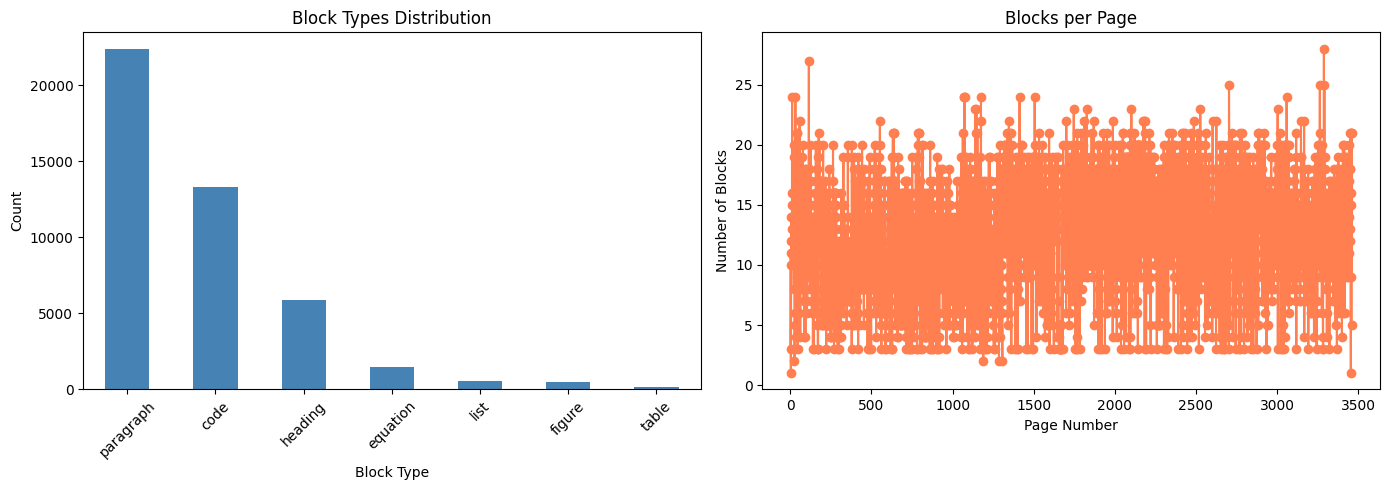

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame from blocks
df = pd.DataFrame(blocks)

print("Block Type Distribution:")
print(df['type'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Block types
df['type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Block Types Distribution')
axes[0].set_xlabel('Block Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Blocks per page
df['page'].value_counts().sort_index().plot(kind='line', ax=axes[1], marker='o', color='coral')
axes[1].set_title('Blocks per Page')
axes[1].set_xlabel('Page Number')
axes[1].set_ylabel('Number of Blocks')

plt.tight_layout()
plt.show()

In [18]:

# Show sample blocks for each type
for block_type in df['type'].unique():
    print(f"\n{'='*60}")
    print(f"SAMPLE {block_type.upper()} BLOCKS")
    print(f"{'='*60}")
    
    samples = df[df['type'] == block_type].head(3)
    
    for idx, row in samples.iterrows():
        print(f"\nBlock ID: {row['block_id']}")
        print(f"Page: {row['page']}")
        print(f"Text: {row['text'][:200]}...")
        print("-" * 60)



SAMPLE HEADING BLOCKS

Block ID: 0
Page: 1
Text: Financial Toolbox™...
------------------------------------------------------------

Block ID: 1
Page: 1
Text: User's Guide...
------------------------------------------------------------

Block ID: 3
Page: 2
Text: How to Contact MathWorks...
------------------------------------------------------------

SAMPLE PARAGRAPH BLOCKS

Block ID: 2
Page: 1
Text: R 2025 b...
------------------------------------------------------------

Block ID: 4
Page: 2
Text: Latest news: www.mathworks.com...
------------------------------------------------------------

Block ID: 5
Page: 2
Text: Sales and services: www.mathworks.com/sales_and_services...
------------------------------------------------------------

SAMPLE LIST BLOCKS

Block ID: 301
Page: 27
Text: • “Financial Toolbox Product Description” on page 1-2 • “Expected Users” on page 1-3 • “Analyze Sets of Numbers Using Matrix Functions” on page 1-4 • “Matrix Algebra Refresher” on page 1-7 • “Using In..

## Stage 2: Chunking

### Cleanup of Parsed Documents before Chunking

In [ ]:
# Cell 1: Setup and Imports
import json
from pathlib import Path
from typing import List, Dict, Any
from collections import Counter
import pandas as pd

# Paths
INPUT_PATH = '../data/final/docling_blocks.jsonl'
OUTPUT_PATH = '../data/final/docling_blocks_cleaned.jsonl'
REPORT_PATH = '../data/final/cleanup_report.json'

In [9]:
# Cell 2: CORRECTED Data Analysis - Identify Redundancies
def analyze_redundancies(jsonl_path: str) -> Dict[str, Any]:
    """
    Analyze the JSONL file to identify redundant/useless patterns.
    Uses SETS to avoid double-counting blocks.
    """
    blocks = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                blocks.append(json.loads(line))
    
    print(f"📊 Total blocks: {len(blocks)}\n")
    
    # Use SETS to track unique block_ids (avoid double counting)
    stats = {
        'total_blocks': len(blocks),
        'by_type': Counter(),
        'single_dot': set(),           # Changed to set
        'single_char': set(),          # Changed to set
        'page_numbers_only': set(),    # Changed to set
        'augmented_figures': set(),    # Changed to set
        'very_small_text': set(),      # Changed to set
        'redundant_blocks': set()      # NEW: Union of all redundant blocks
    }
    
    for block in blocks:
        block_type = block.get('type', 'unknown')
        block_id = block.get('block_id')
        stats['by_type'][block_type] += 1
        
        text = block.get('text', '').strip()
        char_count = block.get('char_count', 0)
        word_count = block.get('word_count', 0)
        
        # Single dot paragraphs
        if text == '.' and block_type == 'paragraph':
            stats['single_dot'].add(block_id)
            stats['redundant_blocks'].add(block_id)
        
        # Single character blocks (excluding meaningful ones)
        if char_count == 1 and text not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']:
            stats['single_char'].add(block_id)
            stats['redundant_blocks'].add(block_id)
        
        # Page numbers only (single digit/number paragraphs)
        if block_type == 'paragraph' and text.isdigit() and len(text) <= 2:
            stats['page_numbers_only'].add(block_id)
            stats['redundant_blocks'].add(block_id)
        
        # Augmented figure captions
        if block_type == 'figure' and block.get('caption_source') == 'augmented':
            stats['augmented_figures'].add(block_id)
            # Note: figures might be kept, so don't add to redundant_blocks
        
        # Very small text (likely parsing artifacts)
        if block_type == 'paragraph' and char_count < 3 and text != '':
            stats['very_small_text'].add(block_id)
            stats['redundant_blocks'].add(block_id)
    
    # Print summary
    print("🔍 REDUNDANCY ANALYSIS")
    print("="*60)
    print(f"\nBlocks by Type:")
    for btype, count in stats['by_type'].items():
        print(f"  {btype:15s}: {count:5d}")
    
    print(f"\n🗑️  Redundant Content (Categories may overlap):")
    print(f"  Single dots (.):        {len(stats['single_dot'])}")
    print(f"  Single characters:      {len(stats['single_char'])}")
    print(f"  Page numbers only:      {len(stats['page_numbers_only'])}")
    print(f"  Augmented figures:      {len(stats['augmented_figures'])} (info only)")
    print(f"  Very small text (<3ch): {len(stats['very_small_text'])}")
    
    # Show overlap analysis
    print(f"\n📊 Overlap Analysis:")
    dots_and_chars = stats['single_dot'] & stats['single_char']
    print(f"  Dots that are also single chars: {len(dots_and_chars)}")
    
    dots_and_small = stats['single_dot'] & stats['very_small_text']
    print(f"  Dots that are also small text:  {len(dots_and_small)}")
    
    # ACTUAL unique redundant blocks
    total_redundant = len(stats['redundant_blocks'])
    
    print(f"\n📉 ACTUAL Unique Redundant Blocks: {total_redundant} ({total_redundant/len(blocks)*100:.1f}%)")
    
    # Convert sets back to lists for JSON serialization
    stats['single_dot'] = list(stats['single_dot'])
    stats['single_char'] = list(stats['single_char'])
    stats['page_numbers_only'] = list(stats['page_numbers_only'])
    stats['augmented_figures'] = list(stats['augmented_figures'])
    stats['very_small_text'] = list(stats['very_small_text'])
    stats['redundant_blocks'] = list(stats['redundant_blocks'])
    
    return stats

# Run corrected analysis
stats = analyze_redundancies(INPUT_PATH)

📊 Total blocks: 907

🔍 REDUNDANCY ANALYSIS

Blocks by Type:
  heading        :    54
  figure         :     8
  paragraph      :   742
  table          :    13
  code           :    40
  equation       :    15
  list           :    35

🗑️  Redundant Content (Categories may overlap):
  Single dots (.):        458
  Single characters:      458
  Page numbers only:      4
  Augmented figures:      7 (info only)
  Very small text (<3ch): 464

📊 Overlap Analysis:
  Dots that are also single chars: 458
  Dots that are also small text:  458

📉 ACTUAL Unique Redundant Blocks: 464 (51.2%)


In [10]:
# Cell 3: Cleanup Functions
def should_keep_block(block: Dict[str, Any], strict_mode: bool = False) -> bool:
    """
    Determine if a block should be kept or removed.
    
    Args:
        block: Block dictionary
        strict_mode: If True, apply more aggressive filtering
    
    Returns:
        True if block should be kept, False otherwise
    """
    block_type = block.get('type', 'unknown')
    text = block.get('text', '').strip()
    char_count = block.get('char_count', 0)
    word_count = block.get('word_count', 0)
    
    # RULE 1: Remove single-dot paragraphs
    if text == '.' and block_type == 'paragraph':
        return False
    
    # RULE 2: Remove very small meaningless text (< 3 chars, excluding numbers)
    if block_type == 'paragraph' and char_count < 3:
        # Keep if it's a number or meaningful
        if not text.isdigit() and text not in ['-', '–', '—', '*', '•']:
            return False
    
    # RULE 3: Remove standalone page number paragraphs (optional in strict mode)
    if strict_mode and block_type == 'paragraph' and text.isdigit() and len(text) <= 2:
        return False
    
    # RULE 4: Remove figures with only augmented captions (optional in strict mode)
    if strict_mode and block_type == 'figure':
        if block.get('caption_source') == 'augmented' and block.get('text') == '[Figure]':
            return False
    
    # RULE 5: Remove blocks with no meaningful content
    if text in ['', ' ', '\n', '\t']:
        return False
    
    # RULE 6: Remove excessive ellipsis/dots patterns
    if text.count('.') > 10 and len(text.replace('.', '').strip()) < 5:
        return False
    
    return True


def clean_block_metadata(block: Dict[str, Any]) -> Dict[str, Any]:
    """
    Clean and optimize block metadata.
    """
    cleaned = block.copy()
    
    # Round bbox coordinates to 2 decimal places (reduce precision bloat)
    if 'bbox' in cleaned:
        bbox = cleaned['bbox']
        for key in ['x0', 'y0', 'x1', 'y1', 'width', 'height']:
            if key in bbox and isinstance(bbox[key], (int, float)):
                bbox[key] = round(bbox[key], 2)
        cleaned['bbox'] = bbox
    
    # Remove sample_hash if it's just a placeholder
    if cleaned.get('pdf_hash') == 'sample_hash':
        cleaned.pop('pdf_hash', None)
    
    # Remove redundant caption_source for non-augmented captions
    if cleaned.get('caption_source') == 'augmented' and 'figure_id' in cleaned:
        # Keep it for tracking, but mark it
        pass
    
    return cleaned

In [11]:
# Cell 4: Execute Cleanup
def cleanup_docling_blocks(
    input_path: str,
    output_path: str,
    strict_mode: bool = False,
    clean_metadata: bool = True
) -> Dict[str, Any]:
    """
    Clean up the Docling-parsed JSONL file.
    
    Args:
        input_path: Input JSONL file path
        output_path: Output cleaned JSONL file path
        strict_mode: Apply aggressive filtering
        clean_metadata: Clean up metadata fields
    
    Returns:
        Dictionary with cleanup statistics
    """
    # Load blocks
    blocks = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                blocks.append(json.loads(line))
    
    print(f"📂 Loaded {len(blocks)} blocks")
    print(f"🔧 Strict mode: {strict_mode}")
    print(f"🧹 Clean metadata: {clean_metadata}\n")
    
    # Filter blocks
    cleaned_blocks = []
    removed_blocks = []
    
    for block in blocks:
        if should_keep_block(block, strict_mode=strict_mode):
            if clean_metadata:
                block = clean_block_metadata(block)
            cleaned_blocks.append(block)
        else:
            removed_blocks.append(block)
    
    # Reassign block_ids sequentially
    for i, block in enumerate(cleaned_blocks):
        block['block_id'] = i
    
    # Save cleaned blocks
    with open(output_path, 'w', encoding='utf-8') as f:
        for block in cleaned_blocks:
            json.dump(block, f, ensure_ascii=False)
            f.write('\n')
    
    # Statistics
    stats = {
        'original_count': len(blocks),
        'cleaned_count': len(cleaned_blocks),
        'removed_count': len(removed_blocks),
        'reduction_pct': (len(removed_blocks) / len(blocks)) * 100,
        'removed_types': Counter(b.get('type') for b in removed_blocks),
        'removed_sample': removed_blocks[:10]  # First 10 removed blocks
    }
    
    print(f"✅ CLEANUP COMPLETE")
    print("="*60)
    print(f"Original blocks:  {stats['original_count']}")
    print(f"Cleaned blocks:   {stats['cleaned_count']}")
    print(f"Removed blocks:   {stats['removed_count']} ({stats['reduction_pct']:.1f}%)")
    print(f"\nRemoved by type:")
    for btype, count in stats['removed_types'].items():
        print(f"  {btype:15s}: {count}")
    
    print(f"\n💾 Saved to: {output_path}")
    
    return stats

# Run cleanup
cleanup_stats = cleanup_docling_blocks(
    INPUT_PATH,
    OUTPUT_PATH,
    strict_mode=False,  # Set to True for aggressive cleanup
    clean_metadata=True
)

📂 Loaded 907 blocks
🔧 Strict mode: False
🧹 Clean metadata: True

✅ CLEANUP COMPLETE
Original blocks:  907
Cleaned blocks:   431
Removed blocks:   476 (52.5%)

Removed by type:
  paragraph      : 460
  equation       : 15
  table          : 1

💾 Saved to: ../data/final/docling_blocks_cleaned.jsonl


In [12]:
# Cell 5: Save Cleanup Report
report = {
    'input_file': INPUT_PATH,
    'output_file': OUTPUT_PATH,
    'analysis': stats,
    'cleanup': cleanup_stats,
    'rules_applied': [
        "Remove single-dot paragraphs",
        "Remove very small meaningless text (<3 chars)",
        "Remove excessive ellipsis patterns",
        "Round bbox coordinates to 2 decimals",
        "Remove placeholder pdf_hash"
    ]
}

with open(REPORT_PATH, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False, default=str)

print(f"📋 Report saved to: {REPORT_PATH}")

📋 Report saved to: ../data/final/cleanup_report.json


In [13]:
# Cell 6: Visualize Before/After
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_cleanup(before_stats, after_stats):
    """Visualize the cleanup results"""
    
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Before Cleanup', 'After Cleanup'),
        specs=[[{'type': 'pie'}, {'type': 'pie'}]]
    )
    
    # Before cleanup
    fig.add_trace(
        go.Pie(
            labels=list(before_stats['by_type'].keys()),
            values=list(before_stats['by_type'].values()),
            name="Before"
        ),
        row=1, col=1
    )
    
    # After cleanup (calculate from cleaned blocks)
    # Load cleaned file
    cleaned_blocks = []
    with open(OUTPUT_PATH, 'r') as f:
        for line in f:
            if line.strip():
                cleaned_blocks.append(json.loads(line))
    
    after_types = Counter(b.get('type') for b in cleaned_blocks)
    
    fig.add_trace(
        go.Pie(
            labels=list(after_types.keys()),
            values=list(after_types.values()),
            name="After"
        ),
        row=1, col=2
    )
    
    fig.update_layout(
        title_text="Document Blocks: Before vs After Cleanup",
        height=500
    )
    
    fig.show()

visualize_cleanup(stats, cleanup_stats)

In [14]:
# Cell 7: Sample Removed Content
def show_removed_samples(cleanup_stats, n=10):
    """Display sample of removed blocks for verification"""
    
    print("\n🗑️  SAMPLE OF REMOVED BLOCKS")
    print("="*60)
    
    for i, block in enumerate(cleanup_stats['removed_sample'][:n], 1):
        print(f"\n{i}. Block ID: {block.get('block_id')}")
        print(f"   Type: {block.get('type')}")
        print(f"   Text: '{block.get('text')}'")
        print(f"   Char count: {block.get('char_count')}")
        print(f"   Page: {block.get('page')}")

show_removed_samples(cleanup_stats)


🗑️  SAMPLE OF REMOVED BLOCKS

1. Block ID: 37
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

2. Block ID: 38
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

3. Block ID: 39
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

4. Block ID: 40
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

5. Block ID: 41
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

6. Block ID: 42
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

7. Block ID: 43
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

8. Block ID: 44
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

9. Block ID: 45
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5

10. Block ID: 46
   Type: paragraph
   Text: '.'
   Char count: 1
   Page: 5


In [15]:
# Cell 8: Validate Cleaned Data
def validate_cleaned_data(cleaned_path: str):
    """Ensure cleaned data maintains document integrity"""
    
    with open(cleaned_path, 'r') as f:
        blocks = [json.loads(line) for line in f if line.strip()]
    
    print("\n✓ VALIDATION RESULTS")
    print("="*60)
    
    # Check sequential block_ids
    ids = [b['block_id'] for b in blocks]
    assert ids == list(range(len(ids))), "Block IDs not sequential!"
    print(f"✓ Block IDs sequential: 0 to {len(ids)-1}")
    
    # Check all blocks have required fields
    required_fields = ['block_id', 'type', 'text', 'page']
    for i, block in enumerate(blocks):
        for field in required_fields:
            assert field in block, f"Block {i} missing {field}"
    print(f"✓ All blocks have required fields")
    
    # Check section paths preserved
    sections = set(b.get('section_path') for b in blocks if 'section_path' in b)
    print(f"✓ Preserved {len(sections)} unique sections")
    
    # Check content types
    types = Counter(b.get('type') for b in blocks)
    print(f"✓ Content types: {dict(types)}")
    
    print("\n✅ Validation passed!")

validate_cleaned_data(OUTPUT_PATH)


✓ VALIDATION RESULTS
✓ Block IDs sequential: 0 to 430
✓ All blocks have required fields
✓ Preserved 49 unique sections
✓ Content types: {'heading': 54, 'figure': 8, 'paragraph': 282, 'table': 12, 'code': 40, 'list': 35}

✅ Validation passed!


### Method 1: Section-based Chunking

In [16]:
# Cell 1: Imports and Setup
import json
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Any
from dataclasses import dataclass, asdict
import pandas as pd

In [17]:

# Path configuration
PARSED_RESULT_PATH = '../data/final/docling_blocks_cleaned.jsonl'
OUTPUT_PATH = '../data/chunks/section_based_chunks.jsonl'

Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

In [18]:
# Cell 2: Define Chunk Data Structure
@dataclass
class SectionChunk:
    """Represents a section-based chunk with metadata"""
    chunk_id: int
    section_path: str
    section_title: str
    content: str
    metadata: Dict[str, Any]
    
    def to_dict(self):
        return asdict(self)
    
    def __len__(self):
        return len(self.content)

In [19]:
def chunk_by_section(
    jsonl_path: str,
    max_chunk_size: int = None,
    include_section_title: bool = True,
    skip_types: List[str] = ['figure']
) -> List[SectionChunk]:
    """
    Chunk document by section_path, preserving semantic coherence.
    
    Args:
        jsonl_path: Path to Docling-parsed JSONL file
        max_chunk_size: Optional max size; if exceeded, section is split
        include_section_title: Whether to add section title as header
        skip_types: Block types to skip (e.g., figures)
    
    Returns:
        List of SectionChunk objects
    """
    
    # Step 1: Load and group blocks by section
    sections = defaultdict(list)
    
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                block = json.loads(line)
                section_path = block.get('section_path', 'Unknown Section')
                sections[section_path].append(block)
    
    print(f"📚 Found {len(sections)} unique sections")
    
    # Step 2: Process each section
    chunks = []
    chunk_id = 0
    
    for section_path, blocks in sections.items():
        # Sort blocks by page and block_id to maintain order
        blocks.sort(key=lambda x: (x.get('page', 0), x.get('block_id', 0)))
        
        # Extract section title (from first heading)
        section_title = section_path  # Default to section path
        heading_blocks = [b for b in blocks if b.get('type') == 'heading']
        if heading_blocks:
            section_title = heading_blocks[0].get('text', section_path)
        
        # Accumulate content for this section
        section_content = []
        section_metadata = {
            'pages': set(),
            'block_ids': [],
            'block_types': set(),
            'num_blocks': 0,
            'has_tables': False,
            'has_figures': False
        }
        
        for block in blocks:
            block_type = block.get('type', 'unknown')
            
            # Skip certain types
            if block_type in skip_types:
                section_metadata['has_figures'] = True
                continue
            
            # Extract text based on block type
            block_text = block.get('text', '')
            
            if block_type == 'heading':
                # Skip if it's the main section heading (we'll add it separately)
                if block.get('heading_level') == 1:
                    continue
                # Sub-headings get formatted
                section_content.append(f"\n## {block_text}\n")
                
            elif block_type == 'paragraph':
                section_content.append(block_text)
                
            elif block_type == 'table':
                section_metadata['has_tables'] = True
                caption = block.get('caption', 'Table')
                section_content.append(f"\n### {caption}\n```\n{block_text}\n```\n")
            
            else:
                # Handle other types
                section_content.append(block_text)
            
            # Update metadata
            section_metadata['pages'].add(block.get('page', 0))
            section_metadata['block_ids'].append(block.get('block_id', 0))
            section_metadata['block_types'].add(block_type)
            section_metadata['num_blocks'] += 1
        
        # Combine all content
        combined_content = '\n\n'.join(section_content).strip()
        
        if not combined_content:
            continue  # Skip empty sections
        
        # Add section title if requested
        if include_section_title and section_title:
            full_content = f"# {section_title}\n\n{combined_content}"
        else:
            full_content = combined_content
        
        # Convert sets to lists for JSON serialization
        metadata_dict = {
            'pages': sorted(list(section_metadata['pages'])),
            'block_ids': section_metadata['block_ids'],
            'block_types': list(section_metadata['block_types']),
            'num_blocks': section_metadata['num_blocks'],
            'has_tables': section_metadata['has_tables'],
            'has_figures': section_metadata['has_figures'],
            'char_count': len(full_content),
            'word_count': len(full_content.split()),
            'source': 'fintbx.pdf',
            'chunking_method': 'section_based'
        }
        
        # Check if we need to split (if max_chunk_size is set)
        if max_chunk_size and len(full_content) > max_chunk_size:
            # Split into smaller chunks while preserving section context
            sub_chunks = split_large_section(
                full_content, 
                section_path, 
                section_title,
                max_chunk_size,
                metadata_dict
            )
            
            for sub_chunk in sub_chunks:
                chunks.append(SectionChunk(
                    chunk_id=chunk_id,
                    section_path=section_path,
                    section_title=section_title,
                    content=sub_chunk['content'],
                    metadata=sub_chunk['metadata']
                ))
                chunk_id += 1
        else:
            # Create single chunk for this section
            chunks.append(SectionChunk(
                chunk_id=chunk_id,
                section_path=section_path,
                section_title=section_title,
                content=full_content,
                metadata=metadata_dict
            ))
            chunk_id += 1
    
    return chunks


def split_large_section(
    content: str,
    section_path: str,
    section_title: str,
    max_size: int,
    base_metadata: Dict
) -> List[Dict]:
    """Split large sections while maintaining context"""
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_size,
        chunk_overlap=200,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    
    split_texts = splitter.split_text(content)
    
    sub_chunks = []
    for i, text in enumerate(split_texts):
        metadata = base_metadata.copy()
        metadata.update({
            'is_split': True,
            'split_index': i,
            'total_splits': len(split_texts),
            'char_count': len(text),
            'word_count': len(text.split())
        })
        
        sub_chunks.append({
            'content': text,
            'metadata': metadata
        })
    
    return sub_chunks

In [20]:
print("🚀 Starting Section-Based Chunking...")
print(f"📂 Input: {PARSED_RESULT_PATH}")
print(f"📝 Output: {OUTPUT_PATH}\n")

# Run chunking
chunks = chunk_by_section(
    jsonl_path=PARSED_RESULT_PATH,
    max_chunk_size=None,  # Set to 2000 if you want to limit chunk size
    include_section_title=True,
    skip_types=['figure']
)

print(f"\n✅ Created {len(chunks)} section-based chunks")


🚀 Starting Section-Based Chunking...
📂 Input: ../data/final/docling_blocks_cleaned.jsonl
📝 Output: ../data/chunks/section_based_chunks.jsonl

📚 Found 49 unique sections

✅ Created 47 section-based chunks


In [21]:
def analyze_chunks(chunks: List[SectionChunk]) -> pd.DataFrame:
    """Generate statistics about the chunks"""
    
    stats = []
    for chunk in chunks:
        stats.append({
            'chunk_id': chunk.chunk_id,
            'section': chunk.section_path,
            'title': chunk.section_title[:50] + '...' if len(chunk.section_title) > 50 else chunk.section_title,
            'char_count': len(chunk.content),
            'word_count': len(chunk.content.split()),
            'pages': ', '.join(map(str, chunk.metadata.get('pages', []))),
            'num_blocks': chunk.metadata.get('num_blocks', 0),
            'has_tables': chunk.metadata.get('has_tables', False),
            'block_types': ', '.join(chunk.metadata.get('block_types', []))
        })
    
    df = pd.DataFrame(stats)
    
    print("\n📊 CHUNK STATISTICS\n" + "="*60)
    print(f"Total Chunks: {len(chunks)}")
    print(f"Average Characters: {df['char_count'].mean():.0f}")
    print(f"Median Characters: {df['char_count'].median():.0f}")
    print(f"Min Characters: {df['char_count'].min()}")
    print(f"Max Characters: {df['char_count'].max()}")
    print(f"\nAverage Words: {df['word_count'].mean():.0f}")
    print(f"Chunks with Tables: {df['has_tables'].sum()}")
    print(f"\nTop 5 Largest Chunks:")
    print(df.nlargest(5, 'char_count')[['chunk_id', 'title', 'char_count', 'word_count']])
    
    return df

# Run analysis
stats_df = analyze_chunks(chunks)


📊 CHUNK STATISTICS
Total Chunks: 47
Average Characters: 1668
Median Characters: 940
Min Characters: 19
Max Characters: 13267

Average Words: 241
Chunks with Tables: 10

Top 5 Largest Chunks:
    chunk_id                                  title  char_count  word_count
4          4                       Revision History       13267        1965
5          5                   Credit Risk Analysis        8687        1207
16        16                       Related Examples        7822         762
44        44                         Binomial Model        6324         571
9          9  Solving Simultaneous Linear Equations        3493         628


In [22]:
def preview_chunks(chunks: List[SectionChunk], num_samples: int = 3):
    """Display sample chunks for inspection"""
    
    print("\n📖 SAMPLE CHUNKS\n" + "="*60)
    
    for i, chunk in enumerate(chunks[:num_samples]):
        print(f"\n{'─'*60}")
        print(f"CHUNK {chunk.chunk_id}: {chunk.section_title}")
        print(f"{'─'*60}")
        print(f"Section Path: {chunk.section_path}")
        print(f"Pages: {chunk.metadata.get('pages', [])}")
        print(f"Size: {len(chunk.content)} chars, {len(chunk.content.split())} words")
        print(f"\nContent Preview (first 500 chars):")
        print(chunk.content[:500] + "..." if len(chunk.content) > 500 else chunk.content)
        print()

# Preview first 3 chunks
preview_chunks(chunks, num_samples=3)


📖 SAMPLE CHUNKS

────────────────────────────────────────────────────────────
CHUNK 0: MATLAB®
────────────────────────────────────────────────────────────
Section Path: MATLAB®
Pages: [1]
Size: 19 chars, 5 words

Content Preview (first 500 chars):
# MATLAB®

R 2025 b


────────────────────────────────────────────────────────────
CHUNK 1: How to Contact MathWorks
────────────────────────────────────────────────────────────
Section Path: How to Contact MathWorks
Pages: [2]
Size: 1761 chars, 247 words

Content Preview (first 500 chars):
# How to Contact MathWorks

Latest news:

www.mathworks.com

Sales and services:

www.mathworks.com/sales_and_services

User community:

www.mathworks.com/matlabcentral

Technical support:

www.mathworks.com/support/contact_us

Phone:

508-647-7000

The MathWorks, Inc. 1 Apple Hill Drive Natick, MA 01760-2098

Financial Toolbox™ User's Guide

© COPYRIGHT 1995-2025 by The MathWorks, Inc.

The software described in this document is furnished under a licens

In [23]:
def save_chunks(chunks: List[SectionChunk], output_path: str):
    """Save chunks to JSONL file"""
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            json.dump(chunk.to_dict(), f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n💾 Saved {len(chunks)} chunks to: {output_path}")
    
    # Also save metadata summary
    summary_path = output_path.replace('.jsonl', '_summary.json')
    summary = {
        'total_chunks': len(chunks),
        'chunking_method': 'section_based',
        'statistics': {
            'avg_chars': sum(len(c.content) for c in chunks) / len(chunks),
            'min_chars': min(len(c.content) for c in chunks),
            'max_chars': max(len(c.content) for c in chunks),
            'total_sections': len(set(c.section_path for c in chunks))
        }
    }
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"📋 Saved summary to: {summary_path}")

# Save the chunks
save_chunks(chunks, OUTPUT_PATH)


💾 Saved 47 chunks to: ../data/chunks/section_based_chunks.jsonl
📋 Saved summary to: ../data/chunks/section_based_chunks_summary.json


In [24]:
import plotly.express as px
import plotly.graph_objects as go

def visualize_chunks(stats_df: pd.DataFrame):
    """Create visualizations of chunk statistics"""
    
    # 1. Chunk size distribution
    fig1 = px.histogram(
        stats_df,
        x='char_count',
        nbins=30,
        title='Chunk Size Distribution',
        labels={'char_count': 'Characters', 'count': 'Number of Chunks'}
    )
    fig1.update_layout(showlegend=False)
    fig1.show()
    
    # 2. Word count distribution
    fig2 = px.histogram(
        stats_df,
        x='word_count',
        nbins=30,
        title='Word Count Distribution',
        labels={'word_count': 'Words', 'count': 'Number of Chunks'}
    )
    fig2.update_layout(showlegend=False)
    fig2.show()
    
    # 3. Chunks per section
    section_counts = stats_df['section'].value_counts().head(10)
    fig3 = px.bar(
        x=section_counts.index,
        y=section_counts.values,
        title='Top 10 Sections by Number of Chunks',
        labels={'x': 'Section', 'y': 'Number of Chunks'}
    )
    fig3.update_layout(xaxis_tickangle=-45)
    fig3.show()
    
    # 4. Summary metrics
    print("\n📈 VISUALIZATION SUMMARY")
    print(f"Size range: {stats_df['char_count'].min()} - {stats_df['char_count'].max()} characters")
    print(f"Standard deviation: {stats_df['char_count'].std():.0f} characters")

# Generate visualizations
visualize_chunks(stats_df)


📈 VISUALIZATION SUMMARY
Size range: 19 - 13267 characters
Standard deviation: 2523 characters


In [25]:
def export_for_embedding(chunks: List[SectionChunk], output_path: str = None):
    """
    Export chunks in a format ready for embedding generation
    """
    if output_path is None:
        output_path = OUTPUT_PATH.replace('.jsonl', '_for_embedding.jsonl')
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            embedding_doc = {
                'id': chunk.chunk_id,
                'text': chunk.content,
                'metadata': {
                    'section': chunk.section_path,
                    'title': chunk.section_title,
                    'pages': chunk.metadata.get('pages', []),
                    'source': 'fintbx_ex.pdf'
                }
            }
            json.dump(embedding_doc, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"🎯 Exported {len(chunks)} chunks for embedding: {output_path}")

# Export for embeddings
export_for_embedding(chunks)

🎯 Exported 47 chunks for embedding: ../data/chunks/section_based_chunks_for_embedding.jsonl


In [26]:
def search_chunks(chunks: List[SectionChunk], query: str, top_k: int = 3):
    """
    Simple keyword-based search for testing
    (Replace with semantic search after embedding generation)
    """
    query_lower = query.lower()
    
    # Score chunks by keyword matches
    scored_chunks = []
    for chunk in chunks:
        score = chunk.content.lower().count(query_lower)
        if score > 0:
            scored_chunks.append((chunk, score))
    
    # Sort by score
    scored_chunks.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n🔍 Search Results for: '{query}'")
    print(f"Found {len(scored_chunks)} matching chunks\n")
    
    for i, (chunk, score) in enumerate(scored_chunks[:top_k], 1):
        print(f"{i}. {chunk.section_title} (Score: {score})")
        print(f"   Pages: {chunk.metadata.get('pages', [])}")
        print(f"   Preview: {chunk.content[:200]}...")
        print()

# Test search
search_chunks(chunks, "portfolio", top_k=3)


🔍 Search Results for: 'portfolio'
Found 8 matching chunks

1. Revision History (Score: 25)
   Pages: [3, 4, 5]
   Preview: # Revision History

October 1995 First printing January 1998 Second printing January 1999 Third printing November 2000 Fourth printing May 2003 Online only June 2004 Online only August 2004 Online onl...

2. Multiplying Two Matrices (Score: 11)
   Pages: [7]
   Preview: # Multiplying Two Matrices

Matrix multiplication also follows the rules of matrix algebra. In matrix algebra notation, if A is an m -byn matrix and B is an n -byp matrix

then C = A * B is an m -byp ...

3. Bond Portfolio Example (Score: 7)
   Pages: [20, 21]
   Preview: # Bond Portfolio Example

Since the previous example included only a single bond, there was no difference between passing an empty matrix or passing a NaN for an optional input argument. For a portfol...



### Method 2: Hierarchical Chunking with Context 

In [27]:
# Cell 1: Hierarchical Chunking Setup
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
import json
from pathlib import Path

# Paths
CLEANED_DATA_PATH = '../data/final/docling_blocks_cleaned.jsonl'
OUTPUT_PATH = '../data/chunks/hierarchical_chunks.jsonl'
OUTPUT_EMBEDDING_PATH = '../data/chunks/hierarchical_chunks_for_embedding.jsonl'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

In [28]:
# Cell 2: Hierarchical Chunk Data Structure
@dataclass
class HierarchicalChunk:
    """
    Represents a chunk with hierarchical context preserved.
    """
    chunk_id: int
    content: str
    heading_hierarchy: List[str]  # Breadcrumb trail
    heading_levels: List[int]     # Level of each heading
    section_path: str
    context_header: str           # Full breadcrumb string
    metadata: Dict[str, Any]
    
    def to_dict(self):
        return asdict(self)
    
    def __len__(self):
        return len(self.content)
    
    @property
    def full_text(self):
        """Content with context header"""
        if self.context_header:
            return f"{self.context_header}\n\n{self.content}"
        return self.content

In [29]:
def chunk_hierarchical(
    jsonl_path: str,
    max_chunk_size: int = 1500,
    include_context_header: bool = True,
    context_separator: str = " > ",
    skip_types: List[str] = ['figure']
) -> List[HierarchicalChunk]:
    """
    Create hierarchical chunks that preserve document structure.
    
    Features:
    - Maintains heading hierarchy stack
    - Adds breadcrumb context to each chunk
    - Preserves parent-child relationships
    - Respects heading levels (h1, h2, h3, etc.)
    
    Args:
        jsonl_path: Path to cleaned JSONL file
        max_chunk_size: Maximum chunk size in characters
        include_context_header: Whether to prepend context breadcrumbs
        context_separator: String to join heading hierarchy
        skip_types: Block types to skip
    
    Returns:
        List of HierarchicalChunk objects
    """
    
    # Load blocks
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        blocks = [json.loads(line) for line in f if line.strip()]
    
    # Sort by page and block_id to maintain document order
    blocks.sort(key=lambda x: (x.get('page', 0), x.get('block_id', 0)))
    
    print(f"📚 Processing {len(blocks)} blocks for hierarchical chunking...")
    print(f"📏 Max chunk size: {max_chunk_size} characters")
    print(f"🔗 Context separator: '{context_separator}'\n")
    
    chunks = []
    chunk_id = 0
    
    # Heading hierarchy stack
    heading_stack = []  # List of {'level': int, 'text': str, 'section': str}
    
    # Current chunk accumulation
    current_chunk_content = []
    current_chunk_metadata = {
        'pages': set(),
        'block_ids': [],
        'block_types': set(),
        'has_tables': False,
        'has_code': False,
        'has_equations': False,
        'has_lists': False
    }
    
    def create_chunk():
        """Helper to create and save current chunk"""
        nonlocal chunk_id, current_chunk_content, current_chunk_metadata, heading_stack, chunks
        
        if not current_chunk_content:
            return
        
        # Combine content
        content = '\n\n'.join(current_chunk_content).strip()
        
        if not content:
            return
        
        # Build context header from heading hierarchy
        hierarchy_text = [h['text'] for h in heading_stack]
        hierarchy_levels = [h['level'] for h in heading_stack]
        context_header = ""
        
        if include_context_header and hierarchy_text:
            context_header = f"[Context: {context_separator.join(hierarchy_text)}]"
        
        # Get section path
        section_path = heading_stack[-1]['section'] if heading_stack else 'Unknown'
        
        # Create metadata
        metadata = {
            'pages': sorted(list(current_chunk_metadata['pages'])),
            'block_ids': current_chunk_metadata['block_ids'].copy(),
            'block_types': list(current_chunk_metadata['block_types']),
            'num_blocks': len(current_chunk_metadata['block_ids']),
            'has_tables': current_chunk_metadata['has_tables'],
            'has_code': current_chunk_metadata['has_code'],
            'has_equations': current_chunk_metadata['has_equations'],
            'has_lists': current_chunk_metadata['has_lists'],
            'char_count': len(content),
            'word_count': len(content.split()),
            'hierarchy_depth': len(heading_stack),
            'source': 'fintbx.pdf',
            'chunking_method': 'hierarchical'
        }
        
        # Create chunk
        chunk = HierarchicalChunk(
            chunk_id=chunk_id,
            content=content,
            heading_hierarchy=hierarchy_text.copy(),
            heading_levels=hierarchy_levels.copy(),
            section_path=section_path,
            context_header=context_header,
            metadata=metadata
        )
        
        chunks.append(chunk)
        chunk_id += 1
        
        # Reset accumulation
        current_chunk_content = []
        current_chunk_metadata = {
            'pages': set(),
            'block_ids': [],
            'block_types': set(),
            'has_tables': False,
            'has_code': False,
            'has_equations': False,
            'has_lists': False
        }
        
        return current_chunk_content, current_chunk_metadata
    
    # Process blocks
    for block in blocks:
        block_type = block.get('type', 'unknown')
        block_id = block.get('block_id')
        text = block.get('text', '').strip()
        
        # Handle headings - update hierarchy
        if block_type == 'heading':
            heading_level = block.get('heading_level', 1)
            section_path = block.get('section_path', text)
            
            # Flush current chunk before changing context
            if current_chunk_content:
                current_chunk_content, current_chunk_metadata = create_chunk()
            
            # Pop headings at same or deeper level
            heading_stack = [h for h in heading_stack if h['level'] < heading_level]
            
            # Add new heading to stack
            heading_stack.append({
                'level': heading_level,
                'text': text,
                'section': section_path
            })
            
            # Don't add heading text to content (it's in context)
            continue
        
        # Skip certain types
        if block_type in skip_types:
            continue
        
        # Prepare block text
        block_text = ""
        
        if block_type == 'table':
            current_chunk_metadata['has_tables'] = True
            caption = block.get('caption', 'Table')
            block_text = f"### {caption}\n```\n{text}\n```"
            
        elif block_type == 'code':
            current_chunk_metadata['has_code'] = True
            block_text = f"```\n{text}\n```"
            
        elif block_type == 'equation':
            current_chunk_metadata['has_equations'] = True
            block_text = f"$$\n{text}\n$$"
            
        elif block_type == 'list':
            current_chunk_metadata['has_lists'] = True
            block_text = text
            
        elif block_type == 'paragraph':
            block_text = text
            
        else:
            block_text = text
        
        # Check if adding this block would exceed max size
        current_size = sum(len(c) for c in current_chunk_content)
        if current_size + len(block_text) > max_chunk_size and current_chunk_content:
            # Create chunk with current content
            current_chunk_content, current_chunk_metadata = create_chunk()
        
        # Add block to current chunk
        current_chunk_content.append(block_text)
        current_chunk_metadata['pages'].add(block.get('page', 0))
        current_chunk_metadata['block_ids'].append(block_id)
        current_chunk_metadata['block_types'].add(block_type)
    
    # Create final chunk
    create_chunk()
    
    print(f"✅ Created {len(chunks)} hierarchical chunks")
    
    return chunks

In [30]:
print("🚀 Starting Hierarchical Chunking with Context...\n")

hierarchical_chunks = chunk_hierarchical(
    jsonl_path=CLEANED_DATA_PATH,
    max_chunk_size=1500,
    include_context_header=True,
    context_separator=" > ",
    skip_types=['figure']
)

print(f"\n✅ Hierarchical chunking complete!")
print(f"📊 Total chunks: {len(hierarchical_chunks)}")

🚀 Starting Hierarchical Chunking with Context...

📚 Processing 431 blocks for hierarchical chunking...
📏 Max chunk size: 1500 characters
🔗 Context separator: ' > '

✅ Created 72 hierarchical chunks

✅ Hierarchical chunking complete!
📊 Total chunks: 72


In [31]:
def analyze_hierarchical_chunks(chunks: List[HierarchicalChunk]) -> pd.DataFrame:
    """Generate comprehensive statistics about hierarchical chunks"""
    
    stats = []
    for chunk in chunks:
        stats.append({
            'chunk_id': chunk.chunk_id,
            'hierarchy_depth': len(chunk.heading_hierarchy),
            'context': chunk.context_header[:80] + '...' if len(chunk.context_header) > 80 else chunk.context_header,
            'char_count': len(chunk.content),
            'word_count': len(chunk.content.split()),
            'pages': ', '.join(map(str, chunk.metadata.get('pages', []))),
            'num_blocks': chunk.metadata.get('num_blocks', 0),
            'has_tables': chunk.metadata.get('has_tables', False),
            'has_code': chunk.metadata.get('has_code', False),
            'has_equations': chunk.metadata.get('has_equations', False),
            'section_path': chunk.section_path[:50] + '...' if len(chunk.section_path) > 50 else chunk.section_path
        })
    
    df = pd.DataFrame(stats)
    
    print("\n📊 HIERARCHICAL CHUNK STATISTICS")
    print("="*70)
    print(f"Total Chunks: {len(chunks)}")
    print(f"\nSize Distribution:")
    print(f"  Average Characters: {df['char_count'].mean():.0f}")
    print(f"  Median Characters:  {df['char_count'].median():.0f}")
    print(f"  Min Characters:     {df['char_count'].min()}")
    print(f"  Max Characters:     {df['char_count'].max()}")
    print(f"  Std Dev:            {df['char_count'].std():.0f}")
    
    print(f"\nHierarchy Depth Distribution:")
    depth_counts = df['hierarchy_depth'].value_counts().sort_index()
    for depth, count in depth_counts.items():
        print(f"  Level {depth}: {count} chunks")
    
    print(f"\nContent Type Distribution:")
    print(f"  Chunks with Tables:    {df['has_tables'].sum()}")
    print(f"  Chunks with Code:      {df['has_code'].sum()}")
    print(f"  Chunks with Equations: {df['has_equations'].sum()}")
    
    print(f"\nTop 5 Largest Chunks:")
    print(df.nlargest(5, 'char_count')[['chunk_id', 'context', 'char_count', 'word_count']])
    
    return df

# Run analysis
hierarchical_stats_df = analyze_hierarchical_chunks(hierarchical_chunks)


📊 HIERARCHICAL CHUNK STATISTICS
Total Chunks: 72

Size Distribution:
  Average Characters: 1078
  Median Characters:  734
  Min Characters:     8
  Max Characters:     8800
  Std Dev:            1602

Hierarchy Depth Distribution:
  Level 1: 72 chunks

Content Type Distribution:
  Chunks with Tables:    11
  Chunks with Code:      24
  Chunks with Equations: 0

Top 5 Largest Chunks:
    chunk_id                          context  char_count  word_count
7          7      [Context: Revision History]        8800        1111
10        10  [Context: Credit Risk Analysis]        7627        1012
34        34      [Context: Related Examples]        7612         730
64        64        [Context: Binomial Model]        4391         238
31        31             [Context: Annuities]        2199         283


In [32]:
def preview_hierarchical_chunks(chunks: List[HierarchicalChunk], num_samples: int = 3):
    """Display sample chunks with full context"""
    
    print("\n📖 SAMPLE HIERARCHICAL CHUNKS")
    print("="*70)
    
    for i, chunk in enumerate(chunks[:num_samples]):
        print(f"\n{'─'*70}")
        print(f"CHUNK {chunk.chunk_id}")
        print(f"{'─'*70}")
        
        print(f"\n🔗 Hierarchy:")
        for level, heading in zip(chunk.heading_levels, chunk.heading_hierarchy):
            indent = "  " * (level - 1)
            print(f"{indent}{'└─' if level > 1 else '►'} H{level}: {heading}")
        
        print(f"\n📍 Context Header:")
        print(f"  {chunk.context_header}")
        
        print(f"\n📄 Metadata:")
        print(f"  Pages: {chunk.metadata.get('pages', [])}")
        print(f"  Blocks: {chunk.metadata.get('num_blocks', 0)}")
        print(f"  Size: {len(chunk.content)} chars, {len(chunk.content.split())} words")
        print(f"  Depth: {chunk.metadata.get('hierarchy_depth', 0)}")
        print(f"  Section: {chunk.section_path}")
        
        print(f"\n📝 Content Preview (first 400 chars):")
        print(f"  {chunk.content[:400]}...")
        print()

# Preview first 3 chunks
preview_hierarchical_chunks(hierarchical_chunks, num_samples=3)


📖 SAMPLE HIERARCHICAL CHUNKS

──────────────────────────────────────────────────────────────────────
CHUNK 0
──────────────────────────────────────────────────────────────────────

🔗 Hierarchy:
► H1: MATLAB®

📍 Context Header:
  [Context: MATLAB®]

📄 Metadata:
  Pages: [1]
  Blocks: 1
  Size: 8 chars, 3 words
  Depth: 1
  Section: MATLAB®

📝 Content Preview (first 400 chars):
  R 2025 b...


──────────────────────────────────────────────────────────────────────
CHUNK 1
──────────────────────────────────────────────────────────────────────

🔗 Hierarchy:
► H1: How to Contact MathWorks

📍 Context Header:
  [Context: How to Contact MathWorks]

📄 Metadata:
  Pages: [2]
  Blocks: 14
  Size: 647 chars, 84 words
  Depth: 1
  Section: How to Contact MathWorks

📝 Content Preview (first 400 chars):
  Latest news:

www.mathworks.com

Sales and services:

www.mathworks.com/sales_and_services

User community:

www.mathworks.com/matlabcentral

Technical support:

www.mathworks.com/support/contact_us

In [33]:
def save_hierarchical_chunks(chunks: List[HierarchicalChunk], output_path: str):
    """Save chunks to JSONL file"""
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            json.dump(chunk.to_dict(), f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n💾 Saved {len(chunks)} chunks to: {output_path}")
    
    # Save summary
    summary_path = output_path.replace('.jsonl', '_summary.json')
    summary = {
        'total_chunks': len(chunks),
        'chunking_method': 'hierarchical_with_context',
        'statistics': {
            'avg_chars': sum(len(c.content) for c in chunks) / len(chunks),
            'min_chars': min(len(c.content) for c in chunks),
            'max_chars': max(len(c.content) for c in chunks),
            'avg_depth': sum(len(c.heading_hierarchy) for c in chunks) / len(chunks),
            'max_depth': max(len(c.heading_hierarchy) for c in chunks),
            'chunks_with_tables': sum(1 for c in chunks if c.metadata.get('has_tables')),
            'chunks_with_code': sum(1 for c in chunks if c.metadata.get('has_code')),
            'chunks_with_equations': sum(1 for c in chunks if c.metadata.get('has_equations'))
        }
    }
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"📋 Saved summary to: {summary_path}")

# Save the chunks
save_hierarchical_chunks(hierarchical_chunks, OUTPUT_PATH)


💾 Saved 72 chunks to: ../data/chunks/hierarchical_chunks.jsonl
📋 Saved summary to: ../data/chunks/hierarchical_chunks_summary.json


In [34]:
def export_hierarchical_for_embedding(chunks: List[HierarchicalChunk], output_path: str):
    """
    Export hierarchical chunks in format ready for embedding generation.
    Includes full context in the text field.
    """
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            embedding_doc = {
                'id': chunk.chunk_id,
                'text': chunk.full_text,  # Includes context header + content
                'metadata': {
                    'hierarchy': chunk.heading_hierarchy,
                    'levels': chunk.heading_levels,
                    'section': chunk.section_path,
                    'pages': chunk.metadata.get('pages', []),
                    'depth': len(chunk.heading_hierarchy),
                    'has_tables': chunk.metadata.get('has_tables', False),
                    'has_code': chunk.metadata.get('has_code', False),
                    'source': 'fintbx.pdf'
                }
            }
            json.dump(embedding_doc, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n🎯 Exported {len(chunks)} chunks for embedding: {output_path}")
    print(f"📝 Each chunk includes hierarchical context in the text field")

# Export for embeddings
export_hierarchical_for_embedding(hierarchical_chunks, OUTPUT_EMBEDDING_PATH)


🎯 Exported 72 chunks for embedding: ../data/chunks/hierarchical_chunks_for_embedding.jsonl
📝 Each chunk includes hierarchical context in the text field


In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_hierarchical_structure(chunks: List[HierarchicalChunk]):
    """Visualize the hierarchical structure of chunks"""
    
    # Prepare data
    depths = [len(c.heading_hierarchy) for c in chunks]
    sizes = [len(c.content) for c in chunks]
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Hierarchy Depth Distribution',
            'Chunk Size Distribution',
            'Size vs Depth',
            'Chunks by Content Type'
        ),
        specs=[
            [{'type': 'bar'}, {'type': 'histogram'}],
            [{'type': 'scatter'}, {'type': 'pie'}]
        ]
    )
    
    # 1. Hierarchy depth distribution
    depth_counts = pd.Series(depths).value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=depth_counts.index, y=depth_counts.values, name='Depth'),
        row=1, col=1
    )
    fig.update_xaxes(title_text="Hierarchy Depth", row=1, col=1)
    fig.update_yaxes(title_text="Number of Chunks", row=1, col=1)
    
    # 2. Chunk size distribution
    fig.add_trace(
        go.Histogram(x=sizes, nbinsx=30, name='Size'),
        row=1, col=2
    )
    fig.update_xaxes(title_text="Characters", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    
    # 3. Size vs Depth scatter
    fig.add_trace(
        go.Scatter(
            x=depths,
            y=sizes,
            mode='markers',
            marker=dict(size=8, opacity=0.6),
            name='Chunks'
        ),
        row=2, col=1
    )
    fig.update_xaxes(title_text="Hierarchy Depth", row=2, col=1)
    fig.update_yaxes(title_text="Chunk Size (chars)", row=2, col=1)
    
    # 4. Content type pie
    content_types = {
        'Tables': sum(1 for c in chunks if c.metadata.get('has_tables')),
        'Code': sum(1 for c in chunks if c.metadata.get('has_code')),
        'Equations': sum(1 for c in chunks if c.metadata.get('has_equations')),
        'Text Only': sum(1 for c in chunks if not any([
            c.metadata.get('has_tables'),
            c.metadata.get('has_code'),
            c.metadata.get('has_equations')
        ]))
    }
    
    fig.add_trace(
        go.Pie(labels=list(content_types.keys()), values=list(content_types.values())),
        row=2, col=2
    )
    
    fig.update_layout(
        title_text="Hierarchical Chunk Analysis",
        height=800,
        showlegend=False
    )
    
    fig.show()

# Visualize
visualize_hierarchical_structure(hierarchical_chunks)

In [36]:
import numpy as np

#### 🎯 **Key Features of Hierarchical Chunking:**

1. **Context Preservation**: Each chunk includes a breadcrumb trail (e.g., `[Context: Getting Started > Portfolio Analysis > Risk Metrics]`)

2. **Hierarchy Tracking**: Maintains heading levels and parent-child relationships

3. **Smart Splitting**: Only creates new chunks when:
   - Context changes (new section)
   - Size limit exceeded

4. **Rich Metadata**: Tracks content types, depth, and structure

5. **Embedding-Ready**: Exports with full context included in text

This approach is **perfect for RAG systems** where you need to understand the document structure and provide contextual answers!

### Method 3: Type-Aware Chunking 📊

In [37]:
# Cell 1: Type-Aware Chunking Setup
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
import json
from pathlib import Path
import pandas as pd
import numpy as np

# Paths
CLEANED_DATA_PATH = '../data/final/docling_blocks_cleaned.jsonl'
OUTPUT_PATH = '../data/chunks/type_aware_chunks.jsonl'
OUTPUT_EMBEDDING_PATH = '../data/chunks/type_aware_chunks_for_embedding.jsonl'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

In [38]:
# Cell 2: Type-Aware Chunk Data Structure
@dataclass
class TypeAwareChunk:
    """
    Represents a chunk with content-type awareness.
    """
    chunk_id: int
    content: str
    primary_type: str           # Main content type in this chunk
    content_types: List[str]    # All types present
    section_path: str
    section_heading: str
    is_special_content: bool    # True for tables, code, equations
    metadata: Dict[str, Any]
    
    def to_dict(self):
        return asdict(self)
    
    def __len__(self):
        return len(self.content)
    
    @property
    def is_table_chunk(self):
        return self.primary_type == 'table'
    
    @property
    def is_code_chunk(self):
        return self.primary_type == 'code'
    
    @property
    def is_mixed_content(self):
        return len(self.content_types) > 1

In [39]:
def chunk_type_aware(
    jsonl_path: str,
    max_chunk_size: int = 1500,
    keep_tables_whole: bool = True,
    keep_code_whole: bool = True,
    keep_equations_whole: bool = True,
    group_lists: bool = True,
    skip_types: List[str] = ['figure']
) -> List[TypeAwareChunk]:
    """
    Create type-aware chunks that handle different content types intelligently.
    
    Key Features:
    - Tables kept as complete standalone chunks (unless too large)
    - Code blocks preserved whole
    - Equations kept intact
    - Lists grouped together
    - Text content chunked normally
    
    Args:
        jsonl_path: Path to cleaned JSONL file
        max_chunk_size: Maximum chunk size for regular text
        keep_tables_whole: Don't split tables across chunks
        keep_code_whole: Keep code blocks complete
        keep_equations_whole: Keep equations complete
        group_lists: Try to keep list items together
        skip_types: Block types to skip
    
    Returns:
        List of TypeAwareChunk objects
    """
    
    # Load blocks
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        blocks = [json.loads(line) for line in f if line.strip()]
    
    # Sort by page and block_id
    blocks.sort(key=lambda x: (x.get('page', 0), x.get('block_id', 0)))
    
    print(f"📚 Processing {len(blocks)} blocks for type-aware chunking...")
    print(f"📏 Max chunk size: {max_chunk_size} characters")
    print(f"⚙️  Settings:")
    print(f"   - Keep tables whole: {keep_tables_whole}")
    print(f"   - Keep code whole: {keep_code_whole}")
    print(f"   - Keep equations whole: {keep_equations_whole}")
    print(f"   - Group lists: {group_lists}\n")
    
    chunks = []
    chunk_id = 0
    
    # Current state tracking
    current_section = None
    current_section_heading = ""
    current_chunk_content = []
    current_chunk_metadata = {
        'pages': set(),
        'block_ids': [],
        'content_types': set(),
        'type_counts': {},
        'num_blocks': 0
    }
    
    def create_chunk(primary_type: str = 'text', is_special: bool = False):
        """Helper to create and save current chunk"""
        nonlocal chunk_id, current_chunk_content, current_chunk_metadata, chunks
        
        if not current_chunk_content:
            return
        
        # Combine content
        content = '\n\n'.join(current_chunk_content).strip()
        
        if not content:
            return
        
        # Determine primary type (most frequent or special)
        if is_special:
            # Already specified
            pass
        else:
            # Use most common type in chunk
            type_counts = current_chunk_metadata.get('type_counts', {})
            primary_type = max(type_counts, key=type_counts.get) if type_counts else 'text'
        
        # Create metadata
        metadata = {
            'pages': sorted(list(current_chunk_metadata['pages'])),
            'block_ids': current_chunk_metadata['block_ids'].copy(),
            'content_types': list(current_chunk_metadata['content_types']),
            'type_counts': current_chunk_metadata['type_counts'].copy(),
            'num_blocks': current_chunk_metadata['num_blocks'],
            'char_count': len(content),
            'word_count': len(content.split()),
            'is_pure_type': len(current_chunk_metadata['content_types']) == 1,
            'source': 'fintbx.pdf',
            'chunking_method': 'type_aware'
        }
        
        # Create chunk
        chunk = TypeAwareChunk(
            chunk_id=chunk_id,
            content=content,
            primary_type=primary_type,
            content_types=list(current_chunk_metadata['content_types']),
            section_path=current_section or 'Unknown',
            section_heading=current_section_heading,
            is_special_content=is_special,
            metadata=metadata
        )
        
        chunks.append(chunk)
        chunk_id += 1
        
        # Reset
        current_chunk_content.clear()
        current_chunk_metadata = {
            'pages': set(),
            'block_ids': [],
            'content_types': set(),
            'type_counts': {},
            'num_blocks': 0
        }
    
    # Process blocks
    for block in blocks:
        block_type = block.get('type', 'unknown')
        block_id = block.get('block_id')
        text = block.get('text', '').strip()
        
        # Update current section from headings
        if block_type == 'heading':
            current_section = block.get('section_path', text)
            if not current_section_heading:  # Take first heading as section heading
                current_section_heading = text
            
            # Optionally flush before heading
            if current_chunk_content:
                create_chunk()
                current_section_heading = text  # Reset for new section
            continue
        
        # Skip certain types
        if block_type in skip_types:
            continue
        
        # --- SPECIAL TYPE HANDLING ---
        
        # TABLES: Keep whole as separate chunks
        if block_type == 'table':
            # Flush current chunk first
            if current_chunk_content:
                create_chunk()
            
            # Create standalone table chunk
            caption = block.get('caption', 'Table')
            num_rows = block.get('num_rows', 0)
            num_cols = block.get('num_cols', 0)
            
            table_content = f"## {caption}\n\n```\n{text}\n```"
            
            if keep_tables_whole or len(text) < max_chunk_size * 1.5:
                # Create single table chunk
                current_chunk_content = [table_content]
                current_chunk_metadata = {
                    'pages': {block.get('page', 0)},
                    'block_ids': [block_id],
                    'content_types': {'table'},
                    'type_counts': {'table': 1},
                    'num_blocks': 1,
                    'table_info': {
                        'caption': caption,
                        'num_rows': num_rows,
                        'num_cols': num_cols,
                        'table_id': block.get('table_id', '')
                    }
                }
                create_chunk(primary_type='table', is_special=True)
            else:
                # Very large table - add to regular chunking
                current_chunk_content.append(table_content)
                current_chunk_metadata['pages'].add(block.get('page', 0))
                current_chunk_metadata['block_ids'].append(block_id)
                current_chunk_metadata['content_types'].add('table')
                current_chunk_metadata['type_counts']['table'] = current_chunk_metadata['type_counts'].get('table', 0) + 1
                current_chunk_metadata['num_blocks'] += 1
            
            continue
        
        # CODE: Keep whole blocks
        if block_type == 'code':
            code_content = f"```\n{text}\n```"
            
            if keep_code_whole and len(text) < max_chunk_size * 1.5:
                # Flush current
                if current_chunk_content:
                    create_chunk()
                
                # Create code chunk
                current_chunk_content = [code_content]
                current_chunk_metadata = {
                    'pages': {block.get('page', 0)},
                    'block_ids': [block_id],
                    'content_types': {'code'},
                    'type_counts': {'code': 1},
                    'num_blocks': 1
                }
                create_chunk(primary_type='code', is_special=True)
            else:
                # Add to regular chunking
                current_chunk_content.append(code_content)
                current_chunk_metadata['pages'].add(block.get('page', 0))
                current_chunk_metadata['block_ids'].append(block_id)
                current_chunk_metadata['content_types'].add('code')
                current_chunk_metadata['type_counts']['code'] = current_chunk_metadata['type_counts'].get('code', 0) + 1
                current_chunk_metadata['num_blocks'] += 1
            
            continue
        
        # EQUATIONS: Keep intact
        if block_type == 'equation':
            equation_content = f"$$\n{text}\n$$"
            
            if keep_equations_whole:
                # Check if current chunk size allows adding equation
                current_size = sum(len(c) for c in current_chunk_content)
                if current_size + len(equation_content) > max_chunk_size and current_chunk_content:
                    create_chunk()
                
                current_chunk_content.append(equation_content)
            else:
                current_chunk_content.append(equation_content)
            
            current_chunk_metadata['pages'].add(block.get('page', 0))
            current_chunk_metadata['block_ids'].append(block_id)
            current_chunk_metadata['content_types'].add('equation')
            current_chunk_metadata['type_counts']['equation'] = current_chunk_metadata['type_counts'].get('equation', 0) + 1
            current_chunk_metadata['num_blocks'] += 1
            continue
        
        # LISTS: Try to keep together
        if block_type == 'list':
            list_content = text
            
            if group_lists:
                # Check if adding would exceed size
                current_size = sum(len(c) for c in current_chunk_content)
                if current_size + len(list_content) > max_chunk_size and current_chunk_content:
                    # Only split if current chunk isn't also a list
                    if 'list' not in current_chunk_metadata['content_types']:
                        create_chunk()
            
            current_chunk_content.append(list_content)
            current_chunk_metadata['pages'].add(block.get('page', 0))
            current_chunk_metadata['block_ids'].append(block_id)
            current_chunk_metadata['content_types'].add('list')
            current_chunk_metadata['type_counts']['list'] = current_chunk_metadata['type_counts'].get('list', 0) + 1
            current_chunk_metadata['num_blocks'] += 1
            continue
        
        # --- REGULAR TEXT HANDLING (paragraphs) ---
        
        block_text = text
        
        # Check size before adding
        current_size = sum(len(c) for c in current_chunk_content)
        if current_size + len(block_text) > max_chunk_size and current_chunk_content:
            create_chunk()
        
        # Add paragraph
        current_chunk_content.append(block_text)
        current_chunk_metadata['pages'].add(block.get('page', 0))
        current_chunk_metadata['block_ids'].append(block_id)
        current_chunk_metadata['content_types'].add('paragraph')
        current_chunk_metadata['type_counts']['paragraph'] = current_chunk_metadata['type_counts'].get('paragraph', 0) + 1
        current_chunk_metadata['num_blocks'] += 1
    
    # Create final chunk
    if current_chunk_content:
        create_chunk()
    
    print(f"✅ Created {len(chunks)} type-aware chunks")
    
    return chunks

In [40]:
print("🚀 Starting Type-Aware Chunking...\n")

type_aware_chunks = chunk_type_aware(
    jsonl_path=CLEANED_DATA_PATH,
    max_chunk_size=1500,
    keep_tables_whole=True,
    keep_code_whole=True,
    keep_equations_whole=True,
    group_lists=True,
    skip_types=['figure']
)

print(f"\n✅ Type-aware chunking complete!")
print(f"📊 Total chunks: {len(type_aware_chunks)}")


🚀 Starting Type-Aware Chunking...

📚 Processing 431 blocks for type-aware chunking...
📏 Max chunk size: 1500 characters
⚙️  Settings:
   - Keep tables whole: True
   - Keep code whole: True
   - Keep equations whole: True
   - Group lists: True

✅ Created 141 type-aware chunks

✅ Type-aware chunking complete!
📊 Total chunks: 141


In [41]:
def analyze_type_aware_chunks(chunks: List[TypeAwareChunk]) -> pd.DataFrame:
    """Generate comprehensive statistics about type-aware chunks"""
    
    stats = []
    for chunk in chunks:
        stats.append({
            'chunk_id': chunk.chunk_id,
            'primary_type': chunk.primary_type,
            'is_special': chunk.is_special_content,
            'is_mixed': chunk.is_mixed_content,
            'num_types': len(chunk.content_types),
            'content_types': ', '.join(sorted(chunk.content_types)),
            'char_count': len(chunk.content),
            'word_count': len(chunk.content.split()),
            'pages': ', '.join(map(str, chunk.metadata.get('pages', []))),
            'num_blocks': chunk.metadata.get('num_blocks', 0),
            'section': chunk.section_path[:40] + '...' if len(chunk.section_path) > 40 else chunk.section_path
        })
    
    df = pd.DataFrame(stats)
    
    print("\n📊 TYPE-AWARE CHUNK STATISTICS")
    print("="*70)
    print(f"Total Chunks: {len(chunks)}")
    
    print(f"\n📋 Primary Type Distribution:")
    type_dist = df['primary_type'].value_counts()
    for ptype, count in type_dist.items():
        pct = (count / len(chunks)) * 100
        print(f"  {ptype:15s}: {count:4d} chunks ({pct:5.1f}%)")
    
    print(f"\n🎯 Special Content Chunks:")
    print(f"  Tables:       {sum(1 for c in chunks if c.is_table_chunk)}")
    print(f"  Code:         {sum(1 for c in chunks if c.is_code_chunk)}")
    print(f"  Special Total: {df['is_special'].sum()}")
    
    print(f"\n🔀 Content Mixing:")
    print(f"  Pure (single type):  {sum(1 for c in chunks if not c.is_mixed_content)}")
    print(f"  Mixed (multi-type):  {sum(1 for c in chunks if c.is_mixed_content)}")
    
    print(f"\n📏 Size Distribution:")
    print(f"  Average Characters: {df['char_count'].mean():.0f}")
    print(f"  Median Characters:  {df['char_count'].median():.0f}")
    print(f"  Min Characters:     {df['char_count'].min()}")
    print(f"  Max Characters:     {df['char_count'].max()}")
    print(f"  Std Dev:            {df['char_count'].std():.0f}")
    
    print(f"\n🔝 Top 5 Largest Chunks:")
    print(df.nlargest(5, 'char_count')[['chunk_id', 'primary_type', 'is_special', 'char_count', 'section']])
    
    print(f"\n📊 Chunks by Number of Content Types:")
    type_count_dist = df['num_types'].value_counts().sort_index()
    for num_types, count in type_count_dist.items():
        print(f"  {num_types} type(s): {count} chunks")
    
    return df

# Run analysis
type_aware_stats_df = analyze_type_aware_chunks(type_aware_chunks)


📊 TYPE-AWARE CHUNK STATISTICS
Total Chunks: 141

📋 Primary Type Distribution:
  paragraph      :   81 chunks ( 57.4%)
  code           :   40 chunks ( 28.4%)
  table          :   12 chunks (  8.5%)
  list           :    8 chunks (  5.7%)

🎯 Special Content Chunks:
  Tables:       12
  Code:         40
  Special Total: 52

🔀 Content Mixing:
  Pure (single type):  134
  Mixed (multi-type):  7

📏 Size Distribution:
  Average Characters: 550
  Median Characters:  203
  Min Characters:     4
  Max Characters:     8800
  Std Dev:            1225

🔝 Top 5 Largest Chunks:
     chunk_id primary_type  is_special  char_count               section
7           7        table        True        8800      Revision History
11         11        table        True        7627  Credit Risk Analysis
81         81        table        True        7612      Related Examples
133       133        table        True        4391        Binomial Model
78         78        table        True        2199             

In [42]:
def preview_type_aware_chunks(chunks: List[TypeAwareChunk], num_samples: int = 5):
    """Display sample chunks of different types"""
    
    print("\n📖 SAMPLE TYPE-AWARE CHUNKS")
    print("="*70)
    
    # Get diverse samples
    table_chunks = [c for c in chunks if c.is_table_chunk]
    code_chunks = [c for c in chunks if c.is_code_chunk]
    text_chunks = [c for c in chunks if c.primary_type == 'paragraph']
    mixed_chunks = [c for c in chunks if c.is_mixed_content]
    
    samples = []
    if table_chunks: samples.append(('TABLE', table_chunks[0]))
    if code_chunks: samples.append(('CODE', code_chunks[0]))
    if text_chunks: samples.append(('TEXT', text_chunks[0]))
    if mixed_chunks: samples.append(('MIXED', mixed_chunks[0]))
    
    # Add a few more
    for chunk in chunks[:2]:
        if ('SAMPLE', chunk) not in samples:
            samples.append(('SAMPLE', chunk))
    
    for label, chunk in samples[:num_samples]:
        print(f"\n{'─'*70}")
        print(f"[{label}] CHUNK {chunk.chunk_id} - Primary Type: {chunk.primary_type.upper()}")
        print(f"{'─'*70}")
        
        print(f"\n📋 Metadata:")
        print(f"  Content Types: {', '.join(chunk.content_types)}")
        print(f"  Is Special:    {chunk.is_special_content}")
        print(f"  Is Mixed:      {chunk.is_mixed_content}")
        print(f"  Pages:         {chunk.metadata.get('pages', [])}")
        print(f"  Blocks:        {chunk.metadata.get('num_blocks', 0)}")
        print(f"  Size:          {len(chunk.content)} chars, {len(chunk.content.split())} words")
        print(f"  Section:       {chunk.section_path}")
        
        if 'table_info' in chunk.metadata:
            tinfo = chunk.metadata['table_info']
            print(f"  Table Info:    {tinfo.get('num_rows', 0)}x{tinfo.get('num_cols', 0)} - {tinfo.get('caption', 'N/A')}")
        
        print(f"\n📝 Content Preview (first 300 chars):")
        preview = chunk.content[:300]
        if len(chunk.content) > 300:
            preview += "..."
        print(f"  {preview}")
        print()

# Preview diverse samples
preview_type_aware_chunks(type_aware_chunks, num_samples=5)


📖 SAMPLE TYPE-AWARE CHUNKS

──────────────────────────────────────────────────────────────────────
[TABLE] CHUNK 7 - Primary Type: TABLE
──────────────────────────────────────────────────────────────────────

📋 Metadata:
  Content Types: table
  Is Special:    True
  Is Mixed:      False
  Pages:         [4]
  Blocks:        1
  Size:          8800 chars, 1111 words
  Section:       Revision History

📝 Content Preview (first 300 chars):
  ## Revision History

```
| Working with Average Turnover Constraints Using PortfolioMAD Object . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .   | 6-74                                                                |
|----------------...


──────────────────────────────────────────────────────────────────────
[CODE] CHUNK 12 - Primary Type: CODE
──────────────────────────────────────────────────────────────────────

📋 Metadata:
  Content Types: code
  Is Special:    True
  Is Mixed:   

In [43]:
def save_type_aware_chunks(chunks: List[TypeAwareChunk], output_path: str):
    """Save chunks to JSONL file"""
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            json.dump(chunk.to_dict(), f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n💾 Saved {len(chunks)} chunks to: {output_path}")
    
    # Save summary
    summary_path = output_path.replace('.jsonl', '_summary.json')
    
    type_counts = {}
    for chunk in chunks:
        type_counts[chunk.primary_type] = type_counts.get(chunk.primary_type, 0) + 1
    
    summary = {
        'total_chunks': len(chunks),
        'chunking_method': 'type_aware',
        'statistics': {
            'avg_chars': sum(len(c.content) for c in chunks) / len(chunks),
            'min_chars': min(len(c.content) for c in chunks),
            'max_chars': max(len(c.content) for c in chunks),
            'special_content_chunks': sum(1 for c in chunks if c.is_special_content),
            'mixed_content_chunks': sum(1 for c in chunks if c.is_mixed_content),
            'pure_content_chunks': sum(1 for c in chunks if not c.is_mixed_content),
            'chunks_by_primary_type': type_counts,
            'table_chunks': sum(1 for c in chunks if c.is_table_chunk),
            'code_chunks': sum(1 for c in chunks if c.is_code_chunk)
        }
    }
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"📋 Saved summary to: {summary_path}")

# Save the chunks
save_type_aware_chunks(type_aware_chunks, OUTPUT_PATH)


💾 Saved 141 chunks to: ../data/chunks/type_aware_chunks.jsonl
📋 Saved summary to: ../data/chunks/type_aware_chunks_summary.json


In [44]:
def export_type_aware_for_embedding(chunks: List[TypeAwareChunk], output_path: str):
    """
    Export type-aware chunks for embedding generation.
    Includes type information in metadata for filtered retrieval.
    """
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            embedding_doc = {
                'id': chunk.chunk_id,
                'text': chunk.content,
                'metadata': {
                    'primary_type': chunk.primary_type,
                    'content_types': chunk.content_types,
                    'is_special': chunk.is_special_content,
                    'is_table': chunk.is_table_chunk,
                    'is_code': chunk.is_code_chunk,
                    'is_mixed': chunk.is_mixed_content,
                    'section': chunk.section_path,
                    'pages': chunk.metadata.get('pages', []),
                    'source': 'fintbx.pdf'
                }
            }
            
            # Add table-specific metadata if present
            if 'table_info' in chunk.metadata:
                embedding_doc['metadata']['table_info'] = chunk.metadata['table_info']
            
            json.dump(embedding_doc, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n🎯 Exported {len(chunks)} chunks for embedding: {output_path}")
    print(f"📝 Metadata includes content type for filtered retrieval")
    print(f"   Example: Search only in tables, code, or equations")

# Export for embeddings
export_type_aware_for_embedding(type_aware_chunks, OUTPUT_EMBEDDING_PATH)


🎯 Exported 141 chunks for embedding: ../data/chunks/type_aware_chunks_for_embedding.jsonl
📝 Metadata includes content type for filtered retrieval
   Example: Search only in tables, code, or equations


In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_type_aware_chunks(chunks: List[TypeAwareChunk], stats_df: pd.DataFrame):
    """Visualize the type-aware chunking results"""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Chunks by Primary Type',
            'Special vs Regular Content',
            'Content Purity Distribution',
            'Size Distribution by Type'
        ),
        specs=[
            [{'type': 'pie'}, {'type': 'pie'}],
            [{'type': 'bar'}, {'type': 'box'}]
        ]
    )
    
    # 1. Primary type distribution
    type_counts = stats_df['primary_type'].value_counts()
    fig.add_trace(
        go.Pie(labels=type_counts.index, values=type_counts.values, name='Primary Type'),
        row=1, col=1
    )
    
    # 2. Special vs Regular
    special_counts = {
        'Special (Table/Code)': stats_df['is_special'].sum(),
        'Regular Content': (~stats_df['is_special']).sum()
    }
    fig.add_trace(
        go.Pie(labels=list(special_counts.keys()), values=list(special_counts.values())),
        row=1, col=2
    )
    
    # 3. Content purity
    purity_counts = stats_df['is_mixed'].value_counts()
    purity_labels = ['Pure (Single Type)', 'Mixed (Multiple Types)']
    fig.add_trace(
        go.Bar(
            x=purity_labels,
            y=[purity_counts.get(False, 0), purity_counts.get(True, 0)],
            marker_color=['green', 'orange']
        ),
        row=2, col=1
    )
    fig.update_xaxes(title_text="Content Purity", row=2, col=1)
    fig.update_yaxes(title_text="Number of Chunks", row=2, col=1)
    
    # 4. Size distribution by type
    for ptype in stats_df['primary_type'].unique():
        type_data = stats_df[stats_df['primary_type'] == ptype]
        fig.add_trace(
            go.Box(y=type_data['char_count'], name=ptype),
            row=2, col=2
        )
    fig.update_yaxes(title_text="Chunk Size (chars)", row=2, col=2)
    
    fig.update_layout(
        title_text="Type-Aware Chunking Analysis",
        height=800,
        showlegend=True
    )
    
    fig.show()

# Visualize
visualize_type_aware_chunks(type_aware_chunks, type_aware_stats_df)

#### **Key Features of Type-Aware Chunking:**

1. **Table Preservation**: Tables kept whole as standalone chunks (unless massive)
2. **Code Block Integrity**: Code blocks preserved completely
3. **Equation Handling**: Mathematical equations kept intact
4. **List Grouping**: List items kept together when possible
5. **Content Type Metadata**: Each chunk tagged with content types for filtered retrieval
6. **Special Content Flagging**: Easy to identify chunks with tables/code/equations

 💡 **Use Cases:**

- **Table Search**: "Find all financial tables" → Filter by `is_table: true`
- **Code Retrieval**: "Show me MATLAB code examples" → Filter by `primary_type: code`
- **Mixed Content**: Chunks with both text and equations
- **Pure Content**: Single-type chunks for focused retrieval

This method is **perfect for technical/financial documents** with diverse content types!

### Method 4: Fixed-Size with Overlap

In [46]:
# Cell 1: Fixed-Size with Overlap Chunking Setup
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
import json
from pathlib import Path
import pandas as pd
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Paths
CLEANED_DATA_PATH = '../data/final/docling_blocks_cleaned.jsonl'
OUTPUT_PATH = '../data/chunks/fixed_overlap_chunks.jsonl'
OUTPUT_EMBEDDING_PATH = '../data/chunks/fixed_overlap_chunks_for_embedding.jsonl'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

In [47]:
# Cell 2: Fixed-Size Chunk Data Structure
@dataclass
class FixedSizeChunk:
    """
    Represents a fixed-size chunk with overlap.
    """
    chunk_id: int
    content: str
    overlap_with_previous: bool
    overlap_with_next: bool
    source_block_range: List[int]  # Original block IDs
    metadata: Dict[str, Any]
    
    def to_dict(self):
        return asdict(self)
    
    def __len__(self):
        return len(self.content)
    
    @property
    def has_overlap(self):
        return self.overlap_with_previous or self.overlap_with_next

In [48]:
def chunk_fixed_size_with_overlap(
    jsonl_path: str,
    chunk_size: int = 1000,
    chunk_overlap: int = 200,
    separators: List[str] = None,
    skip_types: List[str] = ['figure'],
    add_section_markers: bool = True
) -> List[FixedSizeChunk]:
    """
    Create fixed-size chunks with overlap using RecursiveCharacterTextSplitter.
    
    This method:
    - Creates consistent-sized chunks (important for many embedding models)
    - Adds overlap between chunks to preserve context
    - Uses intelligent separators (paragraphs > sentences > words)
    - Maintains traceability to source blocks
    
    Args:
        jsonl_path: Path to cleaned JSONL file
        chunk_size: Target chunk size in characters
        chunk_overlap: Number of characters to overlap between chunks
        separators: Custom separators (default: paragraphs, newlines, sentences, spaces)
        skip_types: Block types to skip
        add_section_markers: Add section headers as markdown
    
    Returns:
        List of FixedSizeChunk objects
    """
    
    # Default separators prioritize semantic boundaries
    if separators is None:
        separators = [
            "\n\n",      # Paragraphs (highest priority)
            "\n",        # Line breaks
            ". ",        # Sentences
            "! ",        # Sentences
            "? ",        # Sentences
            "; ",        # Clauses
            ", ",        # Phrases
            " ",         # Words
            ""           # Characters (last resort)
        ]
    
    print(f"📚 Processing blocks for fixed-size chunking...")
    print(f"📏 Chunk size: {chunk_size} characters")
    print(f"🔄 Overlap: {chunk_overlap} characters ({chunk_overlap/chunk_size*100:.1f}%)")
    print(f"🔪 Separators: {len(separators)} levels")
    print(f"   Priority: {' > '.join(repr(s) if s else 'chars' for s in separators[:4])}\n")
    
    # Load blocks
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        blocks = [json.loads(line) for line in f if line.strip()]
    
    # Sort by page and block_id
    blocks.sort(key=lambda x: (x.get('page', 0), x.get('block_id', 0)))
    
    # Build document text with markers
    full_text = ""
    block_map = []  # Track which characters belong to which blocks
    section_boundaries = []  # Track section changes
    
    current_section = None
    
    for block in blocks:
        block_type = block.get('type', 'unknown')
        block_id = block.get('block_id')
        text = block.get('text', '').strip()
        section = block.get('section_path', '')
        
        # Skip certain types
        if block_type in skip_types or not text:
            continue
        
        # Track section changes
        if section != current_section:
            if add_section_markers and section:
                section_marker = f"\n## {section}\n\n"
                start_pos = len(full_text)
                full_text += section_marker
                section_boundaries.append({
                    'position': start_pos,
                    'section': section,
                    'marker_length': len(section_marker)
                })
            current_section = section
        
        # Record block position in text
        start_pos = len(full_text)
        
        # Format text based on type
        if block_type == 'heading':
            formatted_text = f"\n### {text}\n\n"
        elif block_type == 'table':
            caption = block.get('caption', 'Table')
            formatted_text = f"\n#### {caption}\n```\n{text}\n```\n\n"
        elif block_type == 'code':
            formatted_text = f"\n```\n{text}\n```\n\n"
        elif block_type == 'equation':
            formatted_text = f"\n$$\n{text}\n$$\n\n"
        elif block_type == 'list':
            formatted_text = text + "\n\n"
        else:  # paragraph
            formatted_text = text + "\n\n"
        
        full_text += formatted_text
        end_pos = len(full_text)
        
        # Map this block's text range
        block_map.append({
            'block_id': block_id,
            'block_type': block_type,
            'start': start_pos,
            'end': end_pos,
            'page': block.get('page', 0),
            'section': section
        })
    
    print(f"📄 Combined {len(blocks)} blocks into {len(full_text):,} characters")
    print(f"🗂️  Identified {len(set(b['section'] for b in block_map))} unique sections\n")
    
    # Create text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=separators,
        keep_separator=True  # Keep separators to maintain readability
    )
    
    # Split the text
    raw_chunks = text_splitter.split_text(full_text)
    
    print(f"✂️  Split into {len(raw_chunks)} chunks\n")
    
    # Create FixedSizeChunk objects with metadata
    chunks = []
    
    for chunk_id, chunk_text in enumerate(raw_chunks):
        # Find which blocks this chunk overlaps with
        chunk_start = full_text.find(chunk_text)
        chunk_end = chunk_start + len(chunk_text)
        
        # Get overlapping blocks
        overlapping_blocks = []
        pages = set()
        sections = set()
        block_types = set()
        
        for block_info in block_map:
            # Check if chunk overlaps with this block
            if not (chunk_end <= block_info['start'] or chunk_start >= block_info['end']):
                overlapping_blocks.append(block_info['block_id'])
                pages.add(block_info['page'])
                sections.add(block_info['section'])
                block_types.add(block_info['block_type'])
        
        # Check overlap with previous/next chunks
        overlap_with_previous = chunk_id > 0
        overlap_with_next = chunk_id < len(raw_chunks) - 1
        
        # Calculate actual overlap amounts
        if overlap_with_previous and chunk_id > 0:
            prev_chunk = raw_chunks[chunk_id - 1]
            # Find common substring
            overlap_chars = 0
            for i in range(1, min(len(prev_chunk), len(chunk_text)) + 1):
                if prev_chunk[-i:] == chunk_text[:i]:
                    overlap_chars = i
            actual_prev_overlap = overlap_chars
        else:
            actual_prev_overlap = 0
        
        if overlap_with_next and chunk_id < len(raw_chunks) - 1:
            next_chunk = raw_chunks[chunk_id + 1]
            overlap_chars = 0
            for i in range(1, min(len(chunk_text), len(next_chunk)) + 1):
                if chunk_text[-i:] == next_chunk[:i]:
                    overlap_chars = i
            actual_next_overlap = overlap_chars
        else:
            actual_next_overlap = 0
        
        # Create metadata
        metadata = {
            'char_count': len(chunk_text),
            'word_count': len(chunk_text.split()),
            'pages': sorted(list(pages)),
            'sections': sorted(list(sections)),
            'block_types': sorted(list(block_types)),
            'num_source_blocks': len(overlapping_blocks),
            'overlap_previous_chars': actual_prev_overlap,
            'overlap_next_chars': actual_next_overlap,
            'chunk_position': chunk_id + 1,
            'total_chunks': len(raw_chunks),
            'is_first': chunk_id == 0,
            'is_last': chunk_id == len(raw_chunks) - 1,
            'source': 'fintbx.pdf',
            'chunking_method': 'fixed_size_overlap',
            'chunk_size': chunk_size,
            'chunk_overlap': chunk_overlap
        }
        
        # Create chunk
        chunk = FixedSizeChunk(
            chunk_id=chunk_id,
            content=chunk_text.strip(),
            overlap_with_previous=overlap_with_previous,
            overlap_with_next=overlap_with_next,
            source_block_range=overlapping_blocks,
            metadata=metadata
        )
        
        chunks.append(chunk)
    
    print(f"✅ Created {len(chunks)} fixed-size chunks with overlap")
    
    return chunks

In [49]:
print("🚀 Starting Fixed-Size with Overlap Chunking...\n")

# Configuration 1: Standard (1000 chars, 200 overlap)
print("=" * 70)
print("Configuration 1: Standard (1000 chars, 200 overlap)")
print("=" * 70)

fixed_chunks_standard = chunk_fixed_size_with_overlap(
    jsonl_path=CLEANED_DATA_PATH,
    chunk_size=1000,
    chunk_overlap=200,
    skip_types=['figure'],
    add_section_markers=True
)

print(f"\n✅ Standard chunking complete!")
print(f"📊 Total chunks: {len(fixed_chunks_standard)}")

🚀 Starting Fixed-Size with Overlap Chunking...

Configuration 1: Standard (1000 chars, 200 overlap)
📚 Processing blocks for fixed-size chunking...
📏 Chunk size: 1000 characters
🔄 Overlap: 200 characters (20.0%)
🔪 Separators: 9 levels
   Priority: '\n\n' > '\n' > '. ' > '! '

📄 Combined 431 blocks into 80,370 characters
🗂️  Identified 49 unique sections

✂️  Split into 104 chunks

✅ Created 104 fixed-size chunks with overlap

✅ Standard chunking complete!
📊 Total chunks: 104


In [50]:
print("\n" + "=" * 70)
print("Configuration 2: Large Chunks (1500 chars, 150 overlap)")
print("=" * 70)

fixed_chunks_large = chunk_fixed_size_with_overlap(
    jsonl_path=CLEANED_DATA_PATH,
    chunk_size=1500,
    chunk_overlap=150,
    skip_types=['figure'],
    add_section_markers=True
)

print(f"\n✅ Large chunking complete!")
print(f"📊 Total chunks: {len(fixed_chunks_large)}")

print("\n" + "=" * 70)
print("Configuration 3: Small Chunks (500 chars, 100 overlap)")
print("=" * 70)

fixed_chunks_small = chunk_fixed_size_with_overlap(
    jsonl_path=CLEANED_DATA_PATH,
    chunk_size=500,
    chunk_overlap=100,
    skip_types=['figure'],
    add_section_markers=True
)

print(f"\n✅ Small chunking complete!")
print(f"📊 Total chunks: {len(fixed_chunks_small)}")

# Use standard for rest of analysis
fixed_chunks = fixed_chunks_standard


Configuration 2: Large Chunks (1500 chars, 150 overlap)
📚 Processing blocks for fixed-size chunking...
📏 Chunk size: 1500 characters
🔄 Overlap: 150 characters (10.0%)
🔪 Separators: 9 levels
   Priority: '\n\n' > '\n' > '. ' > '! '

📄 Combined 431 blocks into 80,370 characters
🗂️  Identified 49 unique sections

✂️  Split into 64 chunks

✅ Created 64 fixed-size chunks with overlap

✅ Large chunking complete!
📊 Total chunks: 64

Configuration 3: Small Chunks (500 chars, 100 overlap)
📚 Processing blocks for fixed-size chunking...
📏 Chunk size: 500 characters
🔄 Overlap: 100 characters (20.0%)
🔪 Separators: 9 levels
   Priority: '\n\n' > '\n' > '. ' > '! '

📄 Combined 431 blocks into 80,370 characters
🗂️  Identified 49 unique sections

✂️  Split into 235 chunks

✅ Created 235 fixed-size chunks with overlap

✅ Small chunking complete!
📊 Total chunks: 235


In [51]:
def analyze_fixed_size_chunks(chunks: List[FixedSizeChunk]) -> pd.DataFrame:
    """Generate comprehensive statistics about fixed-size chunks"""
    
    stats = []
    for chunk in chunks:
        stats.append({
            'chunk_id': chunk.chunk_id,
            'char_count': len(chunk.content),
            'word_count': len(chunk.content.split()),
            'has_overlap': chunk.has_overlap,
            'overlap_prev': chunk.metadata.get('overlap_previous_chars', 0),
            'overlap_next': chunk.metadata.get('overlap_next_chars', 0),
            'pages': ', '.join(map(str, chunk.metadata.get('pages', []))),
            'num_blocks': chunk.metadata.get('num_source_blocks', 0),
            'sections': len(chunk.metadata.get('sections', [])),
            'position': f"{chunk.metadata['chunk_position']}/{chunk.metadata['total_chunks']}"
        })
    
    df = pd.DataFrame(stats)
    
    print("\n📊 FIXED-SIZE CHUNK STATISTICS")
    print("="*70)
    print(f"Total Chunks: {len(chunks)}")
    
    print(f"\n📏 Size Consistency:")
    print(f"  Target Size:        {chunks[0].metadata['chunk_size']} characters")
    print(f"  Average Actual:     {df['char_count'].mean():.0f} characters")
    print(f"  Median Actual:      {df['char_count'].median():.0f} characters")
    print(f"  Min Size:           {df['char_count'].min()} characters")
    print(f"  Max Size:           {df['char_count'].max()} characters")
    print(f"  Std Dev:            {df['char_count'].std():.0f} characters")
    print(f"  Coefficient of Var: {(df['char_count'].std() / df['char_count'].mean()):.2%}")
    
    print(f"\n🔄 Overlap Analysis:")
    print(f"  Target Overlap:     {chunks[0].metadata['chunk_overlap']} characters")
    print(f"  Chunks with Overlap:{df['has_overlap'].sum()} ({df['has_overlap'].sum()/len(chunks)*100:.1f}%)")
    print(f"  Avg Prev Overlap:   {df['overlap_prev'].mean():.0f} characters")
    print(f"  Avg Next Overlap:   {df['overlap_next'].mean():.0f} characters")
    print(f"  Max Overlap:        {max(df['overlap_prev'].max(), df['overlap_next'].max())} characters")
    
    print(f"\n📄 Coverage:")
    print(f"  Avg Source Blocks:  {df['num_blocks'].mean():.1f} blocks per chunk")
    print(f"  Avg Sections:       {df['sections'].mean():.1f} sections per chunk")
    print(f"  Multi-section:      {sum(1 for x in df['sections'] if x > 1)} chunks")
    
    print(f"\n📊 Word Count Distribution:")
    print(f"  Average Words:      {df['word_count'].mean():.0f}")
    print(f"  Median Words:       {df['word_count'].median():.0f}")
    print(f"  Words Range:        {df['word_count'].min()} - {df['word_count'].max()}")
    
    return df

# Run analysis
fixed_stats_df = analyze_fixed_size_chunks(fixed_chunks)


📊 FIXED-SIZE CHUNK STATISTICS
Total Chunks: 104

📏 Size Consistency:
  Target Size:        1000 characters
  Average Actual:     821 characters
  Median Actual:      877 characters
  Min Size:           4 characters
  Max Size:           999 characters
  Std Dev:            204 characters
  Coefficient of Var: 24.88%

🔄 Overlap Analysis:
  Target Overlap:     200 characters
  Chunks with Overlap:104 (100.0%)
  Avg Prev Overlap:   50 characters
  Avg Next Overlap:   50 characters
  Max Overlap:        199 characters

📄 Coverage:
  Avg Source Blocks:  5.1 blocks per chunk
  Avg Sections:       1.5 sections per chunk
  Multi-section:      35 chunks

📊 Word Count Distribution:
  Average Words:      120
  Median Words:       130
  Words Range:        2 - 263


In [52]:
def preview_fixed_size_chunks(chunks: List[FixedSizeChunk], num_samples: int = 3):
    """Display sample chunks showing overlap behavior"""
    
    print("\n📖 SAMPLE FIXED-SIZE CHUNKS (with overlap visualization)")
    print("="*70)
    
    for i in range(min(num_samples, len(chunks) - 1)):
        chunk = chunks[i]
        
        print(f"\n{'─'*70}")
        print(f"CHUNK {chunk.chunk_id} [{chunk.metadata['chunk_position']}]")
        print(f"{'─'*70}")
        
        print(f"\n📊 Stats:")
        print(f"  Size: {len(chunk.content)} chars, {len(chunk.content.split())} words")
        print(f"  Pages: {chunk.metadata.get('pages', [])}")
        print(f"  Sections: {len(chunk.metadata.get('sections', []))}")
        print(f"  Source Blocks: {chunk.metadata.get('num_source_blocks', 0)}")
        
        print(f"\n🔄 Overlap Info:")
        print(f"  Overlaps with Previous: {chunk.overlap_with_previous} ({chunk.metadata.get('overlap_previous_chars', 0)} chars)")
        print(f"  Overlaps with Next:     {chunk.overlap_with_next} ({chunk.metadata.get('overlap_next_chars', 0)} chars)")
        
        # Show overlap with next chunk
        if chunk.overlap_with_next and i < len(chunks) - 1:
            next_chunk = chunks[i + 1]
            overlap_size = chunk.metadata.get('overlap_next_chars', 0)
            
            if overlap_size > 0:
                print(f"\n📝 Content (showing overlap with next):")
                content_preview = chunk.content[:400]
                print(f"  Start: {content_preview}...")
                
                overlap_text = chunk.content[-min(overlap_size, 100):]
                print(f"\n  🔗 Overlap region (last {min(overlap_size, 100)} chars):")
                print(f"  \"{overlap_text}\"")
                
                print(f"\n  ⬇️  [This text continues in Chunk {chunk.chunk_id + 1}]")
        else:
            print(f"\n📝 Content Preview:")
            print(f"  {chunk.content[:400]}...")
        
        print()

# Preview chunks showing overlap
preview_fixed_size_chunks(fixed_chunks, num_samples=3)


📖 SAMPLE FIXED-SIZE CHUNKS (with overlap visualization)

──────────────────────────────────────────────────────────────────────
CHUNK 0 [1]
──────────────────────────────────────────────────────────────────────

📊 Stats:
  Size: 819 chars, 111 words
  Pages: [1, 2]
  Sections: 3
  Source Blocks: 18

🔄 Overlap Info:
  Overlaps with Previous: False (0 chars)
  Overlaps with Next:     True (0 chars)


──────────────────────────────────────────────────────────────────────
CHUNK 1 [2]
──────────────────────────────────────────────────────────────────────

📊 Stats:
  Size: 872 chars, 125 words
  Pages: [2]
  Sections: 1
  Source Blocks: 1

🔄 Overlap Info:
  Overlaps with Previous: True (0 chars)
  Overlaps with Next:     True (0 chars)


──────────────────────────────────────────────────────────────────────
CHUNK 2 [3]
──────────────────────────────────────────────────────────────────────

📊 Stats:
  Size: 212 chars, 34 words
  Pages: [2]
  Sections: 1
  Source Blocks: 1

🔄 Overlap Info:
  

In [53]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_fixed_size_chunks(chunks: List[FixedSizeChunk], stats_df: pd.DataFrame):
    """Visualize fixed-size chunking results"""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Chunk Size Distribution',
            'Overlap Distribution',
            'Size Consistency',
            'Chunks by Position'
        ),
        specs=[
            [{'type': 'histogram'}, {'type': 'histogram'}],
            [{'type': 'box'}, {'type': 'scatter'}]
        ]
    )
    
    # 1. Chunk size distribution
    fig.add_trace(
        go.Histogram(
            x=stats_df['char_count'],
            nbinsx=30,
            name='Chunk Size',
            marker_color='blue'
        ),
        row=1, col=1
    )
    target_size = chunks[0].metadata['chunk_size']
    fig.add_vline(x=target_size, line_dash="dash", line_color="red", 
                  annotation_text=f"Target: {target_size}", row=1, col=1)
    fig.update_xaxes(title_text="Characters", row=1, col=1)
    fig.update_yaxes(title_text="Frequency", row=1, col=1)
    
    # 2. Overlap distribution
    overlaps = list(stats_df['overlap_prev']) + list(stats_df['overlap_next'])
    overlaps = [o for o in overlaps if o > 0]
    
    fig.add_trace(
        go.Histogram(
            x=overlaps,
            nbinsx=20,
            name='Overlap Size',
            marker_color='green'
        ),
        row=1, col=2
    )
    target_overlap = chunks[0].metadata['chunk_overlap']
    fig.add_vline(x=target_overlap, line_dash="dash", line_color="red",
                  annotation_text=f"Target: {target_overlap}", row=1, col=2)
    fig.update_xaxes(title_text="Overlap (chars)", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    
    # 3. Size consistency (box plot)
    fig.add_trace(
        go.Box(
            y=stats_df['char_count'],
            name='Size Distribution',
            marker_color='purple'
        ),
        row=2, col=1
    )
    fig.update_yaxes(title_text="Chunk Size (chars)", row=2, col=1)
    
    # 4. Size by position (to see if edges are different)
    fig.add_trace(
        go.Scatter(
            x=stats_df.index,
            y=stats_df['char_count'],
            mode='markers',
            marker=dict(
                size=6,
                color=stats_df['char_count'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Chars")
            ),
            name='Chunks'
        ),
        row=2, col=2
    )
    fig.update_xaxes(title_text="Chunk Position", row=2, col=2)
    fig.update_yaxes(title_text="Chunk Size (chars)", row=2, col=2)
    
    fig.update_layout(
        title_text="Fixed-Size with Overlap Chunking Analysis",
        height=800,
        showlegend=False
    )
    
    fig.show()

# Visualize
visualize_fixed_size_chunks(fixed_chunks, fixed_stats_df)

In [54]:
def compare_chunk_sizes():
    """Compare the three configurations"""
    
    print("\n📊 CHUNK SIZE CONFIGURATION COMPARISON")
    print("="*70)
    
    configs = {
        'Small (500/100)': fixed_chunks_small,
        'Standard (1000/200)': fixed_chunks_standard,
        'Large (1500/150)': fixed_chunks_large
    }
    
    comparison = []
    
    for name, chunks in configs.items():
        sizes = [len(c.content) for c in chunks]
        comparison.append({
            'Configuration': name,
            'Total Chunks': len(chunks),
            'Avg Size': np.mean(sizes),
            'Std Dev': np.std(sizes),
            'Avg Words': np.mean([len(c.content.split()) for c in chunks]),
            'Total Chars': sum(sizes)
        })
    
    comp_df = pd.DataFrame(comparison)
    print("\n", comp_df.round(1))
    
    print(f"\n💡 Recommendations:")
    print(f"  Small (500):    ✓ Fine-grained retrieval, precise matching")
    print(f"  Standard (1000): ✓ Balanced, good for most embedding models")
    print(f"  Large (1500):    ✓ More context, fewer chunks, longer generation")

# Run comparison
compare_chunk_sizes()


📊 CHUNK SIZE CONFIGURATION COMPARISON

          Configuration  Total Chunks  Avg Size  Std Dev  Avg Words  \
0      Small (500/100)           235     357.8    126.3       52.3   
1  Standard (1000/200)           104     821.3    203.4      119.9   
2     Large (1500/150)            64    1280.5    272.0      185.8   

   Total Chars  
0        84072  
1        85419  
2        81950  

💡 Recommendations:
  Small (500):    ✓ Fine-grained retrieval, precise matching
  Standard (1000): ✓ Balanced, good for most embedding models
  Large (1500):    ✓ More context, fewer chunks, longer generation


In [55]:
def save_fixed_size_chunks(chunks: List[FixedSizeChunk], output_path: str):
    """Save chunks to JSONL file"""
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            json.dump(chunk.to_dict(), f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n💾 Saved {len(chunks)} chunks to: {output_path}")
    
    # Save summary
    summary_path = output_path.replace('.jsonl', '_summary.json')
    
    sizes = [len(c.content) for c in chunks]
    overlaps = [c.metadata.get('overlap_previous_chars', 0) + c.metadata.get('overlap_next_chars', 0) 
                for c in chunks]
    
    summary = {
        'total_chunks': len(chunks),
        'chunking_method': 'fixed_size_with_overlap',
        'configuration': {
            'chunk_size': chunks[0].metadata['chunk_size'],
            'chunk_overlap': chunks[0].metadata['chunk_overlap']
        },
        'statistics': {
            'avg_size': np.mean(sizes),
            'median_size': np.median(sizes),
            'std_size': np.std(sizes),
            'min_size': min(sizes),
            'max_size': max(sizes),
            'avg_overlap': np.mean([o for o in overlaps if o > 0]),
            'chunks_with_overlap': sum(1 for c in chunks if c.has_overlap),
            'avg_words': np.mean([len(c.content.split()) for c in chunks]),
            'total_characters': sum(sizes)
        }
    }
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"📋 Saved summary to: {summary_path}")

# Save the chunks (standard configuration)
save_fixed_size_chunks(fixed_chunks, OUTPUT_PATH)


💾 Saved 104 chunks to: ../data/chunks/fixed_overlap_chunks.jsonl
📋 Saved summary to: ../data/chunks/fixed_overlap_chunks_summary.json


In [56]:
def export_fixed_size_for_embedding(chunks: List[FixedSizeChunk], output_path: str):
    """
    Export fixed-size chunks for embedding generation.
    These are ideal for embedding models that expect consistent sizes.
    """
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            embedding_doc = {
                'id': chunk.chunk_id,
                'text': chunk.content,
                'metadata': {
                    'chunk_position': chunk.metadata['chunk_position'],
                    'total_chunks': chunk.metadata['total_chunks'],
                    'char_count': len(chunk.content),
                    'word_count': len(chunk.content.split()),
                    'has_overlap': chunk.has_overlap,
                    'pages': chunk.metadata.get('pages', []),
                    'sections': chunk.metadata.get('sections', []),
                    'is_first': chunk.metadata.get('is_first', False),
                    'is_last': chunk.metadata.get('is_last', False),
                    'source': 'fintbx.pdf'
                }
            }
            json.dump(embedding_doc, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n🎯 Exported {len(chunks)} chunks for embedding: {output_path}")
    print(f"📝 Consistent sizes ideal for embedding models")
    print(f"🔄 Overlap preserves context between chunks")

# Export for embeddings
export_fixed_size_for_embedding(fixed_chunks, OUTPUT_EMBEDDING_PATH)


🎯 Exported 104 chunks for embedding: ../data/chunks/fixed_overlap_chunks_for_embedding.jsonl
📝 Consistent sizes ideal for embedding models
🔄 Overlap preserves context between chunks


#### 🎯 **Key Features of Fixed-Size with Overlap:**

1. **Consistent Sizes**: All chunks close to target size (important for many embedding models)
2. **Context Overlap**: Prevents information loss at chunk boundaries
3. **Intelligent Splitting**: Uses RecursiveCharacterTextSplitter to break at semantic boundaries
4. **Traceability**: Maps chunks back to source blocks
5. **Configurable**: Easy to adjust size and overlap for different use cases

 📊 **Overlap Benefits:**

- **Context Preservation**: Adjacent chunks share text, maintaining continuity
- **Better Retrieval**: Related concepts aren't split between chunks
- **Redundancy**: Same information in multiple chunks increases recall

⚙️ **Configuration Recommendations:**

- **Small (500/100)**: Precise retrieval, question answering
- **Standard (1000/200)**: Balanced, works for most embedding models
- **Large (1500/150)**: More context, fewer chunks, RAG generation

This is the **most popular chunking method** for RAG systems with embedding models!

### Method 5: Semantic Chunking by Page 📄

In [57]:
# Cell 1: Page-Based Chunking Setup
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
import json
from pathlib import Path
import pandas as pd
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Paths
CLEANED_DATA_PATH = '../data/final/docling_blocks_cleaned.jsonl'
OUTPUT_PATH = '../data/chunks/page_based_chunks.jsonl'
OUTPUT_EMBEDDING_PATH = '../data/chunks/page_based_chunks_for_embedding.jsonl'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

In [58]:
# Cell 2: Page-Based Chunk Data Structure
@dataclass
class PageBasedChunk:
    """
    Represents a chunk created from page content.
    """
    chunk_id: int
    page_number: int
    content: str
    is_split_page: bool  # True if page was split into multiple chunks
    split_index: Optional[int]  # Index if this is part of a split page
    total_splits: Optional[int]  # Total splits for this page
    metadata: Dict[str, Any]
    
    def to_dict(self):
        return asdict(self)
    
    def __len__(self):
        return len(self.content)
    
    @property
    def page_reference(self):
        """Human-readable page reference"""
        if self.is_split_page:
            return f"Page {self.page_number} (part {self.split_index + 1}/{self.total_splits})"
        return f"Page {self.page_number}"

In [59]:
def chunk_by_page(
    jsonl_path: str,
    max_chunk_size: int = 3000,
    split_large_pages: bool = True,
    split_overlap: int = 200,
    preserve_page_headers: bool = True,
    skip_types: List[str] = ['figure']
) -> List[PageBasedChunk]:
    """
    Create chunks grouped by page number.
    
    This method:
    - Groups all content from each page together
    - Maintains perfect page-level citation
    - Optionally splits large pages into multiple chunks
    - Preserves document order
    - Easy to trace back to source PDF
    
    Args:
        jsonl_path: Path to cleaned JSONL file
        max_chunk_size: Maximum chunk size (splits page if exceeded)
        split_large_pages: Whether to split pages that exceed max_chunk_size
        split_overlap: Overlap between splits of the same page
        preserve_page_headers: Add page number as header
        skip_types: Block types to skip
    
    Returns:
        List of PageBasedChunk objects
    """
    
    print(f"📚 Processing blocks for page-based chunking...")
    print(f"📄 Max page size: {max_chunk_size} characters")
    print(f"✂️  Split large pages: {split_large_pages}")
    if split_large_pages:
        print(f"🔄 Split overlap: {split_overlap} characters")
    print()
    
    # Load blocks
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        blocks = [json.loads(line) for line in f if line.strip()]
    
    # Sort by page and block_id
    blocks.sort(key=lambda x: (x.get('page', 0), x.get('block_id', 0)))
    
    # Group blocks by page
    pages = {}
    for block in blocks:
        page_num = block.get('page', 0)
        if page_num not in pages:
            pages[page_num] = []
        pages[page_num].append(block)
    
    print(f"📖 Found {len(pages)} pages")
    print(f"📊 Page range: {min(pages.keys())} to {max(pages.keys())}\n")
    
    chunks = []
    chunk_id = 0
    
    # Process each page
    for page_num in sorted(pages.keys()):
        page_blocks = pages[page_num]
        
        # Build page content
        page_content = []
        page_metadata = {
            'block_ids': [],
            'block_types': set(),
            'sections': set(),
            'num_blocks': 0,
            'has_tables': False,
            'has_code': False,
            'has_equations': False,
            'has_lists': False
        }
        
        for block in page_blocks:
            block_type = block.get('type', 'unknown')
            block_id = block.get('block_id')
            text = block.get('text', '').strip()
            section = block.get('section_path', '')
            
            # Skip certain types
            if block_type in skip_types or not text:
                continue
            
            # Format based on type
            if block_type == 'heading':
                heading_level = block.get('heading_level', 1)
                formatted_text = f"\n{'#' * (heading_level + 1)} {text}\n"
                
            elif block_type == 'table':
                page_metadata['has_tables'] = True
                caption = block.get('caption', 'Table')
                num_rows = block.get('num_rows', 0)
                num_cols = block.get('num_cols', 0)
                formatted_text = f"\n#### {caption} ({num_rows}×{num_cols})\n```\n{text}\n```\n"
                
            elif block_type == 'code':
                page_metadata['has_code'] = True
                formatted_text = f"\n```\n{text}\n```\n"
                
            elif block_type == 'equation':
                page_metadata['has_equations'] = True
                formatted_text = f"\n$$\n{text}\n$$\n"
                
            elif block_type == 'list':
                page_metadata['has_lists'] = True
                formatted_text = f"\n{text}\n"
                
            else:  # paragraph
                formatted_text = f"{text}\n"
            
            page_content.append(formatted_text)
            page_metadata['block_ids'].append(block_id)
            page_metadata['block_types'].add(block_type)
            if section:
                page_metadata['sections'].add(section)
            page_metadata['num_blocks'] += 1
        
        # Combine page content
        combined_content = '\n'.join(page_content).strip()
        
        if not combined_content:
            continue  # Skip empty pages
        
        # Add page header if requested
        if preserve_page_headers:
            page_header = f"# Page {page_num}\n\n"
            combined_content = page_header + combined_content
        
        # Check if page needs splitting
        if split_large_pages and len(combined_content) > max_chunk_size:
            # Split this page into multiple chunks
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=max_chunk_size,
                chunk_overlap=split_overlap,
                length_function=len,
                separators=["\n\n", "\n", ". ", " ", ""],
                keep_separator=True
            )
            
            page_splits = text_splitter.split_text(combined_content)
            
            # Create multiple chunks for this page
            for split_idx, split_text in enumerate(page_splits):
                metadata = {
                    'page': page_num,
                    'block_ids': page_metadata['block_ids'].copy(),
                    'block_types': list(page_metadata['block_types']),
                    'sections': list(page_metadata['sections']),
                    'num_blocks': page_metadata['num_blocks'],
                    'has_tables': page_metadata['has_tables'],
                    'has_code': page_metadata['has_code'],
                    'has_equations': page_metadata['has_equations'],
                    'has_lists': page_metadata['has_lists'],
                    'char_count': len(split_text),
                    'word_count': len(split_text.split()),
                    'is_split': True,
                    'split_index': split_idx,
                    'total_splits': len(page_splits),
                    'original_page_size': len(combined_content),
                    'source': 'fintbx.pdf',
                    'chunking_method': 'page_based'
                }
                
                chunk = PageBasedChunk(
                    chunk_id=chunk_id,
                    page_number=page_num,
                    content=split_text.strip(),
                    is_split_page=True,
                    split_index=split_idx,
                    total_splits=len(page_splits),
                    metadata=metadata
                )
                
                chunks.append(chunk)
                chunk_id += 1
        
        else:
            # Single chunk for this page
            metadata = {
                'page': page_num,
                'block_ids': page_metadata['block_ids'],
                'block_types': list(page_metadata['block_types']),
                'sections': list(page_metadata['sections']),
                'num_blocks': page_metadata['num_blocks'],
                'has_tables': page_metadata['has_tables'],
                'has_code': page_metadata['has_code'],
                'has_equations': page_metadata['has_equations'],
                'has_lists': page_metadata['has_lists'],
                'char_count': len(combined_content),
                'word_count': len(combined_content.split()),
                'is_split': False,
                'source': 'fintbx.pdf',
                'chunking_method': 'page_based'
            }
            
            chunk = PageBasedChunk(
                chunk_id=chunk_id,
                page_number=page_num,
                content=combined_content.strip(),
                is_split_page=False,
                split_index=None,
                total_splits=None,
                metadata=metadata
            )
            
            chunks.append(chunk)
            chunk_id += 1
    
    # Statistics
    split_pages = sum(1 for c in chunks if c.is_split_page)
    unique_pages = len(set(c.page_number for c in chunks))
    
    print(f"✅ Created {len(chunks)} chunks from {unique_pages} pages")
    print(f"📄 Whole pages: {unique_pages - len([p for p in pages if any(c.page_number == p and c.is_split_page for c in chunks)])}")
    print(f"✂️  Split pages: {len(set(c.page_number for c in chunks if c.is_split_page))}")
    
    return chunks

In [60]:
print("🚀 Starting Page-Based Chunking...\n")

page_chunks = chunk_by_page(
    jsonl_path=CLEANED_DATA_PATH,
    max_chunk_size=3000,
    split_large_pages=True,
    split_overlap=200,
    preserve_page_headers=True,
    skip_types=['figure']
)

print(f"\n✅ Page-based chunking complete!")
print(f"📊 Total chunks: {len(page_chunks)}")

🚀 Starting Page-Based Chunking...

📚 Processing blocks for page-based chunking...
📄 Max page size: 3000 characters
✂️  Split large pages: True
🔄 Split overlap: 200 characters

📖 Found 28 pages
📊 Page range: 1 to 29

✅ Created 43 chunks from 28 pages
📄 Whole pages: 22
✂️  Split pages: 6

✅ Page-based chunking complete!
📊 Total chunks: 43


In [61]:
def analyze_page_chunks(chunks: List[PageBasedChunk]) -> pd.DataFrame:
    """Generate comprehensive statistics about page-based chunks"""
    
    stats = []
    for chunk in chunks:
        stats.append({
            'chunk_id': chunk.chunk_id,
            'page': chunk.page_number,
            'page_ref': chunk.page_reference,
            'is_split': chunk.is_split_page,
            'char_count': len(chunk.content),
            'word_count': len(chunk.content.split()),
            'num_blocks': chunk.metadata.get('num_blocks', 0),
            'num_sections': len(chunk.metadata.get('sections', [])),
            'has_tables': chunk.metadata.get('has_tables', False),
            'has_code': chunk.metadata.get('has_code', False),
            'has_equations': chunk.metadata.get('has_equations', False),
            'block_types': ', '.join(sorted(chunk.metadata.get('block_types', [])))
        })
    
    df = pd.DataFrame(stats)
    
    print("\n📊 PAGE-BASED CHUNK STATISTICS")
    print("="*70)
    print(f"Total Chunks: {len(chunks)}")
    
    print(f"\n📄 Page Coverage:")
    unique_pages = df['page'].nunique()
    page_range = f"{df['page'].min()} to {df['page'].max()}"
    print(f"  Unique Pages:       {unique_pages}")
    print(f"  Page Range:         {page_range}")
    print(f"  Avg Chunks/Page:    {len(chunks) / unique_pages:.2f}")
    
    print(f"\n✂️  Page Splitting:")
    split_count = df['is_split'].sum()
    split_pages = df[df['is_split']]['page'].nunique()
    whole_pages = unique_pages - split_pages
    print(f"  Whole Pages:        {whole_pages} ({whole_pages/unique_pages*100:.1f}%)")
    print(f"  Split Pages:        {split_pages} ({split_pages/unique_pages*100:.1f}%)")
    print(f"  Split Chunks:       {split_count}")
    
    if split_pages > 0:
        print(f"\n  Pages requiring splits:")
        split_page_stats = df[df['is_split']].groupby('page').size()
        for page, count in split_page_stats.items():
            print(f"    Page {page}: {count} chunks")
    
    print(f"\n📏 Size Distribution:")
    print(f"  Average Characters: {df['char_count'].mean():.0f}")
    print(f"  Median Characters:  {df['char_count'].median():.0f}")
    print(f"  Min Characters:     {df['char_count'].min()}")
    print(f"  Max Characters:     {df['char_count'].max()}")
    print(f"  Std Dev:            {df['char_count'].std():.0f}")
    
    print(f"\n📝 Content Distribution:")
    print(f"  Avg Blocks/Chunk:   {df['num_blocks'].mean():.1f}")
    print(f"  Avg Sections/Chunk: {df['num_sections'].mean():.1f}")
    print(f"  Chunks with Tables: {df['has_tables'].sum()}")
    print(f"  Chunks with Code:   {df['has_code'].sum()}")
    print(f"  Chunks with Equations: {df['has_equations'].sum()}")
    
    print(f"\n🔝 Top 5 Largest Chunks:")
    print(df.nlargest(5, 'char_count')[['chunk_id', 'page_ref', 'char_count', 'word_count', 'is_split']])
    
    return df

# Run analysis
page_stats_df = analyze_page_chunks(page_chunks)


📊 PAGE-BASED CHUNK STATISTICS
Total Chunks: 43

📄 Page Coverage:
  Unique Pages:       28
  Page Range:         1 to 29
  Avg Chunks/Page:    1.54

✂️  Page Splitting:
  Whole Pages:        22 (78.6%)
  Split Pages:        6 (21.4%)
  Split Chunks:       21

  Pages requiring splits:
    Page 3: 2 chunks
    Page 4: 5 chunks
    Page 6: 4 chunks
    Page 18: 4 chunks
    Page 27: 4 chunks
    Page 28: 2 chunks

📏 Size Distribution:
  Average Characters: 1851
  Median Characters:  2030
  Min Characters:     8
  Max Characters:     2976
  Std Dev:            936

📝 Content Distribution:
  Avg Blocks/Chunk:   13.0
  Avg Sections/Chunk: 2.1
  Chunks with Tables: 24
  Chunks with Code:   18
  Chunks with Equations: 0

🔝 Top 5 Largest Chunks:
    chunk_id            page_ref  char_count  word_count  is_split
11        11   Page 6 (part 2/4)        2976         354      True
37        37  Page 27 (part 2/4)        2940         173      True
12        12   Page 6 (part 3/4)        2939       

In [62]:
def preview_page_chunks(chunks: List[PageBasedChunk], num_samples: int = 4):
    """Display sample chunks including whole and split pages"""
    
    print("\n📖 SAMPLE PAGE-BASED CHUNKS")
    print("="*70)
    
    # Get diverse samples
    whole_page_chunks = [c for c in chunks if not c.is_split_page]
    split_page_chunks = [c for c in chunks if c.is_split_page]
    
    samples = []
    
    # Add examples of both types
    if whole_page_chunks:
        samples.append(('WHOLE PAGE', whole_page_chunks[0]))
    if split_page_chunks:
        # Get first split and next split from same page
        first_split = split_page_chunks[0]
        samples.append(('SPLIT PAGE (Part 1)', first_split))
        # Find next part of same page
        same_page_splits = [c for c in split_page_chunks 
                           if c.page_number == first_split.page_number 
                           and c.split_index == first_split.split_index + 1]
        if same_page_splits:
            samples.append(('SPLIT PAGE (Part 2)', same_page_splits[0]))
    
    # Add a few more diverse examples
    for chunk in chunks[1:3]:
        samples.append(('SAMPLE', chunk))
    
    for label, chunk in samples[:num_samples]:
        print(f"\n{'─'*70}")
        print(f"[{label}] CHUNK {chunk.chunk_id} - {chunk.page_reference}")
        print(f"{'─'*70}")
        
        print(f"\n📄 Page Info:")
        print(f"  Page Number:    {chunk.page_number}")
        print(f"  Is Split:       {chunk.is_split_page}")
        if chunk.is_split_page:
            print(f"  Split Position: Part {chunk.split_index + 1} of {chunk.total_splits}")
            print(f"  Original Size:  {chunk.metadata.get('original_page_size', 0)} chars")
        
        print(f"\n📊 Content Stats:")
        print(f"  Size:           {len(chunk.content)} chars, {len(chunk.content.split())} words")
        print(f"  Blocks:         {chunk.metadata.get('num_blocks', 0)}")
        print(f"  Sections:       {len(chunk.metadata.get('sections', []))}")
        print(f"  Block Types:    {', '.join(chunk.metadata.get('block_types', []))}")
        
        print(f"\n📋 Special Content:")
        print(f"  Tables:    {chunk.metadata.get('has_tables', False)}")
        print(f"  Code:      {chunk.metadata.get('has_code', False)}")
        print(f"  Equations: {chunk.metadata.get('has_equations', False)}")
        
        print(f"\n📝 Content Preview (first 350 chars):")
        preview = chunk.content[:350]
        if len(chunk.content) > 350:
            preview += "..."
        print(f"  {preview}")
        print()

# Preview diverse samples
preview_page_chunks(page_chunks, num_samples=4)


📖 SAMPLE PAGE-BASED CHUNKS

──────────────────────────────────────────────────────────────────────
[WHOLE PAGE] CHUNK 0 - Page 1
──────────────────────────────────────────────────────────────────────

📄 Page Info:
  Page Number:    1
  Is Split:       False

📊 Content Stats:
  Size:           67 chars, 13 words
  Blocks:         3
  Sections:       2
  Block Types:    paragraph, heading

📋 Special Content:
  Tables:    False
  Code:      False
  Equations: False

📝 Content Preview (first 350 chars):
  # Page 1

## Financial Toolbox™ User's Guide


## MATLAB®

R 2025 b


──────────────────────────────────────────────────────────────────────
[SPLIT PAGE (Part 1)] CHUNK 2 - Page 3 (part 1/2)
──────────────────────────────────────────────────────────────────────

📄 Page Info:
  Page Number:    3
  Is Split:       True
  Split Position: Part 1 of 2
  Original Size:  3077 chars

📊 Content Stats:
  Size:           1241 chars, 198 words
  Blocks:         3
  Sections:       1
  Block Types:  

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_page_chunks(chunks: List[PageBasedChunk], stats_df: pd.DataFrame):
    """Visualize page-based chunking results"""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Chunk Size by Page',
            'Whole vs Split Pages',
            'Chunks per Page Distribution',
            'Content Type Distribution'
        ),
        specs=[
            [{'type': 'scatter'}, {'type': 'pie'}],
            [{'type': 'histogram'}, {'type': 'bar'}]
        ]
    )
    
    # 1. Chunk size by page
    colors = ['red' if split else 'blue' for split in stats_df['is_split']]
    fig.add_trace(
        go.Scatter(
            x=stats_df['page'],
            y=stats_df['char_count'],
            mode='markers',
            marker=dict(
                size=8,
                color=colors,
                opacity=0.6
            ),
            text=stats_df['page_ref'],
            name='Chunks'
        ),
        row=1, col=1
    )
    fig.update_xaxes(title_text="Page Number", row=1, col=1)
    fig.update_yaxes(title_text="Chunk Size (chars)", row=1, col=1)
    
    # 2. Whole vs Split
    split_counts = {
        'Whole Pages': (~stats_df['is_split']).sum(),
        'Split Pages': stats_df['is_split'].sum()
    }
    fig.add_trace(
        go.Pie(
            labels=list(split_counts.keys()),
            values=list(split_counts.values()),
            marker_colors=['green', 'orange']
        ),
        row=1, col=2
    )
    
    # 3. Chunks per page distribution
    chunks_per_page = stats_df.groupby('page').size()
    fig.add_trace(
        go.Histogram(
            x=chunks_per_page.values,
            nbinsx=10,
            name='Chunks/Page',
            marker_color='purple'
        ),
        row=2, col=1
    )
    fig.update_xaxes(title_text="Chunks per Page", row=2, col=1)
    fig.update_yaxes(title_text="Number of Pages", row=2, col=1)
    
    # 4. Content type distribution
    content_types = {
        'Tables': stats_df['has_tables'].sum(),
        'Code': stats_df['has_code'].sum(),
        'Equations': stats_df['has_equations'].sum(),
        'Text Only': len(stats_df) - stats_df[['has_tables', 'has_code', 'has_equations']].any(axis=1).sum()
    }
    
    fig.add_trace(
        go.Bar(
            x=list(content_types.keys()),
            y=list(content_types.values()),
            marker_color=['blue', 'green', 'red', 'gray']
        ),
        row=2, col=2
    )
    fig.update_xaxes(title_text="Content Type", row=2, col=2)
    fig.update_yaxes(title_text="Number of Chunks", row=2, col=2)
    
    fig.update_layout(
        title_text="Page-Based Chunking Analysis",
        height=800,
        showlegend=False
    )
    
    fig.show()

# Visualize
visualize_page_chunks(page_chunks, page_stats_df)

In [64]:
def page_level_statistics(chunks: List[PageBasedChunk]):
    """Analyze statistics at the page level"""
    
    print("\n📄 PAGE-LEVEL STATISTICS")
    print("="*70)
    
    # Group by page
    pages_data = {}
    for chunk in chunks:
        page = chunk.page_number
        if page not in pages_data:
            pages_data[page] = {
                'chunks': [],
                'total_chars': 0,
                'total_words': 0,
                'has_tables': False,
                'has_code': False,
                'sections': set()
            }
        
        pages_data[page]['chunks'].append(chunk)
        pages_data[page]['total_chars'] += len(chunk.content)
        pages_data[page]['total_words'] += len(chunk.content.split())
        pages_data[page]['has_tables'] = pages_data[page]['has_tables'] or chunk.metadata.get('has_tables', False)
        pages_data[page]['has_code'] = pages_data[page]['has_code'] or chunk.metadata.get('has_code', False)
        pages_data[page]['sections'].update(chunk.metadata.get('sections', []))
    
    # Page size distribution
    page_sizes = [data['total_chars'] for data in pages_data.values()]
    
    print(f"\n📏 Page Size Distribution:")
    print(f"  Average: {np.mean(page_sizes):.0f} chars")
    print(f"  Median:  {np.median(page_sizes):.0f} chars")
    print(f"  Min:     {min(page_sizes)} chars")
    print(f"  Max:     {max(page_sizes)} chars")
    
    # Largest pages
    print(f"\n🔝 Top 5 Largest Pages:")
    sorted_pages = sorted(pages_data.items(), key=lambda x: x[1]['total_chars'], reverse=True)
    for page, data in sorted_pages[:5]:
        chunks_on_page = len(data['chunks'])
        print(f"  Page {page}: {data['total_chars']:,} chars, {chunks_on_page} chunk(s), {len(data['sections'])} section(s)")
    
    # Pages with special content
    print(f"\n📊 Pages with Special Content:")
    table_pages = [p for p, d in pages_data.items() if d['has_tables']]
    code_pages = [p for p, d in pages_data.items() if d['has_code']]
    print(f"  With Tables: {len(table_pages)} pages")
    print(f"  With Code:   {len(code_pages)} pages")

# Run page-level analysis
page_level_statistics(page_chunks)


📄 PAGE-LEVEL STATISTICS

📏 Page Size Distribution:
  Average: 2843 chars
  Median:  2347 chars
  Min:     67 chars
  Max:     8813 chars

🔝 Top 5 Largest Pages:
  Page 4: 8,813 chars, 5 chunk(s), 1 section(s)
  Page 6: 7,644 chars, 4 chunk(s), 1 section(s)
  Page 18: 7,627 chars, 4 chunk(s), 1 section(s)
  Page 27: 6,142 chars, 4 chunk(s), 2 section(s)
  Page 28: 3,364 chars, 2 chunk(s), 3 section(s)

📊 Pages with Special Content:
  With Tables: 11 pages
  With Code:   15 pages


In [65]:
def export_page_chunks_for_embedding(chunks: List[PageBasedChunk], output_path: str):
    """
    Export page-based chunks for embedding generation.
    Perfect for systems that need precise page citations.
    """
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            embedding_doc = {
                'id': chunk.chunk_id,
                'text': chunk.content,
                'metadata': {
                    'page': chunk.page_number,
                    'page_reference': chunk.page_reference,
                    'is_split': chunk.is_split_page,
                    'sections': chunk.metadata.get('sections', []),
                    'has_tables': chunk.metadata.get('has_tables', False),
                    'has_code': chunk.metadata.get('has_code', False),
                    'has_equations': chunk.metadata.get('has_equations', False),
                    'char_count': len(chunk.content),
                    'word_count': len(chunk.content.split()),
                    'source': 'fintbx.pdf'
                }
            }
            
            # Add split info if applicable
            if chunk.is_split_page:
                embedding_doc['metadata']['split_index'] = chunk.split_index
                embedding_doc['metadata']['total_splits'] = chunk.total_splits
            
            json.dump(embedding_doc, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n🎯 Exported {len(chunks)} chunks for embedding: {output_path}")
    print(f"📄 Perfect for page-level citation and traceability")
    print(f"🔍 Easy to map results back to PDF pages")

# Export for embeddings
export_page_chunks_for_embedding(page_chunks, OUTPUT_EMBEDDING_PATH)


🎯 Exported 43 chunks for embedding: ../data/chunks/page_based_chunks_for_embedding.jsonl
📄 Perfect for page-level citation and traceability
🔍 Easy to map results back to PDF pages


#### 🎯 **Key Features of Page-Based Chunking:**

1. **Perfect Citations**: Every chunk maps directly to a page number
2. **Easy Traceability**: Simple to find content in original PDF
3. **Natural Boundaries**: Pages are intuitive organizational units
4. **Flexible**: Can split large pages while maintaining page reference
5. **Simple**: Easiest to understand and implement

📄 **Use Cases:**

- **Legal Documents**: "This appears on page 5" → precise citation
- **Academic Papers**: Easy to reference page numbers
- **Regulatory Documents**: Compliance requires page-level citations
- **Source Verification**: Users can easily verify claims

⚖️ **Advantages:**

- ✅ Simplest citation system
- ✅ Natural document organization
- ✅ Easy to implement
- ✅ User-friendly references

⚠️ **Limitations:**

- Variable chunk sizes (some pages much larger)
- May split related content across pages
- Page breaks might be arbitrary

This completes all **5 major chunking methods**! 🎉

### Method 6: Hybrid Intelligent Chunking 🧠

In [66]:
# Cell 1: Hybrid Intelligent Chunking Setup
from dataclasses import dataclass, asdict, field
from typing import List, Dict, Any, Optional
import json
from pathlib import Path
import pandas as pd
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Paths
CLEANED_DATA_PATH = '../data/final/docling_blocks_cleaned.jsonl'
OUTPUT_PATH = '../data/chunks/hybrid_intelligent_chunks.jsonl'
OUTPUT_EMBEDDING_PATH = '../data/chunks/hybrid_intelligent_chunks_for_embedding.jsonl'

# Create output directory
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

In [67]:
# Cell 2: Hybrid Chunk Data Structure
@dataclass
class HybridChunk:
    """
    Represents an intelligently created hybrid chunk.
    Combines multiple strategies for optimal chunking.
    """
    chunk_id: int
    content: str
    primary_strategy: str  # Which strategy created this chunk
    strategies_applied: List[str]  # All strategies used
    
    # Context information
    section_path: str
    heading_hierarchy: List[str]
    page_numbers: List[int]
    
    # Content classification
    content_types: List[str]
    is_special_content: bool
    
    # Chunking metadata
    is_semantic_unit: bool  # True if kept whole for semantic reasons
    was_split: bool  # True if larger unit was split
    has_overlap: bool  # True if overlaps with neighbors
    
    metadata: Dict[str, Any] = field(default_factory=dict)
    
    def to_dict(self):
        return asdict(self)
    
    def __len__(self):
        return len(self.content)
    
    @property
    def full_text_with_context(self):
        """Content with hierarchical context"""
        if self.heading_hierarchy:
            context = " > ".join(self.heading_hierarchy)
            return f"[Context: {context}]\n\n{self.content}"
        return self.content

In [68]:
def chunk_hybrid_intelligent(
    jsonl_path: str,
    target_size: int = 1500,
    overlap: int = 150,
    max_size: int = 2500,
    min_size: int = 300,
    keep_tables_whole: bool = True,
    keep_code_whole: bool = True,
    respect_sections: bool = True,
    add_context: bool = True,
    skip_types: List[str] = ['figure']
) -> List[HybridChunk]:
    """
    Create hybrid intelligent chunks using multiple strategies:
    
    Strategy Priority:
    1. Preserve special content (tables, code, equations) whole
    2. Keep semantic sections together when possible
    3. Add hierarchical context to all chunks
    4. Apply size-based splitting only when necessary
    5. Add overlap for split chunks
    6. Track pages for citation
    
    Args:
        jsonl_path: Path to cleaned JSONL file
        target_size: Target chunk size in characters
        overlap: Overlap size for split chunks
        max_size: Maximum chunk size before forcing split
        min_size: Minimum chunk size (merge if smaller)
        keep_tables_whole: Preserve table integrity
        keep_code_whole: Preserve code block integrity
        respect_sections: Try to keep sections together
        add_context: Add hierarchical breadcrumbs
        skip_types: Block types to skip
    
    Returns:
        List of HybridChunk objects
    """
    
    print(f"🧠 Starting Hybrid Intelligent Chunking...")
    print(f"📏 Target size: {target_size} chars (range: {min_size}-{max_size})")
    print(f"🔄 Overlap: {overlap} chars")
    print(f"⚙️  Strategies:")
    print(f"   ✓ Special content preservation: {keep_tables_whole or keep_code_whole}")
    print(f"   ✓ Semantic sections: {respect_sections}")
    print(f"   ✓ Hierarchical context: {add_context}")
    print(f"   ✓ Intelligent splitting: Always")
    print()
    
    # Load blocks
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        blocks = [json.loads(line) for line in f if line.strip()]
    
    blocks.sort(key=lambda x: (x.get('page', 0), x.get('block_id', 0)))
    
    chunks = []
    chunk_id = 0
    
    # State tracking
    heading_stack = []  # Current heading hierarchy
    current_section = None
    current_section_content = []
    current_section_metadata = {
        'pages': set(),
        'block_ids': [],
        'content_types': set(),
        'has_special': False,
        'blocks': []
    }
    
    # Text splitter for when we need it
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=target_size,
        chunk_overlap=overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""],
        keep_separator=True
    )
    
    def create_chunk(
        content: str,
        strategy: str,
        strategies_list: List[str],
        is_special: bool = False,
        is_semantic: bool = False,
        was_split: bool = False,
        has_overlap: bool = False
    ):
        """Helper to create a hybrid chunk"""
        nonlocal chunk_id, chunks
        
        if not content.strip():
            return
        
        # Build context
        context_header = ""
        if add_context and heading_stack:
            hierarchy = [h['text'] for h in heading_stack]
            context_header = f"[Context: {' > '.join(hierarchy)}]\n\n"
        
        # Determine content types
        content_types = list(current_section_metadata['content_types'])
        if not content_types:
            content_types = ['text']
        
        # Create metadata
        metadata = {
            'char_count': len(content),
            'word_count': len(content.split()),
            'pages': sorted(list(current_section_metadata['pages'])),
            'block_ids': current_section_metadata['block_ids'].copy(),
            'num_blocks': len(current_section_metadata['block_ids']),
            'strategy': strategy,
            'strategies_applied': strategies_list,
            'target_size': target_size,
            'is_semantic_unit': is_semantic,
            'was_split': was_split,
            'has_overlap': has_overlap,
            'is_special_content': is_special,
            'size_category': 'optimal' if min_size <= len(content) <= max_size else 
                           ('small' if len(content) < min_size else 'large'),
            'source': 'fintbx.pdf',
            'chunking_method': 'hybrid_intelligent'
        }
        
        # Create chunk
        chunk = HybridChunk(
            chunk_id=chunk_id,
            content=content.strip(),
            primary_strategy=strategy,
            strategies_applied=strategies_list,
            section_path=current_section or 'Unknown',
            heading_hierarchy=[h['text'] for h in heading_stack],
            page_numbers=sorted(list(current_section_metadata['pages'])),
            content_types=content_types,
            is_special_content=is_special,
            is_semantic_unit=is_semantic,
            was_split=was_split,
            has_overlap=has_overlap,
            metadata=metadata
        )
        
        chunks.append(chunk)
        chunk_id += 1
    
    def process_accumulated_content():
        """Process accumulated section content with intelligent strategy"""
        nonlocal current_section_content, current_section_metadata
        
        if not current_section_content:
            return
        
        combined = '\n\n'.join(current_section_content).strip()
        if not combined:
            return
        
        content_size = len(combined)
        strategies = []
        
        # STRATEGY 1: Small enough - keep as is (semantic)
        if content_size <= max_size:
            strategies.append('semantic_section')
            if respect_sections:
                strategies.append('section_preservation')
            
            create_chunk(
                content=combined,
                strategy='semantic_section',
                strategies_list=strategies,
                is_semantic=True,
                is_special=current_section_metadata['has_special']
            )
        
        # STRATEGY 2: Too large - intelligent split
        else:
            strategies.append('intelligent_split')
            if add_context:
                strategies.append('context_preservation')
            
            # Use recursive splitter
            split_texts = text_splitter.split_text(combined)
            
            for i, split_text in enumerate(split_texts):
                chunk_strategies = strategies.copy()
                if i > 0 or i < len(split_texts) - 1:
                    chunk_strategies.append('overlap')
                
                create_chunk(
                    content=split_text,
                    strategy='intelligent_split',
                    strategies_list=chunk_strategies,
                    was_split=True,
                    has_overlap=len(split_texts) > 1
                )
        
        # Reset
        current_section_content = []
        current_section_metadata = {
            'pages': set(),
            'block_ids': [],
            'content_types': set(),
            'has_special': False,
            'blocks': []
        }
    
    # Process blocks
    for block in blocks:
        block_type = block.get('type', 'unknown')
        block_id = block.get('block_id')
        text = block.get('text', '').strip()
        section = block.get('section_path', '')
        page = block.get('page', 0)
        
        # Skip certain types
        if block_type in skip_types or not text:
            continue
        
        # HEADING: Update hierarchy and potentially flush
        if block_type == 'heading':
            level = block.get('heading_level', 1)
            
            # Flush accumulated content before hierarchy change
            if current_section_content and respect_sections:
                process_accumulated_content()
            
            # Update heading stack
            heading_stack = [h for h in heading_stack if h['level'] < level]
            heading_stack.append({
                'level': level,
                'text': text,
                'section': section
            })
            
            current_section = section
            continue
        
        # TABLE: Keep whole as special content
        if block_type == 'table' and keep_tables_whole:
            # Flush current content first
            process_accumulated_content()
            
            caption = block.get('caption', 'Table')
            table_content = f"## {caption}\n\n```\n{text}\n```"
            
            # Create standalone table chunk
            current_section_content = [table_content]
            current_section_metadata = {
                'pages': {page},
                'block_ids': [block_id],
                'content_types': {'table'},
                'has_special': True,
                'blocks': [block]
            }
            
            create_chunk(
                content=table_content,
                strategy='special_content_table',
                strategies_list=['special_content', 'table_preservation'],
                is_special=True,
                is_semantic=True
            )
            
            # Reset
            current_section_content = []
            current_section_metadata = {
                'pages': set(),
                'block_ids': [],
                'content_types': set(),
                'has_special': False,
                'blocks': []
            }
            continue
        
        # CODE: Keep whole as special content
        if block_type == 'code' and keep_code_whole:
            # Flush current content first
            process_accumulated_content()
            
            code_content = f"```\n{text}\n```"
            
            # Create standalone code chunk
            current_section_content = [code_content]
            current_section_metadata = {
                'pages': {page},
                'block_ids': [block_id],
                'content_types': {'code'},
                'has_special': True,
                'blocks': [block]
            }
            
            create_chunk(
                content=code_content,
                strategy='special_content_code',
                strategies_list=['special_content', 'code_preservation'],
                is_special=True,
                is_semantic=True
            )
            
            # Reset
            current_section_content = []
            current_section_metadata = {
                'pages': set(),
                'block_ids': [],
                'content_types': set(),
                'has_special': False,
                'blocks': []
            }
            continue
        
        # REGULAR CONTENT: Accumulate
        formatted_text = ""
        
        if block_type == 'equation':
            formatted_text = f"$$\n{text}\n$$"
        elif block_type == 'list':
            formatted_text = text
        elif block_type == 'table':
            # Table but not keeping whole
            formatted_text = f"```\n{text}\n```"
            current_section_metadata['has_special'] = True
        else:
            formatted_text = text
        
        # Check if adding would exceed max size
        current_size = sum(len(c) for c in current_section_content)
        
        if current_size + len(formatted_text) > max_size and current_section_content:
            # Process what we have
            process_accumulated_content()
        
        # Add to accumulation
        current_section_content.append(formatted_text)
        current_section_metadata['pages'].add(page)
        current_section_metadata['block_ids'].append(block_id)
        current_section_metadata['content_types'].add(block_type)
        current_section_metadata['blocks'].append(block)
    
    # Process final accumulated content
    process_accumulated_content()
    
    # Statistics
    strategies_used = {}
    for chunk in chunks:
        strategies_used[chunk.primary_strategy] = strategies_used.get(chunk.primary_strategy, 0) + 1
    
    print(f"✅ Created {len(chunks)} hybrid intelligent chunks")
    print(f"\n📊 Strategies Used:")
    for strategy, count in sorted(strategies_used.items(), key=lambda x: x[1], reverse=True):
        print(f"   {strategy:25s}: {count:3d} chunks")
    
    special_count = sum(1 for c in chunks if c.is_special_content)
    semantic_count = sum(1 for c in chunks if c.is_semantic_unit)
    split_count = sum(1 for c in chunks if c.was_split)
    
    print(f"\n🎯 Chunk Characteristics:")
    print(f"   Special content:     {special_count} ({special_count/len(chunks)*100:.1f}%)")
    print(f"   Semantic units:      {semantic_count} ({semantic_count/len(chunks)*100:.1f}%)")
    print(f"   Split chunks:        {split_count} ({split_count/len(chunks)*100:.1f}%)")
    
    return chunks

In [69]:
print("🚀 Starting Hybrid Intelligent Chunking...\n")

hybrid_chunks = chunk_hybrid_intelligent(
    jsonl_path=CLEANED_DATA_PATH,
    target_size=1500,
    overlap=150,
    max_size=2500,
    min_size=300,
    keep_tables_whole=True,
    keep_code_whole=True,
    respect_sections=True,
    add_context=True,
    skip_types=['figure']
)

print(f"\n✅ Hybrid intelligent chunking complete!")
print(f"📊 Total chunks: {len(hybrid_chunks)}")

🚀 Starting Hybrid Intelligent Chunking...

🧠 Starting Hybrid Intelligent Chunking...
📏 Target size: 1500 chars (range: 300-2500)
🔄 Overlap: 150 chars
⚙️  Strategies:
   ✓ Special content preservation: True
   ✓ Semantic sections: True
   ✓ Hierarchical context: True
   ✓ Intelligent splitting: Always

✅ Created 138 hybrid intelligent chunks

📊 Strategies Used:
   semantic_section         :  86 chunks
   special_content_code     :  40 chunks
   special_content_table    :  12 chunks

🎯 Chunk Characteristics:
   Special content:     52 (37.7%)
   Semantic units:      138 (100.0%)
   Split chunks:        0 (0.0%)

✅ Hybrid intelligent chunking complete!
📊 Total chunks: 138


In [70]:
def analyze_hybrid_chunks(chunks: List[HybridChunk]) -> pd.DataFrame:
    """Generate comprehensive statistics about hybrid chunks"""
    
    stats = []
    for chunk in chunks:
        stats.append({
            'chunk_id': chunk.chunk_id,
            'strategy': chunk.primary_strategy,
            'num_strategies': len(chunk.strategies_applied),
            'is_special': chunk.is_special_content,
            'is_semantic': chunk.is_semantic_unit,
            'was_split': chunk.was_split,
            'has_overlap': chunk.has_overlap,
            'char_count': len(chunk.content),
            'word_count': len(chunk.content.split()),
            'size_category': chunk.metadata.get('size_category', 'unknown'),
            'pages': ', '.join(map(str, chunk.page_numbers)),
            'num_pages': len(chunk.page_numbers),
            'hierarchy_depth': len(chunk.heading_hierarchy),
            'content_types': ', '.join(chunk.content_types),
            'section': chunk.section_path[:40] + '...' if len(chunk.section_path) > 40 else chunk.section_path
        })
    
    df = pd.DataFrame(stats)
    
    print("\n📊 HYBRID INTELLIGENT CHUNK STATISTICS")
    print("="*70)
    print(f"Total Chunks: {len(chunks)}")
    
    print(f"\n🎯 Primary Strategy Distribution:")
    strategy_dist = df['strategy'].value_counts()
    for strategy, count in strategy_dist.items():
        pct = (count / len(chunks)) * 100
        print(f"  {strategy:30s}: {count:3d} chunks ({pct:5.1f}%)")
    
    print(f"\n📏 Size Distribution:")
    print(f"  Average Characters: {df['char_count'].mean():.0f}")
    print(f"  Median Characters:  {df['char_count'].median():.0f}")
    print(f"  Std Dev:            {df['char_count'].std():.0f}")
    print(f"  Min:                {df['char_count'].min()}")
    print(f"  Max:                {df['char_count'].max()}")
    
    print(f"\n📦 Size Categories:")
    size_cats = df['size_category'].value_counts()
    for cat, count in size_cats.items():
        print(f"  {cat.capitalize():10s}: {count:3d} chunks")
    
    print(f"\n🎨 Chunk Characteristics:")
    print(f"  Special Content:    {df['is_special'].sum():3d} ({df['is_special'].sum()/len(chunks)*100:.1f}%)")
    print(f"  Semantic Units:     {df['is_semantic'].sum():3d} ({df['is_semantic'].sum()/len(chunks)*100:.1f}%)")
    print(f"  Split Chunks:       {df['was_split'].sum():3d} ({df['was_split'].sum()/len(chunks)*100:.1f}%)")
    print(f"  With Overlap:       {df['has_overlap'].sum():3d} ({df['has_overlap'].sum()/len(chunks)*100:.1f}%)")
    
    print(f"\n📖 Context & Structure:")
    print(f"  Avg Hierarchy Depth: {df['hierarchy_depth'].mean():.1f}")
    print(f"  Avg Pages per Chunk: {df['num_pages'].mean():.1f}")
    print(f"  Multi-page Chunks:   {sum(df['num_pages'] > 1)}")
    
    print(f"\n🔝 Top 5 Largest Chunks:")
    print(df.nlargest(5, 'char_count')[['chunk_id', 'strategy', 'is_special', 'char_count', 'section']])
    
    return df

# Run analysis
hybrid_stats_df = analyze_hybrid_chunks(hybrid_chunks)


📊 HYBRID INTELLIGENT CHUNK STATISTICS
Total Chunks: 138

🎯 Primary Strategy Distribution:
  semantic_section              :  86 chunks ( 62.3%)
  special_content_code          :  40 chunks ( 29.0%)
  special_content_table         :  12 chunks (  8.7%)

📏 Size Distribution:
  Average Characters: 562
  Median Characters:  200
  Std Dev:            1248
  Min:                4
  Max:                8800

📦 Size Categories:
  Small     :  86 chunks
  Optimal   :  48 chunks
  Large     :   4 chunks

🎨 Chunk Characteristics:
  Special Content:     52 (37.7%)
  Semantic Units:     138 (100.0%)
  Split Chunks:         0 (0.0%)
  With Overlap:         0 (0.0%)

📖 Context & Structure:
  Avg Hierarchy Depth: 1.0
  Avg Pages per Chunk: 1.0
  Multi-page Chunks:   6

🔝 Top 5 Largest Chunks:
     chunk_id               strategy  is_special  char_count  \
6           6  special_content_table        True        8800   
10         10  special_content_table        True        7627   
80         80  spec

In [71]:
def preview_hybrid_chunks(chunks: List[HybridChunk], num_samples: int = 5):
    """Display diverse sample chunks showing different strategies"""
    
    print("\n📖 SAMPLE HYBRID INTELLIGENT CHUNKS")
    print("="*70)
    
    # Get diverse samples by strategy
    strategies = {}
    for chunk in chunks:
        strategy = chunk.primary_strategy
        if strategy not in strategies:
            strategies[strategy] = []
        strategies[strategy].append(chunk)
    
    samples = []
    for strategy, strategy_chunks in strategies.items():
        if strategy_chunks:
            samples.append(strategy_chunks[0])
    
    # Fill remaining with random chunks
    while len(samples) < num_samples and len(samples) < len(chunks):
        for chunk in chunks:
            if chunk not in samples:
                samples.append(chunk)
                break
    
    for i, chunk in enumerate(samples[:num_samples], 1):
        print(f"\n{'─'*70}")
        print(f"SAMPLE {i}: CHUNK {chunk.chunk_id} - Strategy: {chunk.primary_strategy.upper()}")
        print(f"{'─'*70}")
        
        print(f"\n🎯 Strategy Info:")
        print(f"  Primary Strategy:   {chunk.primary_strategy}")
        print(f"  All Strategies:     {', '.join(chunk.strategies_applied)}")
        
        print(f"\n📋 Classification:")
        print(f"  Special Content:    {chunk.is_special_content}")
        print(f"  Semantic Unit:      {chunk.is_semantic_unit}")
        print(f"  Was Split:          {chunk.was_split}")
        print(f"  Has Overlap:        {chunk.has_overlap}")
        print(f"  Size Category:      {chunk.metadata.get('size_category', 'unknown')}")
        
        print(f"\n🔗 Context:")
        if chunk.heading_hierarchy:
            hierarchy_str = " > ".join(chunk.heading_hierarchy)
            print(f"  Hierarchy: {hierarchy_str}")
        print(f"  Section: {chunk.section_path}")
        print(f"  Pages: {chunk.page_numbers}")
        
        print(f"\n📊 Stats:")
        print(f"  Size: {len(chunk.content)} chars, {len(chunk.content.split())} words")
        print(f"  Content Types: {', '.join(chunk.content_types)}")
        print(f"  Blocks: {chunk.metadata.get('num_blocks', 0)}")
        
        print(f"\n📝 Content Preview (first 250 chars):")
        preview = chunk.content[:250]
        if len(chunk.content) > 250:
            preview += "..."
        print(f"  {preview}")
        print()

# Preview diverse samples
preview_hybrid_chunks(hybrid_chunks, num_samples=5)


📖 SAMPLE HYBRID INTELLIGENT CHUNKS

──────────────────────────────────────────────────────────────────────
SAMPLE 1: CHUNK 0 - Strategy: SEMANTIC_SECTION
──────────────────────────────────────────────────────────────────────

🎯 Strategy Info:
  Primary Strategy:   semantic_section
  All Strategies:     semantic_section, section_preservation

📋 Classification:
  Special Content:    False
  Semantic Unit:      True
  Was Split:          False
  Has Overlap:        False
  Size Category:      small

🔗 Context:
  Hierarchy: MATLAB®
  Section: MATLAB®
  Pages: [1]

📊 Stats:
  Size: 8 chars, 3 words
  Content Types: paragraph
  Blocks: 1

📝 Content Preview (first 250 chars):
  R 2025 b


──────────────────────────────────────────────────────────────────────
SAMPLE 2: CHUNK 6 - Strategy: SPECIAL_CONTENT_TABLE
──────────────────────────────────────────────────────────────────────

🎯 Strategy Info:
  Primary Strategy:   special_content_table
  All Strategies:     special_content, table_preserv

In [72]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_hybrid_chunks(chunks: List[HybridChunk], stats_df: pd.DataFrame):
    """Visualize hybrid chunking results"""
    
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            'Strategy Distribution',
            'Size Category Distribution',
            'Chunk Characteristics',
            'Size Distribution by Strategy',
            'Hierarchy Depth Distribution',
            'Content Type Distribution'
        ),
        specs=[
            [{'type': 'pie'}, {'type': 'pie'}],
            [{'type': 'bar'}, {'type': 'box'}],
            [{'type': 'histogram'}, {'type': 'bar'}]
        ]
    )
    
    # 1. Strategy distribution
    strategy_counts = stats_df['strategy'].value_counts()
    fig.add_trace(
        go.Pie(labels=strategy_counts.index, values=strategy_counts.values),
        row=1, col=1
    )
    
    # 2. Size category distribution
    size_cats = stats_df['size_category'].value_counts()
    colors = {'small': 'orange', 'optimal': 'green', 'large': 'red'}
    fig.add_trace(
        go.Pie(
            labels=size_cats.index,
            values=size_cats.values,
            marker_colors=[colors.get(cat, 'gray') for cat in size_cats.index]
        ),
        row=1, col=2
    )
    
    # 3. Chunk characteristics
    characteristics = {
        'Special': stats_df['is_special'].sum(),
        'Semantic': stats_df['is_semantic'].sum(),
        'Split': stats_df['was_split'].sum(),
        'Overlap': stats_df['has_overlap'].sum()
    }
    fig.add_trace(
        go.Bar(x=list(characteristics.keys()), y=list(characteristics.values())),
        row=2, col=1
    )
    fig.update_xaxes(title_text="Characteristic", row=2, col=1)
    fig.update_yaxes(title_text="Number of Chunks", row=2, col=1)
    
    # 4. Size distribution by strategy
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy]
        fig.add_trace(
            go.Box(y=strategy_data['char_count'], name=strategy[:15]),
            row=2, col=2
        )
    fig.update_yaxes(title_text="Chunk Size (chars)", row=2, col=2)
    
    # 5. Hierarchy depth
    fig.add_trace(
        go.Histogram(x=stats_df['hierarchy_depth'], nbinsx=10),
        row=3, col=1
    )
    fig.update_xaxes(title_text="Hierarchy Depth", row=3, col=1)
    fig.update_yaxes(title_text="Frequency", row=3, col=1)
    
    # 6. Content types (count unique types per chunk)
    content_type_counts = stats_df['content_types'].str.split(', ').apply(len)
    type_distribution = content_type_counts.value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=type_distribution.index, y=type_distribution.values),
        row=3, col=2
    )
    fig.update_xaxes(title_text="Number of Content Types", row=3, col=2)
    fig.update_yaxes(title_text="Number of Chunks", row=3, col=2)
    
    fig.update_layout(
        title_text="Hybrid Intelligent Chunking Analysis",
        height=1200,
        showlegend=False
    )
    
    fig.show()

# Visualize
visualize_hybrid_chunks(hybrid_chunks, hybrid_stats_df)

In [73]:
def analyze_strategy_effectiveness(chunks: List[HybridChunk]):
    """Analyze which strategies produce the best chunks"""
    
    print("\n📈 STRATEGY EFFECTIVENESS ANALYSIS")
    print("="*70)
    
    by_strategy = {}
    for chunk in chunks:
        strategy = chunk.primary_strategy
        if strategy not in by_strategy:
            by_strategy[strategy] = []
        by_strategy[strategy].append(chunk)
    
    for strategy, strategy_chunks in sorted(by_strategy.items()):
        sizes = [len(c.content) for c in strategy_chunks]
        words = [len(c.content.split()) for c in strategy_chunks]
        
        print(f"\n{strategy}:")
        print(f"  Count:        {len(strategy_chunks)}")
        print(f"  Avg Size:     {np.mean(sizes):.0f} chars ({np.mean(words):.0f} words)")
        print(f"  Size Range:   {min(sizes)} - {max(sizes)} chars")
        print(f"  Std Dev:      {np.std(sizes):.0f}")
        print(f"  Semantic:     {sum(1 for c in strategy_chunks if c.is_semantic_unit)}/{len(strategy_chunks)}")
        print(f"  Special:      {sum(1 for c in strategy_chunks if c.is_special_content)}/{len(strategy_chunks)}")

# Run effectiveness analysis
analyze_strategy_effectiveness(hybrid_chunks)


📈 STRATEGY EFFECTIVENESS ANALYSIS

semantic_section:
  Count:        86
  Avg Size:     455 chars (76 words)
  Size Range:   4 - 2021 chars
  Std Dev:      456
  Semantic:     86/86
  Special:      0/86

special_content_code:
  Count:        40
  Avg Size:     113 chars (17 words)
  Size Range:   22 - 553 chars
  Std Dev:      101
  Semantic:     40/40
  Special:      40/40

special_content_table:
  Count:        12
  Avg Size:     2823 chars (335 words)
  Size Range:   203 - 8800 chars
  Std Dev:      3223
  Semantic:     12/12
  Special:      12/12


In [74]:
def save_hybrid_chunks(chunks: List[HybridChunk], output_path: str):
    """Save chunks to JSONL file"""
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            json.dump(chunk.to_dict(), f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n💾 Saved {len(chunks)} chunks to: {output_path}")
    
    # Save summary
    summary_path = output_path.replace('.jsonl', '_summary.json')
    
    strategies = {}
    for chunk in chunks:
        strategies[chunk.primary_strategy] = strategies.get(chunk.primary_strategy, 0) + 1
    
    summary = {
        'total_chunks': len(chunks),
        'chunking_method': 'hybrid_intelligent',
        'strategies_used': strategies,
        'statistics': {
            'avg_size': np.mean([len(c.content) for c in chunks]),
            'median_size': np.median([len(c.content) for c in chunks]),
            'std_size': np.std([len(c.content) for c in chunks]),
            'min_size': min(len(c.content) for c in chunks),
            'max_size': max(len(c.content) for c in chunks),
            'special_content_chunks': sum(1 for c in chunks if c.is_special_content),
            'semantic_unit_chunks': sum(1 for c in chunks if c.is_semantic_unit),
            'split_chunks': sum(1 for c in chunks if c.was_split),
            'chunks_with_overlap': sum(1 for c in chunks if c.has_overlap),
            'avg_hierarchy_depth': np.mean([len(c.heading_hierarchy) for c in chunks])
        }
    }
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"📋 Saved summary to: {summary_path}")

# Save the chunks
save_hybrid_chunks(hybrid_chunks, OUTPUT_PATH)


💾 Saved 138 chunks to: ../data/chunks/hybrid_intelligent_chunks.jsonl
📋 Saved summary to: ../data/chunks/hybrid_intelligent_chunks_summary.json


In [75]:
def export_hybrid_for_embedding(chunks: List[HybridChunk], output_path: str):
    """
    Export hybrid chunks for embedding generation.
    Includes full context and rich metadata for intelligent retrieval.
    """
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for chunk in chunks:
            embedding_doc = {
                'id': chunk.chunk_id,
                'text': chunk.full_text_with_context,  # Includes hierarchical context
                'metadata': {
                    'strategy': chunk.primary_strategy,
                    'strategies_applied': chunk.strategies_applied,
                    'section': chunk.section_path,
                    'hierarchy': chunk.heading_hierarchy,
                    'pages': chunk.page_numbers,
                    'content_types': chunk.content_types,
                    'is_special': chunk.is_special_content,
                    'is_semantic': chunk.is_semantic_unit,
                    'was_split': chunk.was_split,
                    'char_count': len(chunk.content),
                    'word_count': len(chunk.content.split()),
                    'source': 'fintbx.pdf'
                }
            }
            json.dump(embedding_doc, f, ensure_ascii=False)
            f.write('\n')
    
    print(f"\n🎯 Exported {len(chunks)} chunks for embedding: {output_path}")
    print(f"📝 Includes hierarchical context and full metadata")
    print(f"🧠 Optimized for intelligent retrieval")

# Export for embeddings
export_hybrid_for_embedding(hybrid_chunks, OUTPUT_EMBEDDING_PATH)


🎯 Exported 138 chunks for embedding: ../data/chunks/hybrid_intelligent_chunks_for_embedding.jsonl
📝 Includes hierarchical context and full metadata
🧠 Optimized for intelligent retrieval


In [76]:
def ultimate_chunking_comparison():
    """
    Final comprehensive comparison of ALL six chunking methods.
    """
    
    print("\n" + "="*80)
    print("🏆 ULTIMATE CHUNKING METHOD COMPARISON")
    print("="*80)
    
    methods = {
        'Section-Based': '../data/chunks/section_based_chunks.jsonl',
        'Hierarchical': '../data/chunks/hierarchical_chunks.jsonl',
        'Type-Aware': '../data/chunks/type_aware_chunks.jsonl',
        'Fixed-Overlap': '../data/chunks/fixed_overlap_chunks.jsonl',
        'Page-Based': '../data/chunks/page_based_chunks.jsonl',
        'Hybrid-Intelligent': OUTPUT_PATH
    }
    
    comparison = []
    
    for name, path in methods.items():
        try:
            with open(path, 'r') as f:
                chunks = [json.loads(line) for line in f if line.strip()]
            
            sizes = [c['metadata']['char_count'] for c in chunks]
            
            comparison.append({
                'Method': name,
                'Chunks': len(chunks),
                'Avg': int(np.mean(sizes)),
                'Med': int(np.median(sizes)),
                'Std': int(np.std(sizes)),
                'CV%': f"{(np.std(sizes) / np.mean(sizes)) * 100:.1f}",
                'Min': min(sizes),
                'Max': max(sizes)
            })
        except (FileNotFoundError, KeyError) as e:
            continue
    
    if comparison:
        comp_df = pd.DataFrame(comparison)
        print("\n", comp_df)
        
        print(f"\n" + "="*80)
        print("🎯 COMPREHENSIVE SELECTION GUIDE")
        print("="*80)
        
        guides = [
            ("Section-Based", "✓ Clean semantic boundaries", "General RAG, simple docs", "Semantic coherence", "Variable sizes"),
            ("Hierarchical", "✓ Document structure + context", "Complex Q&A, technical docs", "Rich context, structure", "Larger chunks"),
            ("Type-Aware", "✓ Mixed content types", "Technical docs, filtered search", "Content type filtering", "Complex metadata"),
            ("Fixed-Overlap", "✓ Consistent chunk sizes", "Standard RAG, embeddings", "Consistent, overlap", "Splits semantics"),
            ("Page-Based", "✓ Precise page citations", "Legal, academic, citations", "Easy traceability", "Variable sizes"),
            ("Hybrid-Intelligent", "✓ BEST OF ALL METHODS", "Production RAG systems", "Adaptive, intelligent", "Most complex")
        ]
        
        for i, (name, when, best_for, pros, cons) in enumerate(guides, 1):
            print(f"\n{i}. {name}:")
            print(f"   When: {when}")
            print(f"   Best for: {best_for}")
            print(f"   Pros: {pros}")
            print(f"   Cons: {cons}")
        
        print(f"\n" + "="*80)
        print("💡 HYBRID INTELLIGENT ADVANTAGES")
        print("="*80)
        print(f"  ✓ Preserves tables and code integrity (Type-Aware)")
        print(f"  ✓ Maintains semantic sections (Section-Based)")
        print(f"  ✓ Adds hierarchical context (Hierarchical)")
        print(f"  ✓ Uses intelligent splitting with overlap (Fixed-Overlap)")
        print(f"  ✓ Tracks pages for citations (Page-Based)")
        print(f"  ✓ Adaptive strategy selection based on content")
        print(f"  ✓ Optimal for production RAG systems")
        
        print(f"\n🏆 RECOMMENDATION: Use Hybrid-Intelligent for production systems!")

# Run ultimate comparison
ultimate_chunking_comparison()


🏆 ULTIMATE CHUNKING METHOD COMPARISON

                Method  Chunks   Avg  Med   Std    CV%  Min    Max
0       Section-Based      47  1667  940  2496  149.7   19  13267
1        Hierarchical      72  1078  733  1590  147.5    8   8800
2          Type-Aware     141   549  203  1220  222.1    4   8800
3       Fixed-Overlap     104   821  877   203   24.8    4    999
4  Hybrid-Intelligent     138   561  199  1243  221.4    4   8800

🎯 COMPREHENSIVE SELECTION GUIDE

1. Section-Based:
   When: ✓ Clean semantic boundaries
   Best for: General RAG, simple docs
   Pros: Semantic coherence
   Cons: Variable sizes

2. Hierarchical:
   When: ✓ Document structure + context
   Best for: Complex Q&A, technical docs
   Pros: Rich context, structure
   Cons: Larger chunks

3. Type-Aware:
   When: ✓ Mixed content types
   Best for: Technical docs, filtered search
   Pros: Content type filtering
   Cons: Complex metadata

4. Fixed-Overlap:
   When: ✓ Consistent chunk sizes
   Best for: Standard RAG,

#### 🎯 **Hybrid Intelligent Chunking - The Best of All Worlds**

 **Key Features:**

1. **Multi-Strategy Approach**: Selects best strategy per content type
2. **Special Content Preservation**: Tables and code kept whole
3. **Semantic Awareness**: Respects section boundaries
4. **Hierarchical Context**: Adds breadcrumb navigation
5. **Intelligent Splitting**: Only splits when necessary with overlap
6. **Page Tracking**: Maintains citations
7. **Adaptive**: Chooses optimal approach per chunk

 **Strategy Priority:**

1. 🎯 Special content (tables, code) → Keep whole
2. 📚 Semantic sections → Keep together if size permits
3. 🔗 Add hierarchical context → All chunks
4. ✂️ Intelligent splitting → Only when exceeding max size
5. 🔄 Overlap → For split chunks

 **Perfect For:**

- ✅ Production RAG systems
- ✅ Complex technical documents
- ✅ Mixed content types
- ✅ Applications needing traceability + context
- ✅ When you want the best possible chunking

This is the **ULTIMATE chunking method** - combining all the best practices from every other approach! 🏆

## Stage 3: Create Embeddings using OpenAI Embedding API (text-embedding-3-large) and store using Pinecone

Now we will bring setup to the next stage where we generate vector embeddings and store them in a vector storage database (Pinecone)

In [77]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
import numpy as np
from typing import List, Dict, Any
import os
import dotenv
from tqdm import tqdm

dotenv.load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
# Initialize Pinecone
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
pinecone = Pinecone(api_key=PINECONE_API_KEY)


In [78]:

print("="*80)
print("OpenAI client initialized:", client)
print("Pinecone initialized:", pinecone)
print("="*80)



OpenAI client initialized: <openai.OpenAI object at 0x3cc82d6a0>
Pinecone initialized: <pinecone.pinecone.Pinecone object at 0x3839a8440>


In [79]:
# Index configuration
INDEX_NAME = "fintbx-embeddings"  # Choose your index name
DIMENSION = 3072  # For OpenAI text-embedding-3-small or text-embedding-ada-002
METRIC = "cosine"  # or "euclidean", "dotproduct"
CLOUD = "aws"  # or "gcp", "azure"
REGION = "us-east-1"  # Choose your region

In [80]:

def create_or_connect_index(
    index_name: str = INDEX_NAME,
    dimension: int = DIMENSION,
    metric: str = METRIC,
    cloud: str = CLOUD,
    region: str = REGION
):
    """
    Create a new Pinecone index or connect to existing one.
    """
    
    # Check if index exists
    existing_indexes = [idx.name for idx in pinecone.list_indexes()]
    
    if index_name in existing_indexes:
        print(f"✓ Index '{index_name}' already exists, connecting...")
        index = pinecone.Index(index_name)
        
        # Get index stats
        stats = index.describe_index_stats()
        print(f"📊 Index stats:")
        print(f"   - Dimensions: {stats.dimension if hasattr(stats, 'dimension') else 'N/A'}")
        print(f"   - Total vectors: {stats.total_vector_count}")
        print(f"   - Namespaces: {list(stats.namespaces.keys()) if stats.namespaces else 'None'}")
        
    else:
        print(f"Creating new index '{index_name}'...")
        
        # Create index with serverless spec
        pinecone.create_index(
            name=index_name,
            dimension=dimension,
            metric=metric,
            spec=ServerlessSpec(
                cloud=cloud,
                region=region
            )
        )
        
        print(f"✅ Index '{index_name}' created successfully!")
        print(f"   - Dimension: {dimension}")
        print(f"   - Metric: {metric}")
        print(f"   - Cloud: {cloud}")
        print(f"   - Region: {region}")
        
        index = pinecone.Index(index_name)
    
    return index

# Create or connect to index
try:
    index = create_or_connect_index()
    print(f"\n✅ Connected to index: {INDEX_NAME}")
except Exception as e:
    print(f"❌ Error with index: {e}")
    index = None

Creating new index 'fintbx-embeddings'...
✅ Index 'fintbx-embeddings' created successfully!
   - Dimension: 3072
   - Metric: cosine
   - Cloud: aws
   - Region: us-east-1

✅ Connected to index: fintbx-embeddings


In [81]:
"""
Helper functions for working with Pinecone
"""

def upsert_chunks_to_pinecone(
    index,
    chunks: List[Dict[str, Any]],
    embeddings: List[List[float]],
    namespace: str = "",
    batch_size: int = 100
):
    """
    Upsert chunks with embeddings to Pinecone.
    
    Args:
        index: Pinecone index object
        chunks: List of chunk dictionaries with 'id' and 'metadata'
        embeddings: List of embedding vectors
        namespace: Optional namespace for organization
        batch_size: Number of vectors to upsert at once
    """
    
    if len(chunks) != len(embeddings):
        raise ValueError(f"Mismatch: {len(chunks)} chunks but {len(embeddings)} embeddings")
    
    print(f"📤 Upserting {len(chunks)} vectors to Pinecone...")
    
    # Prepare vectors for upsert
    vectors = []
    for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
        vector = {
            'id': str(chunk.get('id', i)),
            'values': embedding,
            'metadata': chunk.get('metadata', {})
        }
        vectors.append(vector)
    
    # Upsert in batches
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i + batch_size]
        index.upsert(vectors=batch, namespace=namespace)
        print(f"  Uploaded batch {i//batch_size + 1}/{(len(vectors)-1)//batch_size + 1}")
    
    print(f"✅ Successfully uploaded {len(vectors)} vectors!")
    
    # Verify
    stats = index.describe_index_stats()
    print(f"📊 Index now contains {stats.total_vector_count} total vectors")


def query_pinecone(
    index,
    query_embedding: List[float],
    top_k: int = 5,
    namespace: str = "",
    filter_dict: Dict = None
):
    """
    Query Pinecone index with an embedding vector.
    
    Args:
        index: Pinecone index object
        query_embedding: Query vector
        top_k: Number of results to return
        namespace: Optional namespace to search in
        filter_dict: Optional metadata filter
    
    Returns:
        Query results
    """
    
    results = index.query(
        vector=query_embedding,
        top_k=top_k,
        namespace=namespace,
        filter=filter_dict,
        include_metadata=True
    )
    
    return results


def delete_namespace(index, namespace: str):
    """Delete all vectors in a namespace."""
    index.delete(delete_all=True, namespace=namespace)
    print(f"✅ Deleted all vectors in namespace '{namespace}'")


def delete_index(pc, index_name: str):
    """Delete an entire index."""
    pc.delete_index(index_name)
    print(f"✅ Deleted index '{index_name}'")


print("✅ Pinecone helper functions loaded!")

✅ Pinecone helper functions loaded!


In [82]:
"""
Examples of metadata filtering in Pinecone queries
"""

# Example filter structures for Pinecone
FILTER_EXAMPLES = {
    # Filter by page number
    'page_filter': {
        'page': {'$eq': 5}
    },
    
    # Filter by content type
    'table_filter': {
        'is_table': {'$eq': True}
    },
    
    # Filter by section
    'section_filter': {
        'section': {'$eq': 'Portfolio Analysis'}
    },
    
    # Multiple conditions (AND)
    'combined_filter': {
        '$and': [
            {'page': {'$gte': 10}},  # Page >= 10
            {'has_tables': {'$eq': True}}
        ]
    },
    
    # OR conditions
    'or_filter': {
        '$or': [
            {'is_table': {'$eq': True}},
            {'is_code': {'$eq': True}}
        ]
    },
    
    # IN operator
    'pages_in_filter': {
        'page': {'$in': [1, 2, 3, 5, 8]}
    }
}

print("📝 Pinecone filter examples loaded!")
print("\nSupported operators:")
print("  - $eq (equal)")
print("  - $ne (not equal)")
print("  - $gt (greater than)")
print("  - $gte (greater than or equal)")
print("  - $lt (less than)")
print("  - $lte (less than or equal)")
print("  - $in (in list)")
print("  - $nin (not in list)")
print("  - $and (logical AND)")
print("  - $or (logical OR)")

📝 Pinecone filter examples loaded!

Supported operators:
  - $eq (equal)
  - $ne (not equal)
  - $gt (greater than)
  - $gte (greater than or equal)
  - $lt (less than)
  - $lte (less than or equal)
  - $in (in list)
  - $nin (not in list)
  - $and (logical AND)
  - $or (logical OR)


In [83]:
"""
Test the Pinecone setup
"""

if index is not None:
    print("🧪 Testing Pinecone connection...")
    
    # Get index statistics
    stats = index.describe_index_stats()
    
    print("\n📊 Index Information:")
    print(f"   Name: {INDEX_NAME}")
    print(f"   Total vectors: {stats.total_vector_count}")
    
    if stats.namespaces:
        print(f"   Namespaces:")
        for ns, count in stats.namespaces.items():
            ns_name = ns if ns else "(default)"
            print(f"      - {ns_name}: {count.vector_count} vectors")
    
    print("\n✅ Pinecone is ready to use!")
else:
    print("❌ Pinecone index not initialized. Please check API key and configuration.")

🧪 Testing Pinecone connection...

📊 Index Information:
   Name: fintbx-embeddings
   Total vectors: 0

✅ Pinecone is ready to use!


In [84]:
"""
Pinecone Setup Verification
"""

setup_status = {
    'API Key': PINECONE_API_KEY is not None,
    'Client Initialized': 'pinecone' in globals(),
    'Index Connected': index is not None,
    'Helper Functions': True
}

print("📋 PINECONE SETUP CHECKLIST")
print("=" * 50)
for item, status in setup_status.items():
    emoji = "✅" if status else "❌"
    print(f"{emoji} {item}")

if all(setup_status.values()):
    print("\n🎉 Pinecone is fully configured and ready!")
else:
    print("\n⚠️  Please complete missing setup steps")

📋 PINECONE SETUP CHECKLIST
✅ API Key
✅ Client Initialized
✅ Index Connected
✅ Helper Functions

🎉 Pinecone is fully configured and ready!


Now we create embeddings using the `for_embedding` files as input and use it's embeddings and store them pinecone.

In [85]:
import json

CHUNK_PATH = "../data/chunks/hybrid_intelligent_chunks_for_embedding.jsonl"
with open(CHUNK_PATH, 'r') as f:
    chunks = [json.loads(line) for line in f if line.strip()]

print("Number of chunks:", len(chunks))



Number of chunks: 138


In [86]:
chunks[0]

{'id': 0,
 'text': '[Context: MATLAB®]\n\nR 2025 b',
 'metadata': {'strategy': 'semantic_section',
  'strategies_applied': ['semantic_section', 'section_preservation'],
  'section': 'MATLAB®',
  'hierarchy': ['MATLAB®'],
  'pages': [1],
  'content_types': ['paragraph'],
  'is_special': False,
  'is_semantic': True,
  'was_split': False,
  'char_count': 8,
  'word_count': 3,
  'source': 'fintbx.pdf'}}

In [87]:
# Process in batches
batch_size = 10
for i in tqdm(range(0, len(chunks), batch_size)):
    batch = chunks[i:i+batch_size]
    
    # Extract texts for embedding (embed ONLY the text content)
    texts = [chunk['text'] for chunk in batch]
    
    # Create embeddings
    response = client.embeddings.create(
        input=texts,
        model="text-embedding-3-large"
    )
    
    # Prepare vectors for Pinecone
    vectors_to_upsert = []
    for j, chunk in enumerate(batch):
        vector_id = str(chunk['id'])
        embedding = response.data[j].embedding
        
        # Store metadata separately in Pinecone
        metadata = {
            "text": chunk['text'],
            "full_text_length": len(chunk['text']),
            "strategy": chunk['metadata']['strategy'],
            "section": chunk['metadata']['section'],
            "hierarchy": json.dumps(chunk['metadata']['hierarchy']),  # Convert list to string
            "pages": json.dumps(chunk['metadata']['pages']),  # Convert list to string
            "content_types": json.dumps(chunk['metadata']['content_types']),  # Convert list to string
            "is_special": chunk['metadata']['is_special'],
            "is_semantic": chunk['metadata']['is_semantic'],
            "char_count": chunk['metadata']['char_count'],
            "word_count": chunk['metadata']['word_count'],
            "source": chunk['metadata']['source']
        }
        
        vectors_to_upsert.append({
            "id": vector_id,
            "values": embedding,
            "metadata": metadata,
        })
    
    # Upsert to Pinecone
    index.upsert(vectors=vectors_to_upsert)

print(f"✅ Successfully uploaded {len(chunks)} chunks to Pinecone")

100%|██████████| 14/14 [00:16<00:00,  1.21s/it]

✅ Successfully uploaded 138 chunks to Pinecone
